In [1]:
from pathlib import Path
import datetime
import json
import gzip
import gc
from itertools import chain
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox, Checkbox, interactive_output

from itables import init_notebook_mode
from itables.widget import ITable

RAW_DIR = Path("bmrs_csv_raw")
LOG_DIR = Path("logs")
FILLED_DIR = Path("bmrs_csv_filled")
GAP_CSV_DIR = LOG_DIR / "all_data_missing.csv"
KEY_COLS = ["startTime", "settlementDate", "settlementPeriod"]

## Analysing Missing Data

In [ ]:
def build_uk_halfhour_calendar(start_date, end_date):
    """
    Build UK half-hour calendar with correct DST handling:
      • Spring-forward days: 46 periods (including the skipped 01:00/01:30)
      • Normal days: 48 periods 00:00-23:30
      • BST days: 48 periods 23:00(prev day)-22:30
      • Autumn-back days: 50 periods 23:00(prev day)-22:30
    """

    def _to_date(x):
        if isinstance(x, str):
            
            if x.count("-") == 2 and x[4] == "-": # ISO format
                return datetime.date.fromisoformat(x)
            return datetime.datetime.strptime(x, "%d/%m/%Y").date() # UK format
        if isinstance(x, pd.Timestamp):
            return x.date()
        return x

    start = _to_date(start_date)
    end   = _to_date(end_date)

    london = ZoneInfo("Europe/London")
    utc    = ZoneInfo("UTC")
    rows   = []

    for single in pd.date_range(start, end, freq="D"):
        D   = single.date()
        # local midnights in London
        dt0 = datetime.datetime(D.year, D.month, D.day, tzinfo=london)
        dt1 = dt0 + datetime.timedelta(days=1)

        # number of half-hours that actually occur
        total_secs = (dt1.astimezone(utc) - dt0.astimezone(utc)).total_seconds()
        n_periods = int(total_secs // 1800)

        # align to UTC-naive base for SP1
        offset_h = dt0.utcoffset().total_seconds() / 3600
        if offset_h > 0:
            base = datetime.datetime(D.year, D.month, D.day) - datetime.timedelta(hours=int(offset_h))
        else:
            base = datetime.datetime(D.year, D.month, D.day)

        for i in range(n_periods):
            rows.append({
                "startTime":        base + datetime.timedelta(minutes=30 * i),
                "settlementDate":   D,
                "settlementPeriod": i + 1
            })

    df = pd.DataFrame(rows)

    # ─── coerce to pandas time types ───
    df["startTime"]      = pd.to_datetime(df["startTime"])
    df["settlementDate"] = pd.to_datetime(df["settlementDate"]).dt.normalize()
    df["settlementPeriod"] = df["settlementPeriod"].astype("int32")
    # ───────────────────────────────────

    return df

# 1) build a full DST-aware half-hour calendar
cal = build_uk_halfhour_calendar("01/01/2017", "31/05/2025")

skip_feeds = {"MID","INTER","SYSTEM_PRICES","GEN_PER_TYPE"} # feeds skipped due to full coverage or deliberate NaNs

# 2) for each feed, detect its missing-data runs and merge
for csv_path in sorted(RAW_DIR.glob("*.csv")):
    feed = csv_path.stem
    if feed in skip_feeds:
        continue

    print("Processing", feed)
    df = pd.read_csv(csv_path, dtype=str)

    df["startTime"]      = (
        pd.to_datetime(df["startTime"], utc=True, errors="coerce")
          .dt.tz_convert(None)
    )
    df["settlementDate"] = (
        pd.to_datetime(df["settlementDate"], dayfirst=True, errors="coerce")
          .dt.normalize()
    )
    df["settlementPeriod"] = df["settlementPeriod"].astype(int)

    # compute, row-wise, the list of missing data columns
    data_cols = [c for c in df.columns if c not in KEY_COLS]
    missing = (
        df[data_cols].isna()
        | (df[data_cols] == "")
    ).apply(lambda row: ";".join(row.index[row]), axis=1)

    # build the small DataFrame with exactly matching key dtypes
    small = df[KEY_COLS].copy()
    small[feed] = missing

    # merge on uniform dtypes (datetime64), fill & drop dupes
    cal = cal.merge(small, on=KEY_COLS, how="left")
    cal[feed] = cal[feed].fillna("")
    cal.drop_duplicates(subset=["startTime"], inplace=True)


# 3) save the combined missing-data report
cal.to_csv(GAP_CSV_DIR, index=False)
print("→ Written combined missing-data report to", GAP_CSV_DIR)

Processing ACTUAL_DEMAND
Processing ACTUAL_GEN_WIND_SOLAR
Processing DAYAHEAD_DEMAND
Processing DAYAHEAD_GEN_WIND_SOLAR
Processing INDICATED_DAYAHEAD_DEMAND
Processing LOLPDRM
Processing NONBM
→ Written combined missing-data report to logs/all_data_missing.csv


In [ ]:
def gap_analysis(df: pd.DataFrame, time_col: str="startTime") -> pd.DataFrame:
    """
    Wide-form gap analysis:
      * index by gapSize
      * one column per series named <col>GapCount
      * each value = count of runs of that length
      * zeros where no runs of that size exist
    """
    # ensure chronological order & index on time_col
    df2 = df.sort_values(time_col).set_index(time_col)

    # pick every column except the three keys
    key_cols = {time_col, "settlementDate", "settlementPeriod"}
    candidate_cols = [c for c in df2.columns if c not in key_cols]

    rows = []
    for col in candidate_cols:
        ser   = pd.to_numeric(df2[col], errors="coerce")
        is_na = ser.isna()
        grp   = is_na.ne(is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).sum()
        runlen = runlen[runlen > 0]
        counts = runlen.value_counts().sort_index()
        for gap_size, cnt in counts.items():
            rows.append({
                "column_name": col,
                "gap_size":    int(gap_size),
                "count":       int(cnt),
            })

    long = pd.DataFrame(rows)
    if long.empty:
        cols = ["gapSize"] + [f"{c}GapCount" for c in candidate_cols]
        return pd.DataFrame(columns=cols)

    wide = (
        long
        .pivot(index="gap_size", columns="column_name", values="count")
        .fillna(0)
        .astype(int)
        .reset_index()
        .rename(columns={"gap_size": "gapSize"})
    )
    wide.columns = [
        c if c == "gapSize" else f"{c}GapCount"
        for c in wide.columns
    ]
    return wide

# ──────────────────────────────────────────────────────────────────────────

# prepare list of feeds
skip_feeds = {""}
paths      = sorted(RAW_DIR.glob("*.csv"))

# load raw DataFrames for each feed
dataframes, titles = [], []
for p in paths:
    name = p.stem
    if name in skip_feeds:
        continue
    df = pd.read_csv(p, parse_dates=["startTime"])
    dataframes.append(df)
    titles.append(name)

# create one Output per feed, and a Tab container
outs = [widgets.Output() for _ in dataframes]
tab  = widgets.Tab(children=outs)
for i, title in enumerate(titles):
    tab.set_title(i, title)

# callback: build and display the ITable when tab is selected
def _on_tab_change(change):
    if change["name"] != "selected_index":
        return
    idx = change["new"]
    df  = dataframes[idx]
    gaps = gap_analysis(df)
    out  = outs[idx]
    with out:
        clear_output(wait=True)
        tbl = ITable(
            gaps,
            classes="display nowrap",
            paging=False,   # disable pagination
            layout={        # remove all the UI controls
                "topStart":    None,  # no length-menu
                "topEnd":      None,  # no search box
                "bottomStart": None,  # no info text
                "bottomEnd":   None,  # no paging controls
            },
            scrollX=True
        )
        display(tbl)

tab.observe(_on_tab_change, names="selected_index")

# trigger initial display of the first tab
tab.selected_index = 1

# render the tabs
display(tab)


In [43]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import Checkbox, GridBox, HTML, Output, Layout
from IPython.display import display

ignore_cols = {'settlementDate', 'settlementPeriod'}
feed_files = sorted(
    [p for p in RAW_DIR.glob('*.csv')],
    key=lambda p: p.stem
)

col_checkbox_pairs = []
checkboxes = []

# Build a flat list of styled checkboxes
for p in feed_files:
    feed = p.stem
    df = (pd.read_csv(p, parse_dates=['startTime'])
            .set_index('startTime'))
    for col in df.columns:
        if col in ignore_cols:
            continue
        cb = Checkbox(
            value=False,
            description=f"{feed}: {col}",
            style={'description_width': 'initial'},      # allow full label
            layout=Layout(width='100%', min_width='200px')  # at least 200px wide
        )
        cb.observe(lambda change: update_plot(), names='value')
        col_checkbox_pairs.append((feed, col, cb))
        checkboxes.append(cb)

# Put them in a 3-column grid
checkbox_container = GridBox(
    children=checkboxes,
    layout=Layout(
        display='grid',
        grid_template_columns='repeat(3, 1fr)',  # 3 equal columns
        grid_gap='4px 8px',                      # gap between rows/cols
        max_height='400px',
        overflow_y='auto',
        border='1px solid lightgray',
        padding='4px'
    )
)

out = Output()

def update_plot():
    fig = go.Figure()
    for feed, col, cb in col_checkbox_pairs:
        if not cb.value:
            continue
        df = (pd.read_csv(RAW_DIR / f"{feed}.csv", parse_dates=['startTime'])
                .set_index('startTime'))
        y = pd.to_numeric(df[col], errors='coerce')
        fig.add_trace(go.Scatter(
            x=df.index, y=y, mode='lines', name=f"{feed}: {col}"
        ))
        missing = y[y.isna()].index
        if len(missing):
            fig.add_trace(go.Scatter(
                x=missing,
                y=y.ffill().loc[missing],
                mode='markers',
                marker=dict(color='red', size=6),
                name=f'{feed}: {col} missing'
            ))
    fig.update_layout(
        title='Selected Series',
        xaxis_title='Time',
        yaxis_title='Value',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0
        )
    )
    with out:
        out.clear_output(wait=True)
        display(fig)

# Initialise and display
update_plot()
display(HTML("<b>Select series to plot:</b>"), checkbox_container, out)


HTML(value='<b>Select series to plot:</b>')

GridBox(children=(Checkbox(value=False, description='ACTUAL_DEMAND: initialDemandOutturn', layout=Layout(min_w…

Output()

## Imputing Missing Data

* All small gaps ($\leq 2 \text{ SP}$) are interpolated

* All feeds are imputed seasonally, apart from `NONBM/generation` and `1hLOLP`, which have gaps filled with `0` (as they have no seasonality)

In [48]:
import os
from pathlib import Path

# 0) Max out BLAS threads before imports
n = os.cpu_count()
for k in ("OMP_NUM_THREADS", "MKL_NUM_THREADS", "OPENBLAS_NUM_THREADS"):
    os.environ[k] = str(n)

import pandas as pd
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed

# Directories
RAW_DIR    = Path("bmrs_csv_raw")
FILLED_DIR = Path("bmrs_csv_filled")
FILLED_DIR.mkdir(exist_ok=True)

# Load GEN_PER_TYPE as tool DataFrame for copy-and-delete
gen_per_type = (
    pd.read_csv(RAW_DIR/"GEN_PER_TYPE.csv", parse_dates=["startTime"])
      .set_index("startTime")
)

# STL parameters per feed
stl_params = {
    "ACTUAL_DEMAND":             dict(period=48, seasonal=97, trend=337, robust=False),
    "ACTUAL_GEN_WIND_SOLAR":     dict(period=48, seasonal=97, trend=337, robust=False),
    "DAYAHEAD_DEMAND":           dict(period=48, seasonal=97, trend=337, robust=False),
    "DAYAHEAD_GEN_WIND_SOLAR":   dict(period=48, seasonal=97, trend=193, robust=False),
    "GEN_PER_TYPE":              dict(period=48, seasonal=97, trend=337, robust=False),
    "INDICATED_DAYAHEAD_DEMAND": dict(period=48, seasonal=97, trend=337, robust=False),
    "INTER":                     dict(period=48, seasonal=97, trend=337, robust=False),
    "LOLPDRM":                   dict(period=48, seasonal=97, trend=337, robust=False),
    "MID":                       dict(period=48, seasonal=31, trend=193, robust=False),
    "SYSTEM_PRICES":             dict(period=48, seasonal=31, trend=193, robust=False),
    "NONBM":                     dict(period=48, seasonal=97, trend=337, robust=False),
}

# Exception sets
zero_fill_exceptions = {
    ("LOLPDRM", "1hLOLP"),
    ("NONBM",   "generation")
}
ignore_nans_exceptions = {
    ("SYSTEM_PRICES", "replacementPriceReferenceVolume"),
    ("SYSTEM_PRICES", "replacementPrice"),
    ("SYSTEM_PRICES","totalSystemTaggedAdjustmentSellVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAdjustmentBuyVolume")
}
negative_clip_exceptions = {
    ("ACTUAL_GEN_WIND_SOLAR", "*"),
    ("DAYAHEAD_GEN_WIND_SOLAR", "*"),
    ("GEN_PER_TYPE", "*"),
    ("INDICATED_DAYAHEAD_DEMAND", "*"),
    ("LOLPDRM", "*"),
    ("MID",      "volume"),
    ("NONBM",    "generation"),
    ("SYSTEM_PRICES","totalAdjustmentBuyVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAcceptedOfferVolume")
}
positive_clip_exceptions = {
    ("SYSTEM_PRICES","totalAcceptedBidVolume"),
    ("SYSTEM_PRICES","totalAdjustmentSellVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAcceptedBidVolume")
}

# Helper functions
def fill_small_gaps(df, time_col="startTime", limit=2):
    out = df.sort_values(time_col).set_index(time_col)
    num = out.select_dtypes("number")
    full = num.interpolate(method="time", limit=None, limit_direction="both")
    for col in num:
        is_na  = out[col].isna()
        grp    = (is_na != is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).transform("sum")
        can    = is_na & (runlen <= limit)
        out.loc[can, col] = full.loc[can, col]
    return out.reset_index()

def seasonal_impute_component_only(series, period, seasonal, trend, robust):
    pre = series.interpolate("time", limit_area="inside").ffill().bfill()
    res = STL(pre, period=period, seasonal=seasonal, trend=trend, robust=robust).fit()
    return res.trend + res.seasonal

def zero_fill(series):
    first = series.first_valid_index()
    if first is None:
        return series
    after = series.loc[first:].fillna(0)
    return series.combine_first(after)



# Main processing function
def process_file(csv_path):
    feed = csv_path.stem.upper()
    df   = pd.read_csv(csv_path, parse_dates=["startTime"]).set_index("startTime")

    # 1) small-gap interpolate (≤2)
    df2 = fill_small_gaps(df.reset_index(), time_col="startTime").set_index("startTime")

    # 2) STL/zero-fill/clip for remaining gaps
    for col in df2.select_dtypes("number"):
        key = (feed, col)
        if key in ignore_nans_exceptions:
            continue
        if key in zero_fill_exceptions:
            df2[col] = zero_fill(df2[col])
            continue

        orig   = df[col]
        is_na  = orig.isna()
        grp    = (is_na != is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).transform("sum")
        allowed = is_na & (runlen <= 336)
        if not allowed.any():
            continue

        params   = stl_params.get(feed, {"period":48,"seasonal":97,"trend":337,"robust":False})
        baseline = seasonal_impute_component_only(df2[col], **params)

        wild_neg = (feed, "*") in negative_clip_exceptions
        spec_neg = key in negative_clip_exceptions
        wild_pos = (feed, "*") in positive_clip_exceptions
        spec_pos = key in positive_clip_exceptions

        if wild_neg or spec_neg:
            baseline = baseline.clip(lower=0)
        elif wild_pos or spec_pos:
            baseline = baseline.clip(upper=0)

        df2.loc[allowed, col] = baseline.loc[allowed]

    # 3) Save
    df2.to_csv(FILLED_DIR/csv_path.name)
    return f"Saved {csv_path.name}"

# Gather and sort CSV paths alphabetically
paths = sorted(RAW_DIR.glob("*.csv"), key=lambda p: p.stem.upper())

# Parallel execution
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(process_file)(p) for p in paths
)

print("\n".join(results))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:   23.1s remaining:   40.4s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   31.7s remaining:   18.1s


Saved ACTUAL_DEMAND.csv
Saved ACTUAL_GEN_WIND_SOLAR.csv
Saved DAYAHEAD_DEMAND.csv
Saved DAYAHEAD_GEN_WIND_SOLAR.csv
Saved GEN_PER_TYPE.csv
Saved INDICATED_DAYAHEAD_DEMAND.csv
Saved INTER.csv
Saved LOLPDRM.csv
Saved MID.csv
Saved NONBM.csv
Saved SYSTEM_PRICES.csv


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  1.1min finished


### Viewing the Imputations

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import Checkbox, GridBox, HTML, Output, Layout
from IPython.display import display

ignore_cols = {'settlementDate', 'settlementPeriod'}
feed_files = sorted(
    [p for p in RAW_DIR.glob('*.csv')],
    key=lambda p: p.stem
)

col_checkbox_pairs = []
checkboxes = []

# Build a flat list of styled checkboxes
for p in feed_files:
    feed = p.stem
    df = (pd.read_csv(p, parse_dates=['startTime'])
            .set_index('startTime'))
    for col in df.columns:
        if col in ignore_cols:
            continue
        cb = Checkbox(
            value=False,
            description=f"{feed}: {col}",
            style={'description_width': 'initial'},      # allow full label
            layout=Layout(width='100%', min_width='200px')  # at least 200px wide
        )
        cb.observe(lambda change: update_plot(), names='value')
        col_checkbox_pairs.append((feed, col, cb))
        checkboxes.append(cb)

# Put them in a 3-column grid
checkbox_container = GridBox(
    children=checkboxes,
    layout=Layout(
        display='grid',
        grid_template_columns='repeat(3, 1fr)',  # 3 equal columns
        grid_gap='4px 8px',                      # gap between rows/cols
        max_height='400px',
        overflow_y='auto',
        border='1px solid lightgray',
        padding='4px'
    )
)

out = Output()

def update_plot():
    fig = go.Figure()
    for feed, col, cb in col_checkbox_pairs:
        if not cb.value:
            continue

        raw_path = RAW_DIR / f"{feed}.csv"
        filled_path = FILLED_DIR / f"{feed}.csv"

        # Load raw and filled
        df_raw = pd.read_csv(raw_path, parse_dates=['startTime']).set_index('startTime')
        df_filled = pd.read_csv(filled_path, parse_dates=['startTime']).set_index('startTime')

        y_raw = pd.to_numeric(df_raw[col], errors='coerce')
        y_filled = pd.to_numeric(df_filled[col], errors='coerce')

        # Plot filled line (includes both original + imputed values)
        fig.add_trace(go.Scatter(
            x=y_filled.index,
            y=y_filled,
            mode='lines',
            name=f"{feed}: {col} (filled)"
        ))

        # Identify and plot just the imputed values (where raw was missing)
        missing_idx = y_raw[y_raw.isna()].index
        if len(missing_idx):
            imputed_vals = y_filled.loc[missing_idx]

            fig.add_trace(go.Scatter(
                x=imputed_vals.index,
                y=imputed_vals.values,
                mode='markers',
                marker=dict(color='green', size=6, symbol='circle'),
                name=f'{feed}: {col} imputed'
            ))

    fig.update_layout(
        title='Selected Series (Filled)',
        xaxis_title='Time',
        yaxis_title='Value',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0
        )
    )
    with out:
        out.clear_output(wait=True)
        display(fig)



# Initialise and display
update_plot()
display(HTML("<b>Select series to plot:</b>"), checkbox_container, out)


HTML(value='<b>Select series to plot:</b>')

GridBox(children=(Checkbox(value=False, description='ACTUAL_DEMAND: initialDemandOutturn', layout=Layout(min_w…

Output()

### ACF and PACF Plotter

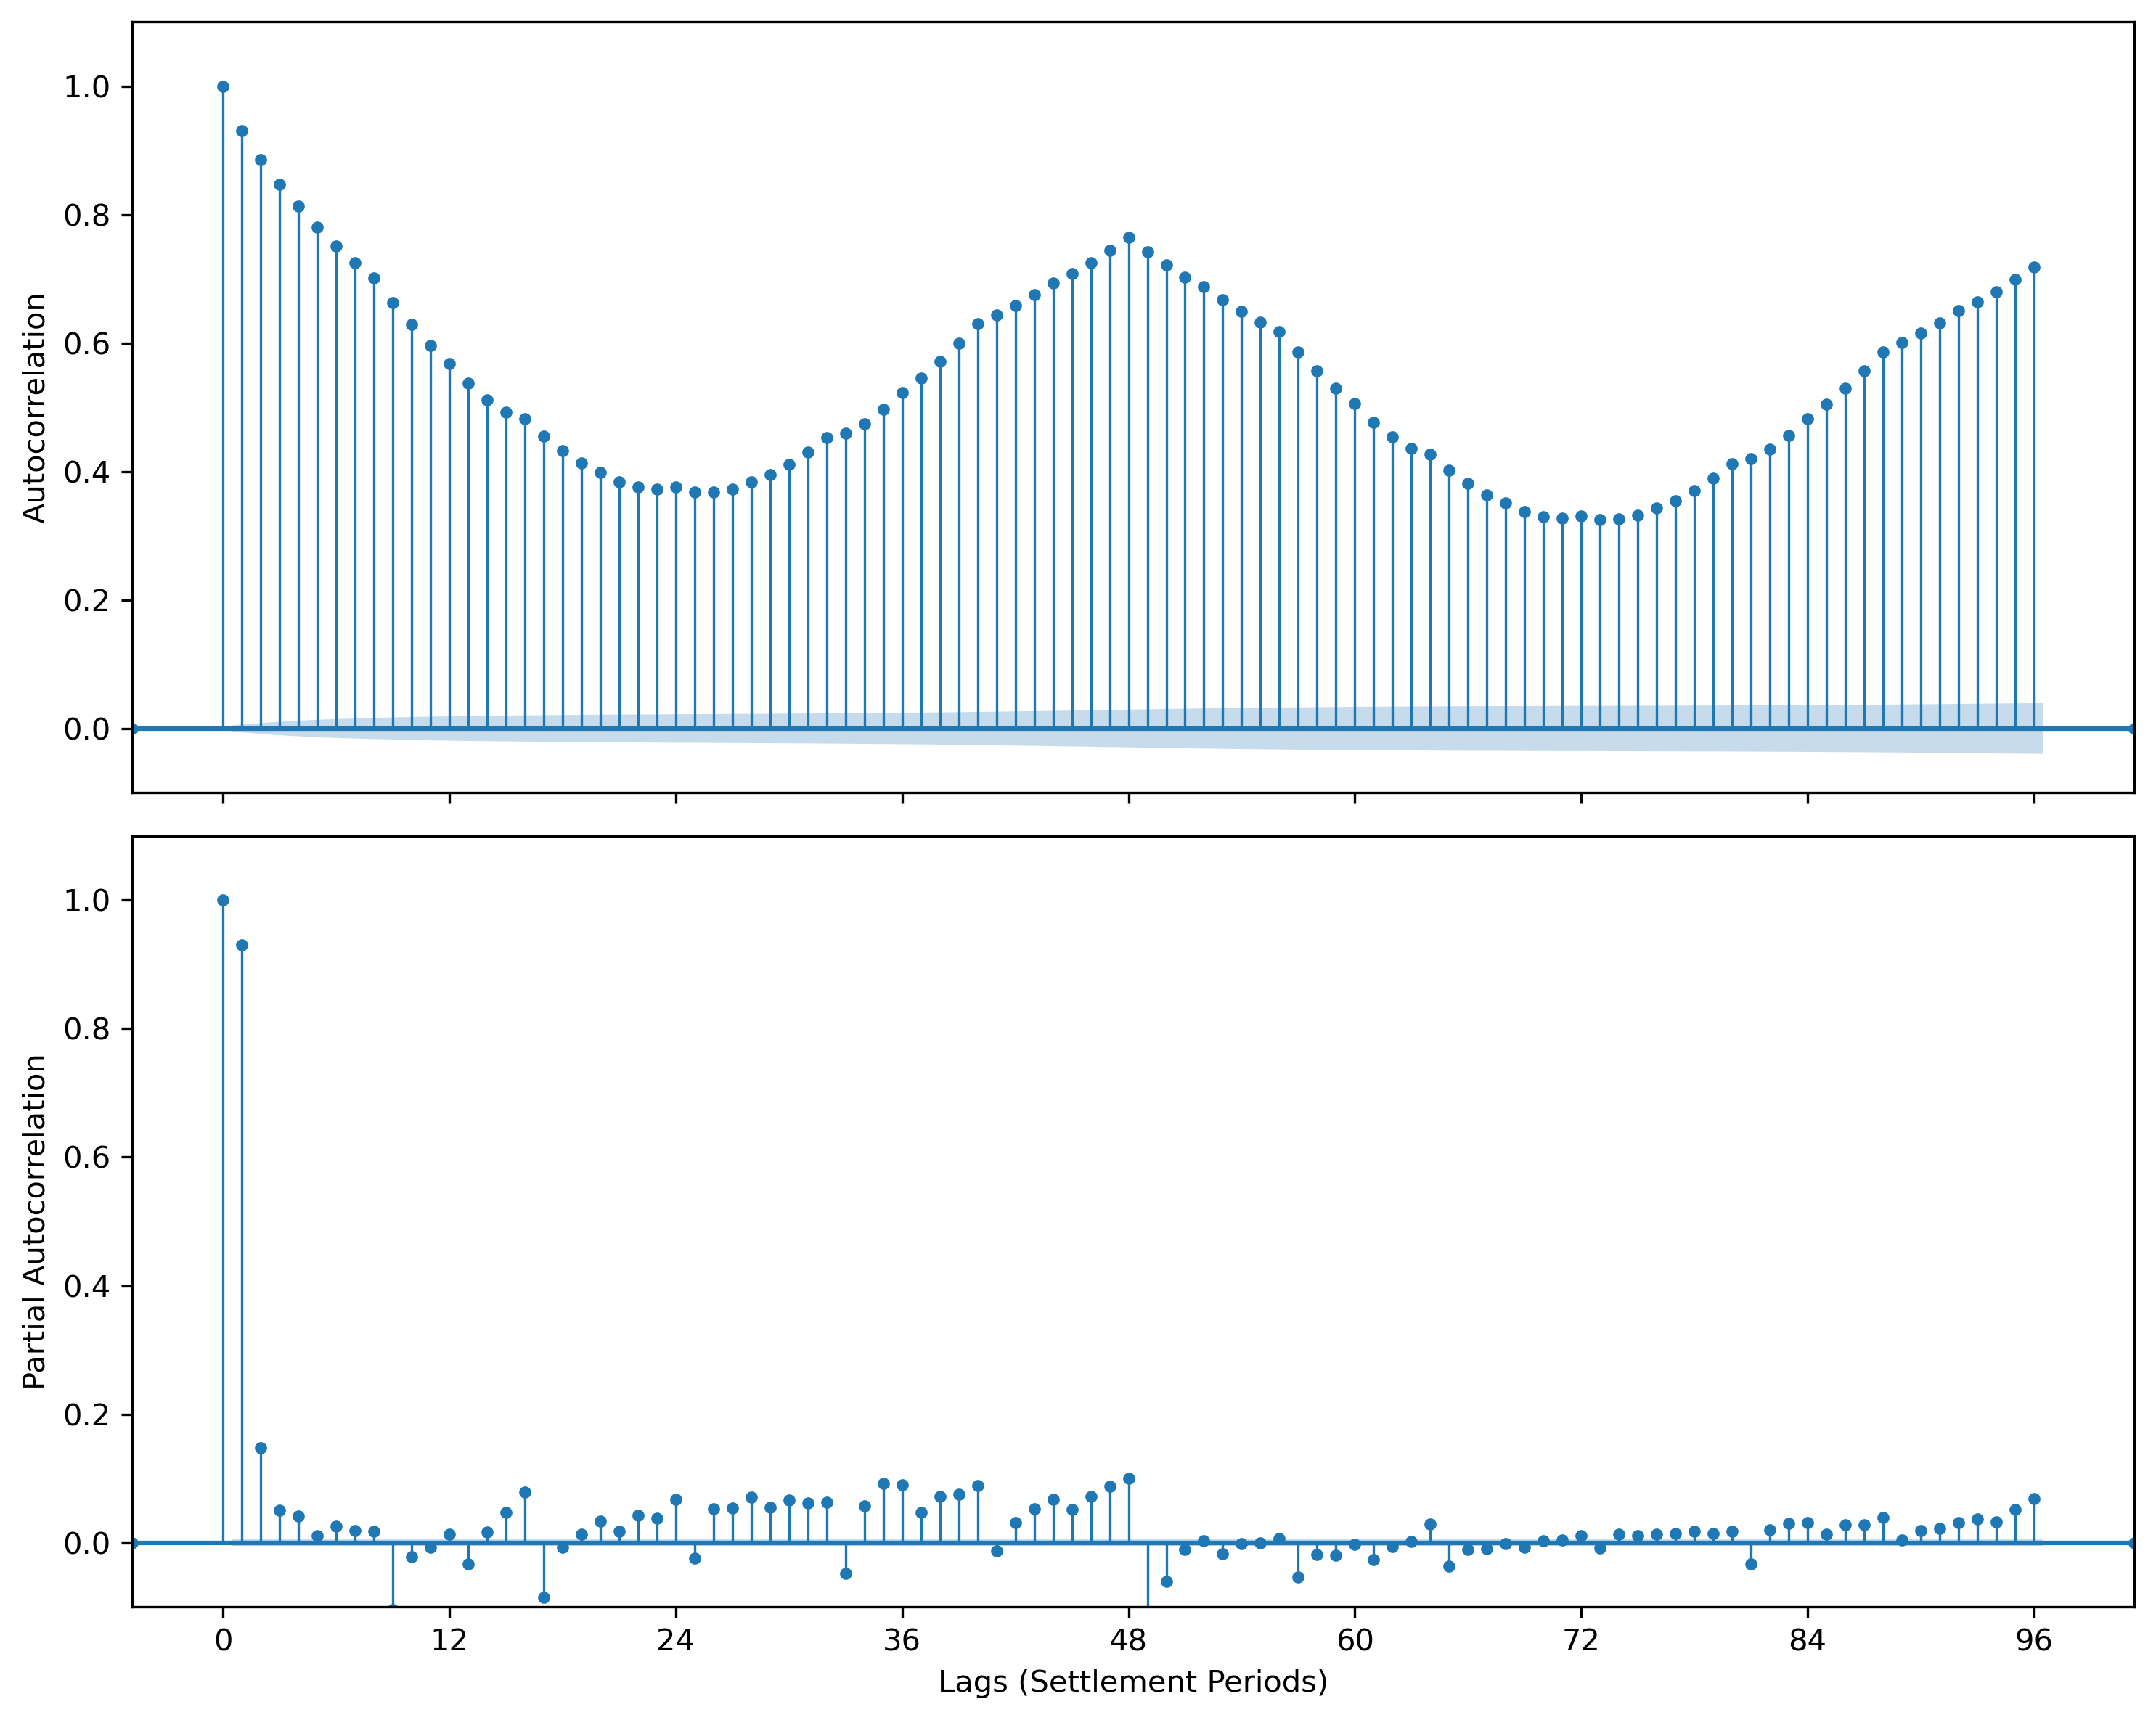

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_feed = "MID.csv"
plot_column = "volume"

file = pd.read_csv(FILLED_DIR/plot_feed).set_index("startTime")
df = file[plot_column]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# ACF plot
plot_acf(
    df,
    lags=96,
    ax=axes[0],
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_xticks(np.arange(0, 97, 12))
axes[0].tick_params(axis='x', labelbottom=False)
axes[0].set_title(None)

# PACF plot
plot_pacf(
    df,
    lags=96,
    ax=axes[1],
    method='ywm',
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
)
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_xticks(np.arange(0, 97, 12))
axes[1].set_xlabel("Lags (Settlement Periods)")
axes[1].set_title(None)

plt.tight_layout()
plt.show()



### Iterative Imputer

#### DAYAHEAD

In [16]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load everything
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])

da      = (pd.read_csv(RAW/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
              .set_index("startTime")[["windOffshoreGeneration"]])

# Build full half‑hourly DataFrame
df_full = pd.concat([da, datetime, mid, sysp, gpt, adem], axis=1)

# Identify static predictor columns vs. the target
static_cols = [c for c in df_full.columns if c != "windOffshoreGeneration"]

# Downsample to hourly (every other half‑hour)
df_hr = df_full.iloc[::2].copy()

param_grid = [
    # very shallow, big leaves, tiny feature subset
    { "max_depth": 2,
      "min_samples_split": 50,
      "min_samples_leaf": 20,
      "max_leaf_nodes": 10,
      "n_estimators": 500,
      "max_features": 0.3
    },
    # slightly deeper, still heavy regularisation
    { "max_depth": 3,
      "min_samples_split": 30,
      "min_samples_leaf": 15,
      "max_leaf_nodes": 15,
      "n_estimators": 500,
      "max_features": "sqrt"
    },
    # medium‑depth, medium regularisation
    { "max_depth": 5,
      "min_samples_split": 20,
      "min_samples_leaf": 10,
      "max_leaf_nodes": 20,
      "n_estimators": 300,
      "max_features": "log2"
    },
    # deeper but big leaf size
    { "max_depth": 8,
      "min_samples_split": 50,
      "min_samples_leaf": 20,
      "max_leaf_nodes": 25,
      "n_estimators": 200,
      "max_features": 0.5
    },
    # fallback: very large forest but small depth
    { "max_depth": 3,
      "min_samples_split": 10,
      "min_samples_leaf": 5,
      "max_leaf_nodes": 30,
      "n_estimators": 1000,
      "max_features": "sqrt"
    },
]


results_da = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # ---- 1) Impute on the hourly DataFrame ----
    with parallel_backend("loky", n_jobs=-1):
        arr_hr = imp.fit_transform(df_hr)
    df_hr_imp = pd.DataFrame(arr_hr, index=df_hr.index, columns=df_full.columns)

    # ---- 2) Rebuild half‑hourly DF ----
    df_imp = pd.DataFrame(index=df_full.index, columns=df_full.columns)

    # a) fill in the imputed hourly values
    df_imp.loc[df_hr_imp.index] = df_hr_imp

    # b) re‑insert original static predictors at the odd half‑hours
    df_imp[static_cols] = df_imp[static_cols].fillna(df_full[static_cols])

    # c) forward‑fill the wind series to get pseudo‑half‑hourly
    df_imp["windOffshoreGeneration"] = df_imp["windOffshoreGeneration"].astype(float).ffill()

    mask_missing = df_full["windOffshoreGeneration"].isna()

    results_da.append((
        params,
        df_imp["windOffshoreGeneration"],  # <-- just the imputed wind series
        mask_missing                       # <-- the boolean mask of imputed slots
    ))


Combo 1/5 – testing {'max_depth': 2, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_leaf_nodes': 10, 'n_estimators': 500, 'max_features': 0.3}
[IterativeImputer] Completing matrix with shape (73751, 9)
[IterativeImputer] Ending imputation round 1/10, elapsed time 11.25
[IterativeImputer] Change: 3639.3809722738565, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 2/10, elapsed time 22.17
[IterativeImputer] Change: 1.8189894035458565e-12, scaled tolerance: 51.506 
[IterativeImputer] Early stopping criterion reached.
Combo 2/5 – testing {'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 15, 'max_leaf_nodes': 15, 'n_estimators': 500, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (73751, 9)
[IterativeImputer] Ending imputation round 1/10, elapsed time 14.61
[IterativeImputer] Change: 4415.14000889564, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 2/10, elapsed time 29.26
[IterativeImputer] Change: 2.7284

In [ ]:
import plotly.graph_objects as go
from ipywidgets import Checkbox, VBox, HTML, Output, Layout
from IPython.display import display

# Build one checkbox per result – unpack params, wind_series and mask_missing
checkboxes = []
for i, (params, wind_series, mask_missing) in enumerate(results_da, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='300px')
    )
    checkboxes.append(cb)

checkbox_box = VBox(
    checkboxes,
    layout=Layout(overflow_y='auto', max_height='400px')
)
out = Output()

def update_plot(*_):
    fig = go.Figure()
    for idx, cb in enumerate(checkboxes, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_da[idx-1]
        name = f"Combo {idx}"
        # full imputed line
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        # red markers at the imputed points
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='red', size=6),
            name=f"{name} (imputed)"
        ))

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Wind generation',
        height=800,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.7)'
        ),
        margin=dict(t=120)
    )

    with out:
        out.clear_output(wait=True)
        display(fig)

# Attach the update callback
for cb in checkboxes:
    cb.observe(update_plot, names='value')

# Initial draw and display
update_plot()
display(HTML('<b>Select parameter sets to plot:</b>'), checkbox_box, out)


HTML(value='<b>Select parameter sets to plot:</b>')

Output()

#### ACTUAL

In [ ]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return pd.read_csv(p, parse_dates=["startTime"]) \
                     .set_index("startTime")[cols]
    raise FileNotFoundError(f"Cannot find {fname}")

# Load predictors
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])

# Load target series
act = pd.read_csv(RAW/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"]) \
          .set_index("startTime")[["windOffshoreGeneration"]]

# Build DataFrames
df_act = pd.concat([act, datetime, mid, sysp, gpt, adem], axis=1)

# Parameter grid
param_grid = [
    {"max_depth": 10, "min_samples_leaf": 10, "n_estimators": 100, "max_features": "sqrt"},
]

results_act = []

n=1

for params in param_grid:
    print(f"Testing params: {params} (combo {n})")
    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp_da  = IterativeImputer(estimator=rf, max_iter=10, initial_strategy="median", random_state=0, verbose=2)
    imp_act = IterativeImputer(estimator=rf, max_iter=10, initial_strategy="median", random_state=0, verbose=2)
    
    # ---- Actual ----
    print("Fitting Actual...")
    with parallel_backend("loky", n_jobs=-1):
        act_arr = imp_act.fit_transform(df_act)
    act_filled = pd.DataFrame(act_arr, index=df_act.index, columns=df_act.columns)
    act_imputed_mask = df_act["windOffshoreGeneration"].isna()
    act_diff   = act_filled["windOffshoreGeneration"].diff().abs()
    act_jagged = act_diff[act_imputed_mask].mean()
    results_act.append((params, act_jagged, act_filled, act_imputed_mask))

    n+=1

In [ ]:
import plotly.graph_objects as go
from ipywidgets import Checkbox, VBox, HTML, Output, Layout
from IPython.display import display

checkboxes = []
for i, (params, _, _, _) in enumerate(results_act, 1):
    cb = Checkbox(
        value=False,
        description=f"Params {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='300px')
    )
    checkboxes.append(cb)

checkbox_container = VBox(checkboxes, layout=Layout(overflow_y='auto', max_height='400px'))
out = Output()

last_xrange = None
last_yrange = None

def update_plot(*_):
    global last_xrange, last_yrange

    fig = go.Figure()
    for cb, (params, _, df, imputed_mask) in zip(checkboxes, results_act):
        if not cb.value:
            continue

        fig.add_trace(go.Scatter(
            x=df.index,
            y=df["windOffshoreGeneration"],
            mode="lines",
            name=f"Params {params}"
        ))
        fig.add_trace(go.Scatter(
            x=df.index[imputed_mask],
            y=df["windOffshoreGeneration"][imputed_mask],
            mode="markers",
            marker=dict(color="red", size=6),
            name=f"Params {params} (imputed)"
        ))

    fig.update_layout(
        title="",
        xaxis_title="Time",
        yaxis_title="Generation",
        height=800,
        legend=dict(
            orientation="h",        # legend back to above the plot
            yanchor="bottom",
            y=1.02,                 # above the plot
            xanchor="left",
            x=0,
            traceorder="normal",
            font=dict(size=10),
            itemsizing="trace",
            bgcolor="rgba(255,255,255,0.7)"
        ),
        margin=dict(t=120)  # extra space for the legend above
    )

    # Keep zoom when updating
    if last_xrange:
        fig.update_xaxes(range=last_xrange)
    if last_yrange:
        fig.update_yaxes(range=last_yrange)

    with out:
        out.clear_output(wait=True)
        display(fig)

for cb in checkboxes:
    cb.observe(update_plot, names='value')

# ==== Display ====
update_plot()
display(HTML("<b>Select parameter sets to plot:</b>"), checkbox_container, out)


HTML(value='<b>Select parameter sets to plot:</b>')

Output()

## Displaying the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.lines import Line2D

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, MSTL

from ipywidgets import HBox, VBox, Checkbox, interactive_output

CSV_DIR = Path("bmrs_csv") 

paths = {
    "imbalance": CSV_DIR / "SYSTEM_PRICES.csv",
    "mid":       CSV_DIR / "MID.csv",
    "agws":      CSV_DIR / "ACTUAL_GEN_WIND_SOLAR.csv",
    "dgws":      CSV_DIR / "DAYAHEAD_GEN_WIND_SOLAR.csv",
    "ad":        CSV_DIR / "ACTUAL_DEMAND.csv",
    "dd":        CSV_DIR / "DAYAHEAD_DEMAND.csv",
    "inter":     CSV_DIR / "INTER.csv",
    "drm":       CSV_DIR / "LOLPDRM.csv"
}

df_imbalance = (pd.read_csv(paths["imbalance"], parse_dates=["startTime"])
                  .set_index("startTime"))
df_mid       = (pd.read_csv(paths["mid"],       parse_dates=["startTime"])
                  .set_index("startTime"))
df_agws      = (pd.read_csv(paths["agws"],      parse_dates=["startTime"])
                  .set_index("startTime"))
df_dgws      = (pd.read_csv(paths["dgws"],      parse_dates=["startTime"])
                  .set_index("startTime"))
df_ad        = (pd.read_csv(paths["ad"],        parse_dates=["startTime"])
                  .set_index("startTime"))
df_dd        = (pd.read_csv(paths["dd"],        parse_dates=["startTime"])
                  .set_index("startTime"))
df_inter     = (pd.read_csv(paths["inter"],     parse_dates=["startTime"])
                  .set_index("startTime"))
df_drm       = (pd.read_csv(paths["drm"],       parse_dates=["startTime"])
                  .set_index("startTime"))

# System Prices, Market Prices, and Volumes
price       = df_imbalance["systemPrice"]
wholesale   = df_mid["price"]
diff        = price - wholesale
volume      = df_imbalance["netImbalanceVolume"]

# Wind & solar forecast errors (in GW)
act_total_wind = (df_agws["windOnshoreGeneration"] + df_agws["windOffshoreGeneration"]) /1_000
act_solar      = df_agws["solarGeneration"] / 1_000

fc_total_wind  = df_dgws["windOnshoreGeneration"] + df_dgws["windOffshoreGeneration"] / 1_000
fc_solar       = df_dgws["solarGeneration"] / 1_000

wind_error    = act_total_wind - fc_total_wind
solar_error   = act_solar - fc_solar

# Demand forecast error (in GW)
demand_error  = (df_ad["initialTransmissionSystemDemandOutturn"] - df_dd["transmissionSystemDemand"]) / 1_000

# Interconnector delta (in GW)
df_inter["totalInterGen"] = df_inter.filter(like="INT").sum(axis=1)
inter_delta = df_inter["totalInterGen"].diff().fillna(0) / 1_000

# De-rated margin (1h, in GW)
drm_1h      = df_drm["1hDRM"] / 1_000

# Combine into one DataFrame
df_all = pd.concat([
    price.rename("Imbalance Price"),
    volume.rename("Imbalance Volume"),
    wholesale.rename("Market Index"),
    act_total_wind.rename("Actual Wind"),
    wind_error.rename("Wind Error"),
    act_solar.rename("Actual Solar"),
    solar_error.rename("Solar Error"),
    demand_error.rename("Demand Error"),
    drm_1h.rename("De-Rated Margin (1h)"),
    inter_delta.rename("Inter Delta")
], axis=1)

# Z-score normalised DataFrame
df_z = (df_all - df_all.mean()) / df_all.std()

# Tab colours for plotting
tab_colours = [
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink", "tab:gray",
    "tab:olive", "tab:cyan"
]

print("Data loaded: df_all shape =", df_all.shape)

# Global Matplotlib configuration for publication‐quality figures
plt.rcParams.update({
    # Resolution
    "figure.dpi": 300,
    # Font
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    # Figure size (optional – adjust as needed)
    "figure.figsize": (10, 6),
    # Title and label font sizes
    "figure.titlesize": 18,    # overall figure title
    "axes.titlesize": 18,      # axes title
    "axes.labelsize": 14,      # x/y axis labels
    # Tick label size
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # Legend
    "legend.fontsize": 12,
    # Line width (for plot lines)
    "lines.linewidth": 1.5,
    # Grid styling (optional)
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})

Data loaded: df_all shape = (147502, 10)


### Imbalance Price

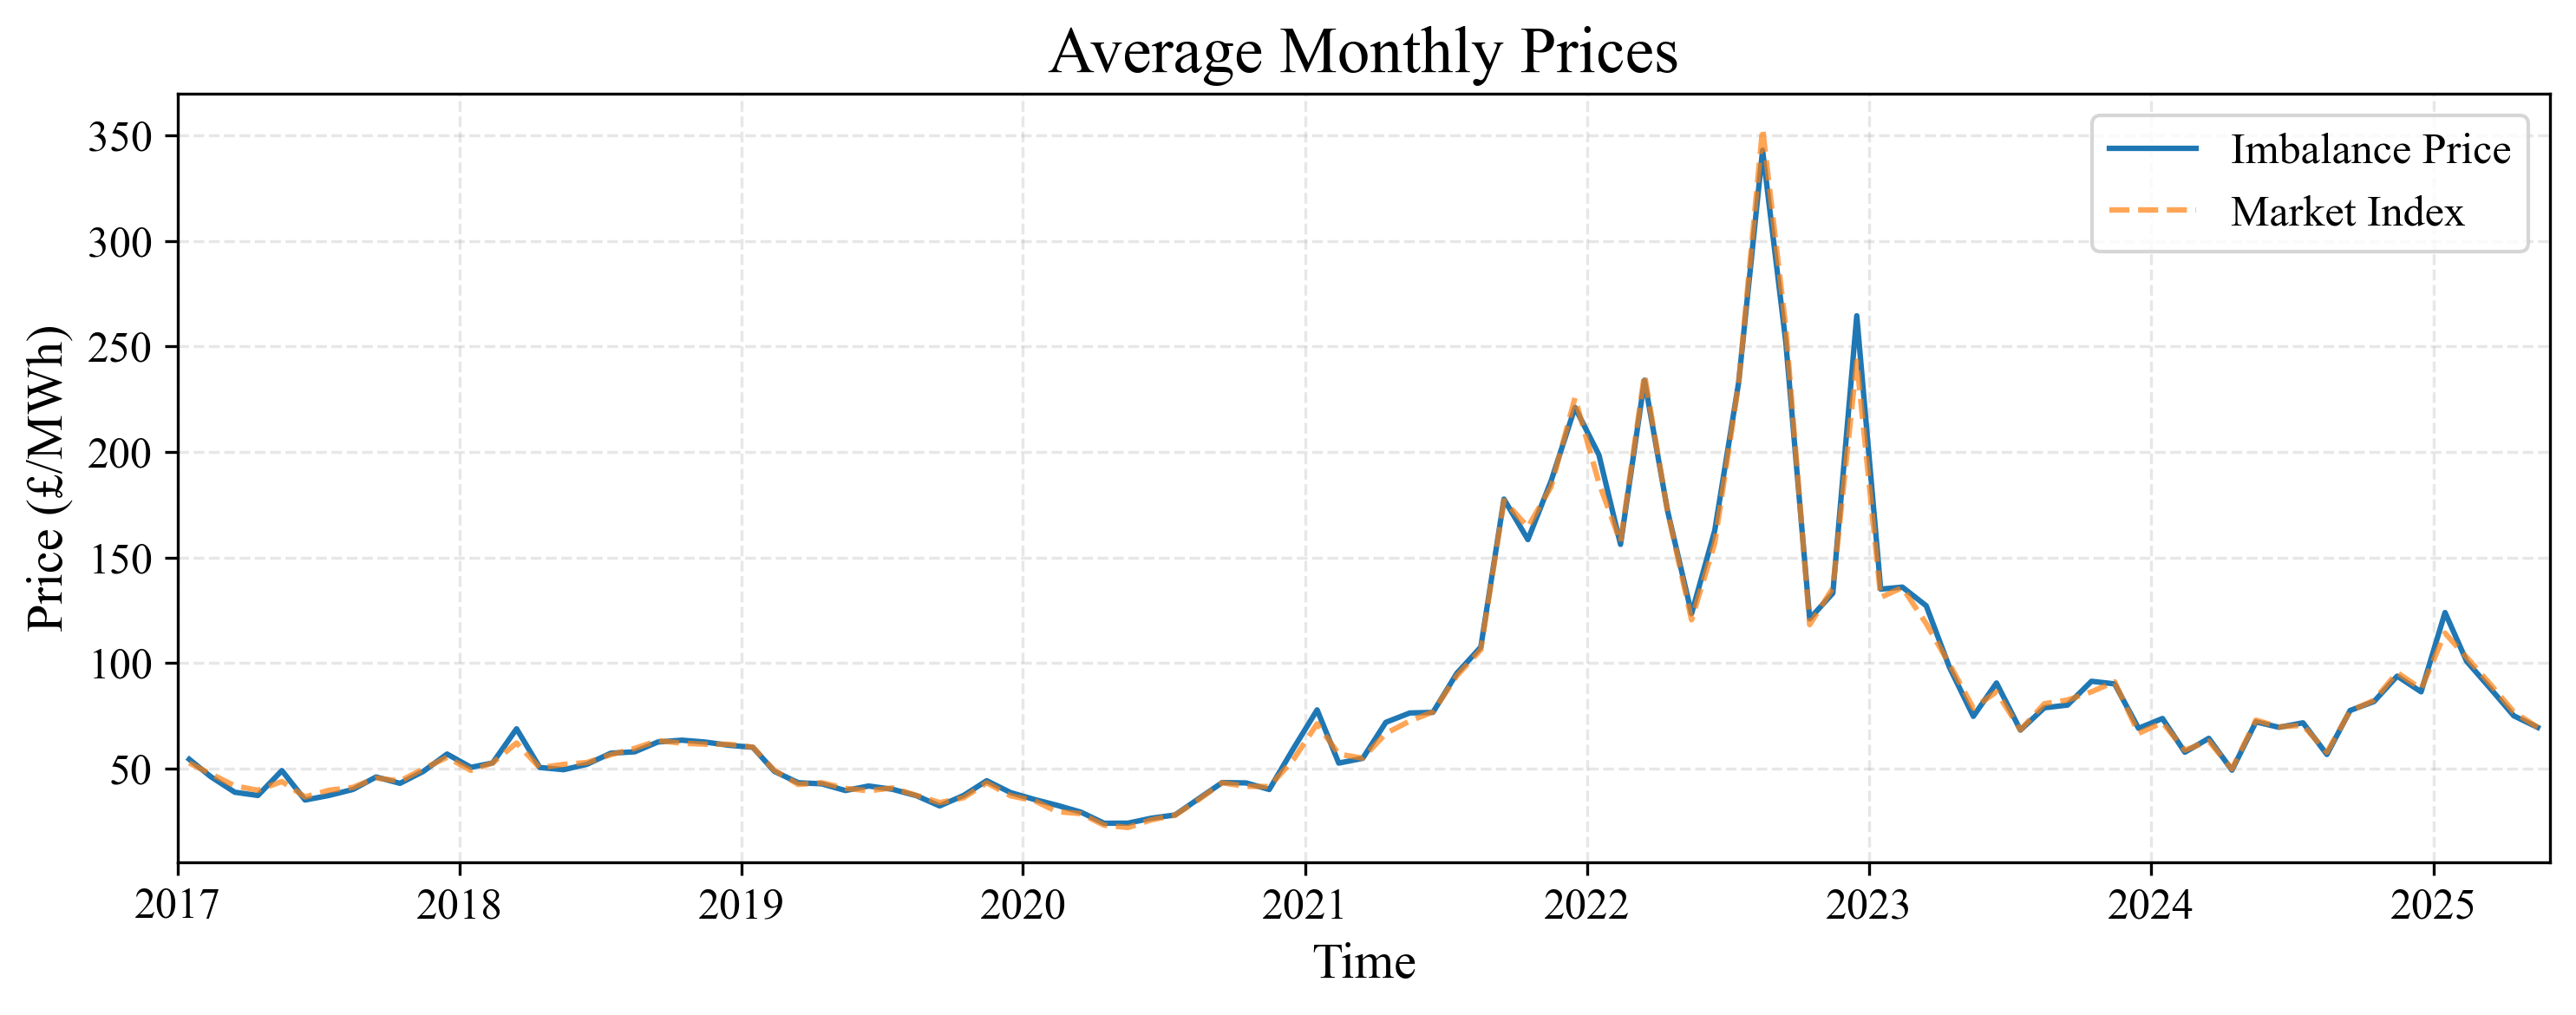

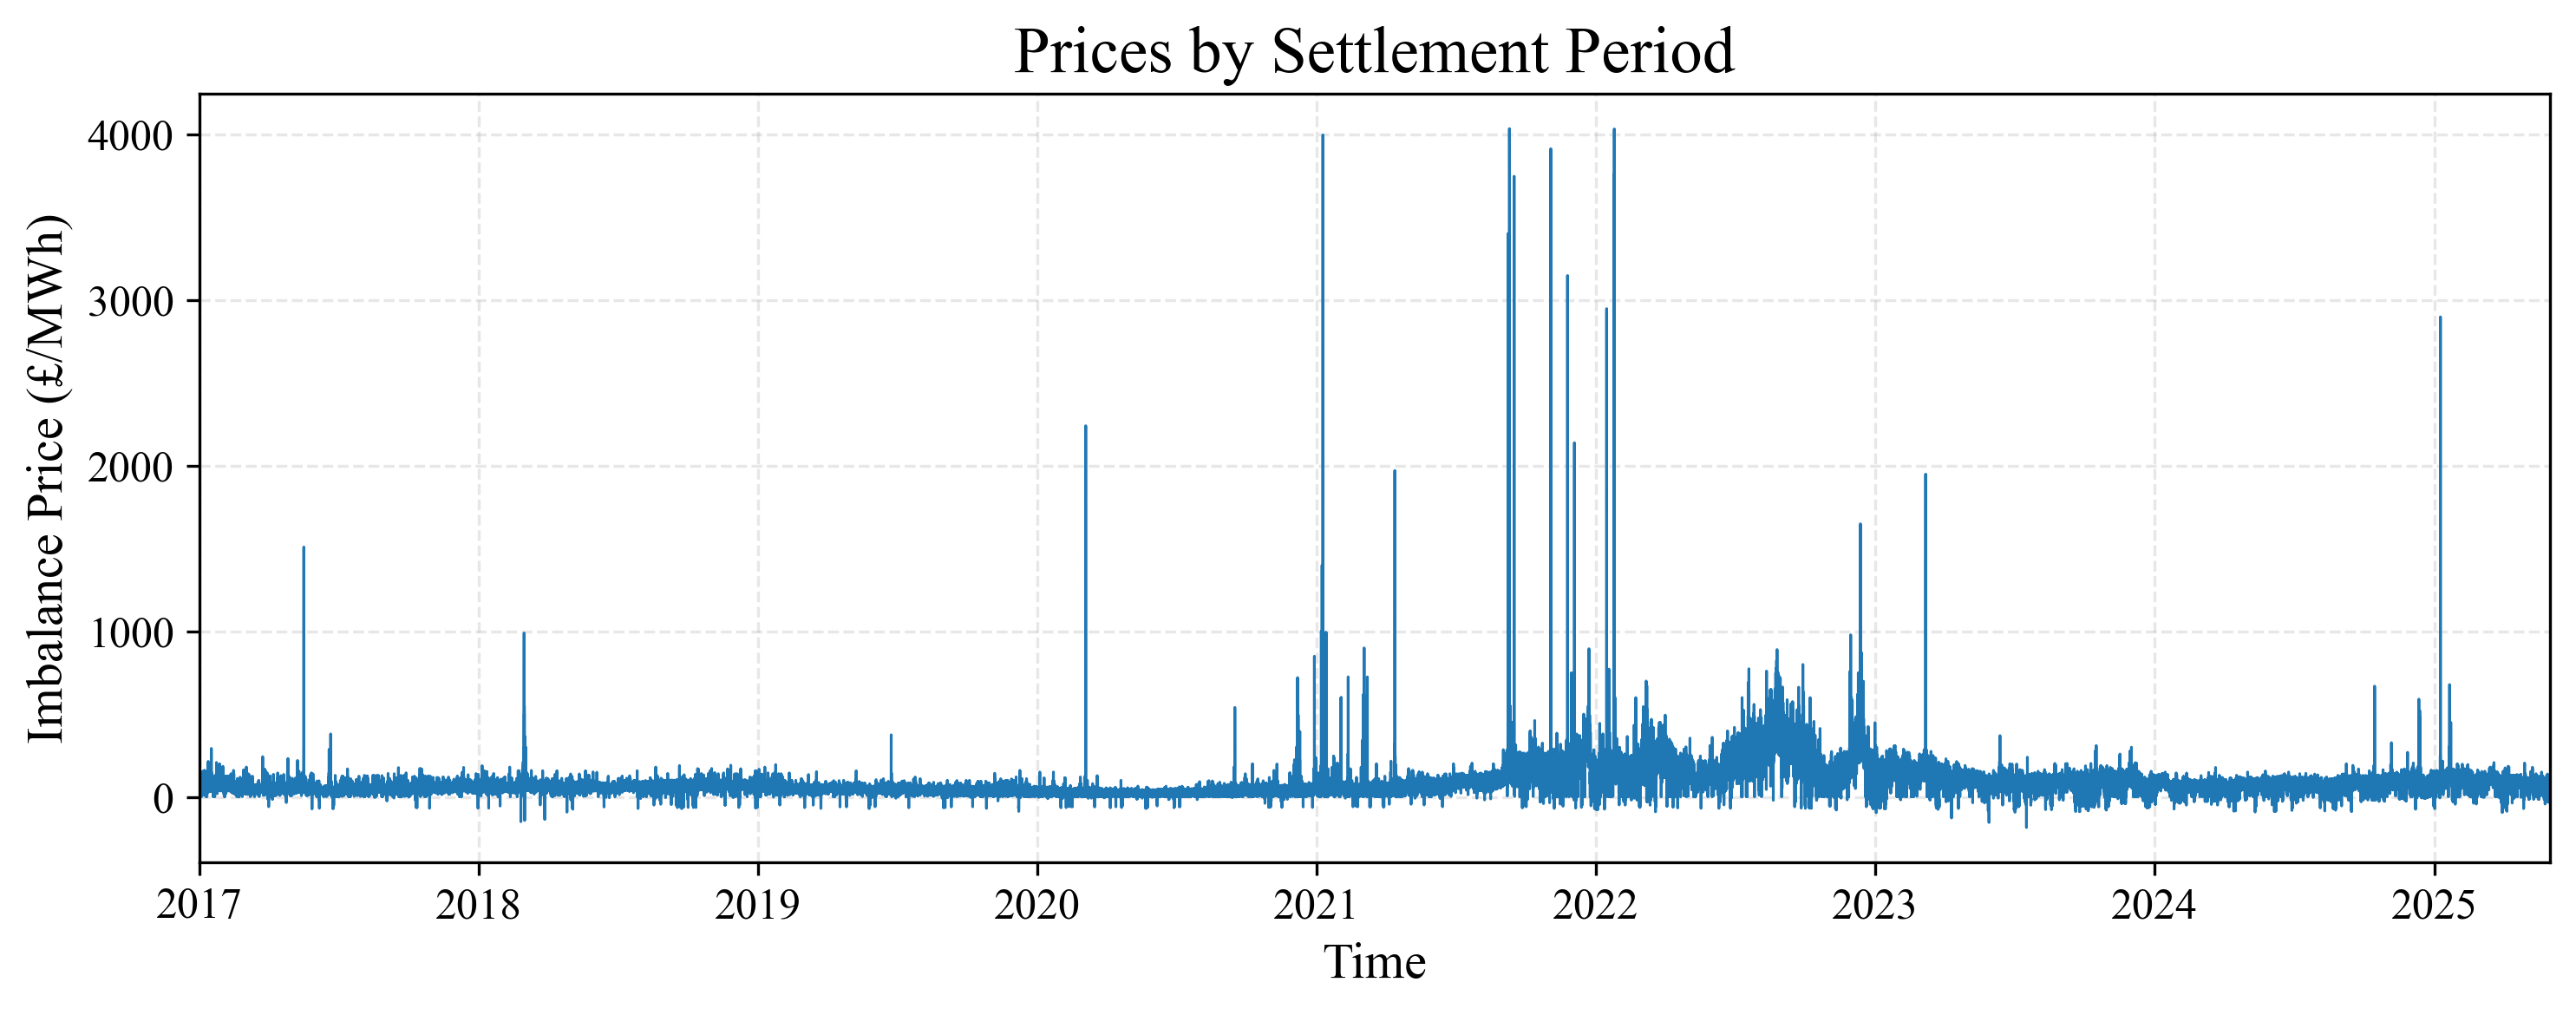

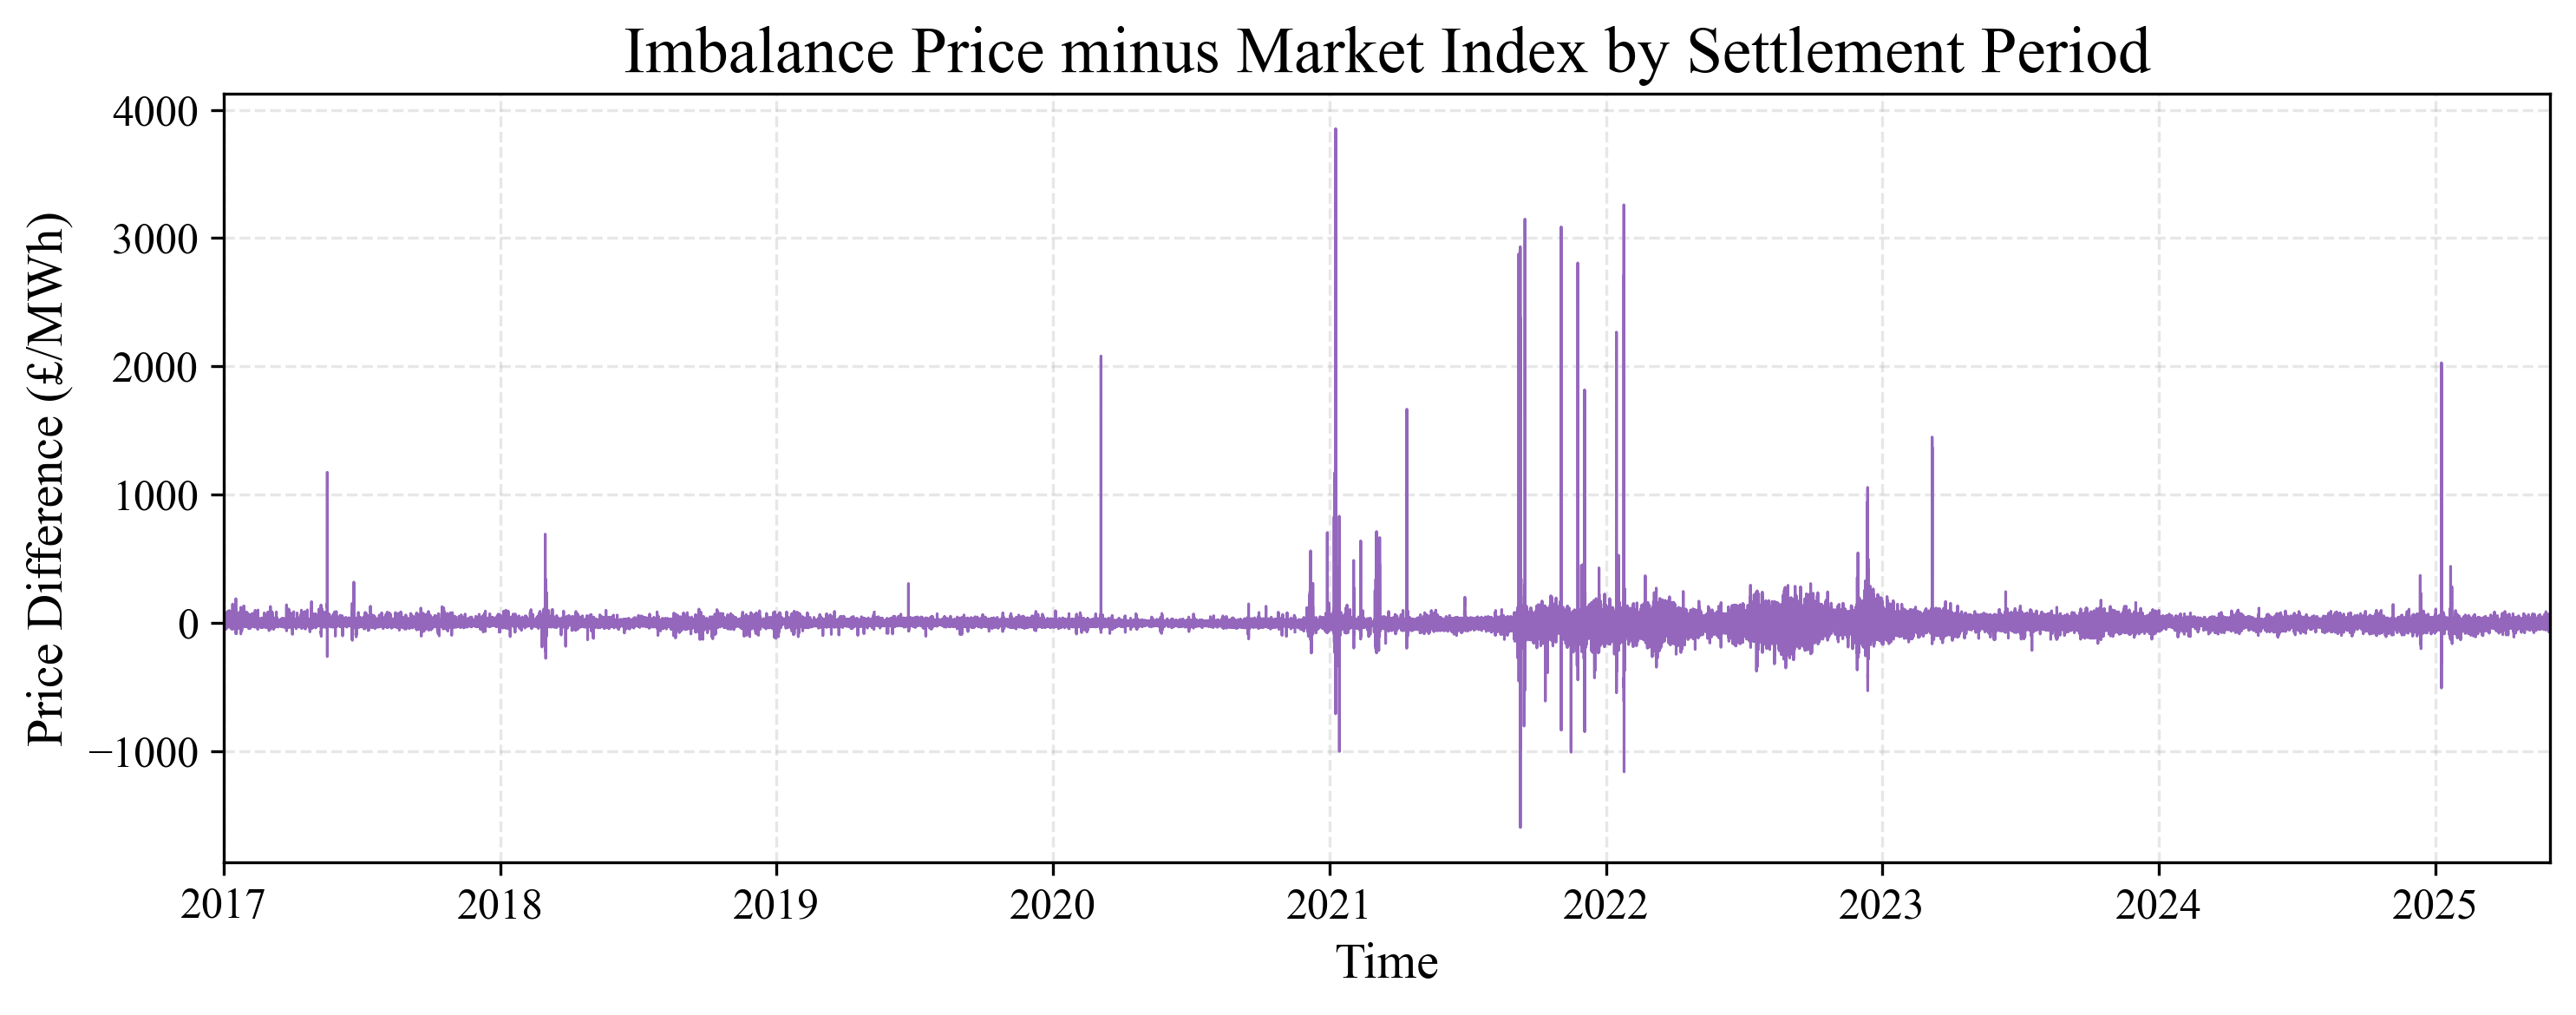

In [2]:
monthly_avg_price = price.resample("ME").mean().shift(freq='-15D')
monthly_avg_market = wholesale.resample("ME").mean().shift(freq='-15D')

plt.figure(figsize=(10,4))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, label='Imbalance Price', color='tab:blue')
plt.plot(monthly_avg_market.index, monthly_avg_market.values, label='Market Index', linestyle='--', alpha=.7, color='tab:orange')
plt.title("Average Monthly Prices")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(price.index, price.values, linewidth=.75, color='tab:blue', alpha=1)
plt.title("Prices by Settlement Period")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Imbalance Price (£/MWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(diff.index, diff.values, linewidth=.75, color='tab:purple', alpha=1)
plt.title("Imbalance Price minus Market Index by Settlement Period")
plt.xlabel("Time")
plt.xlim(diff.index.min(), diff.index.max())
plt.ylabel("Price Difference (£/MWh)")
plt.tight_layout()
plt.show()

### Imbalance Price vs. Imbalance Volume

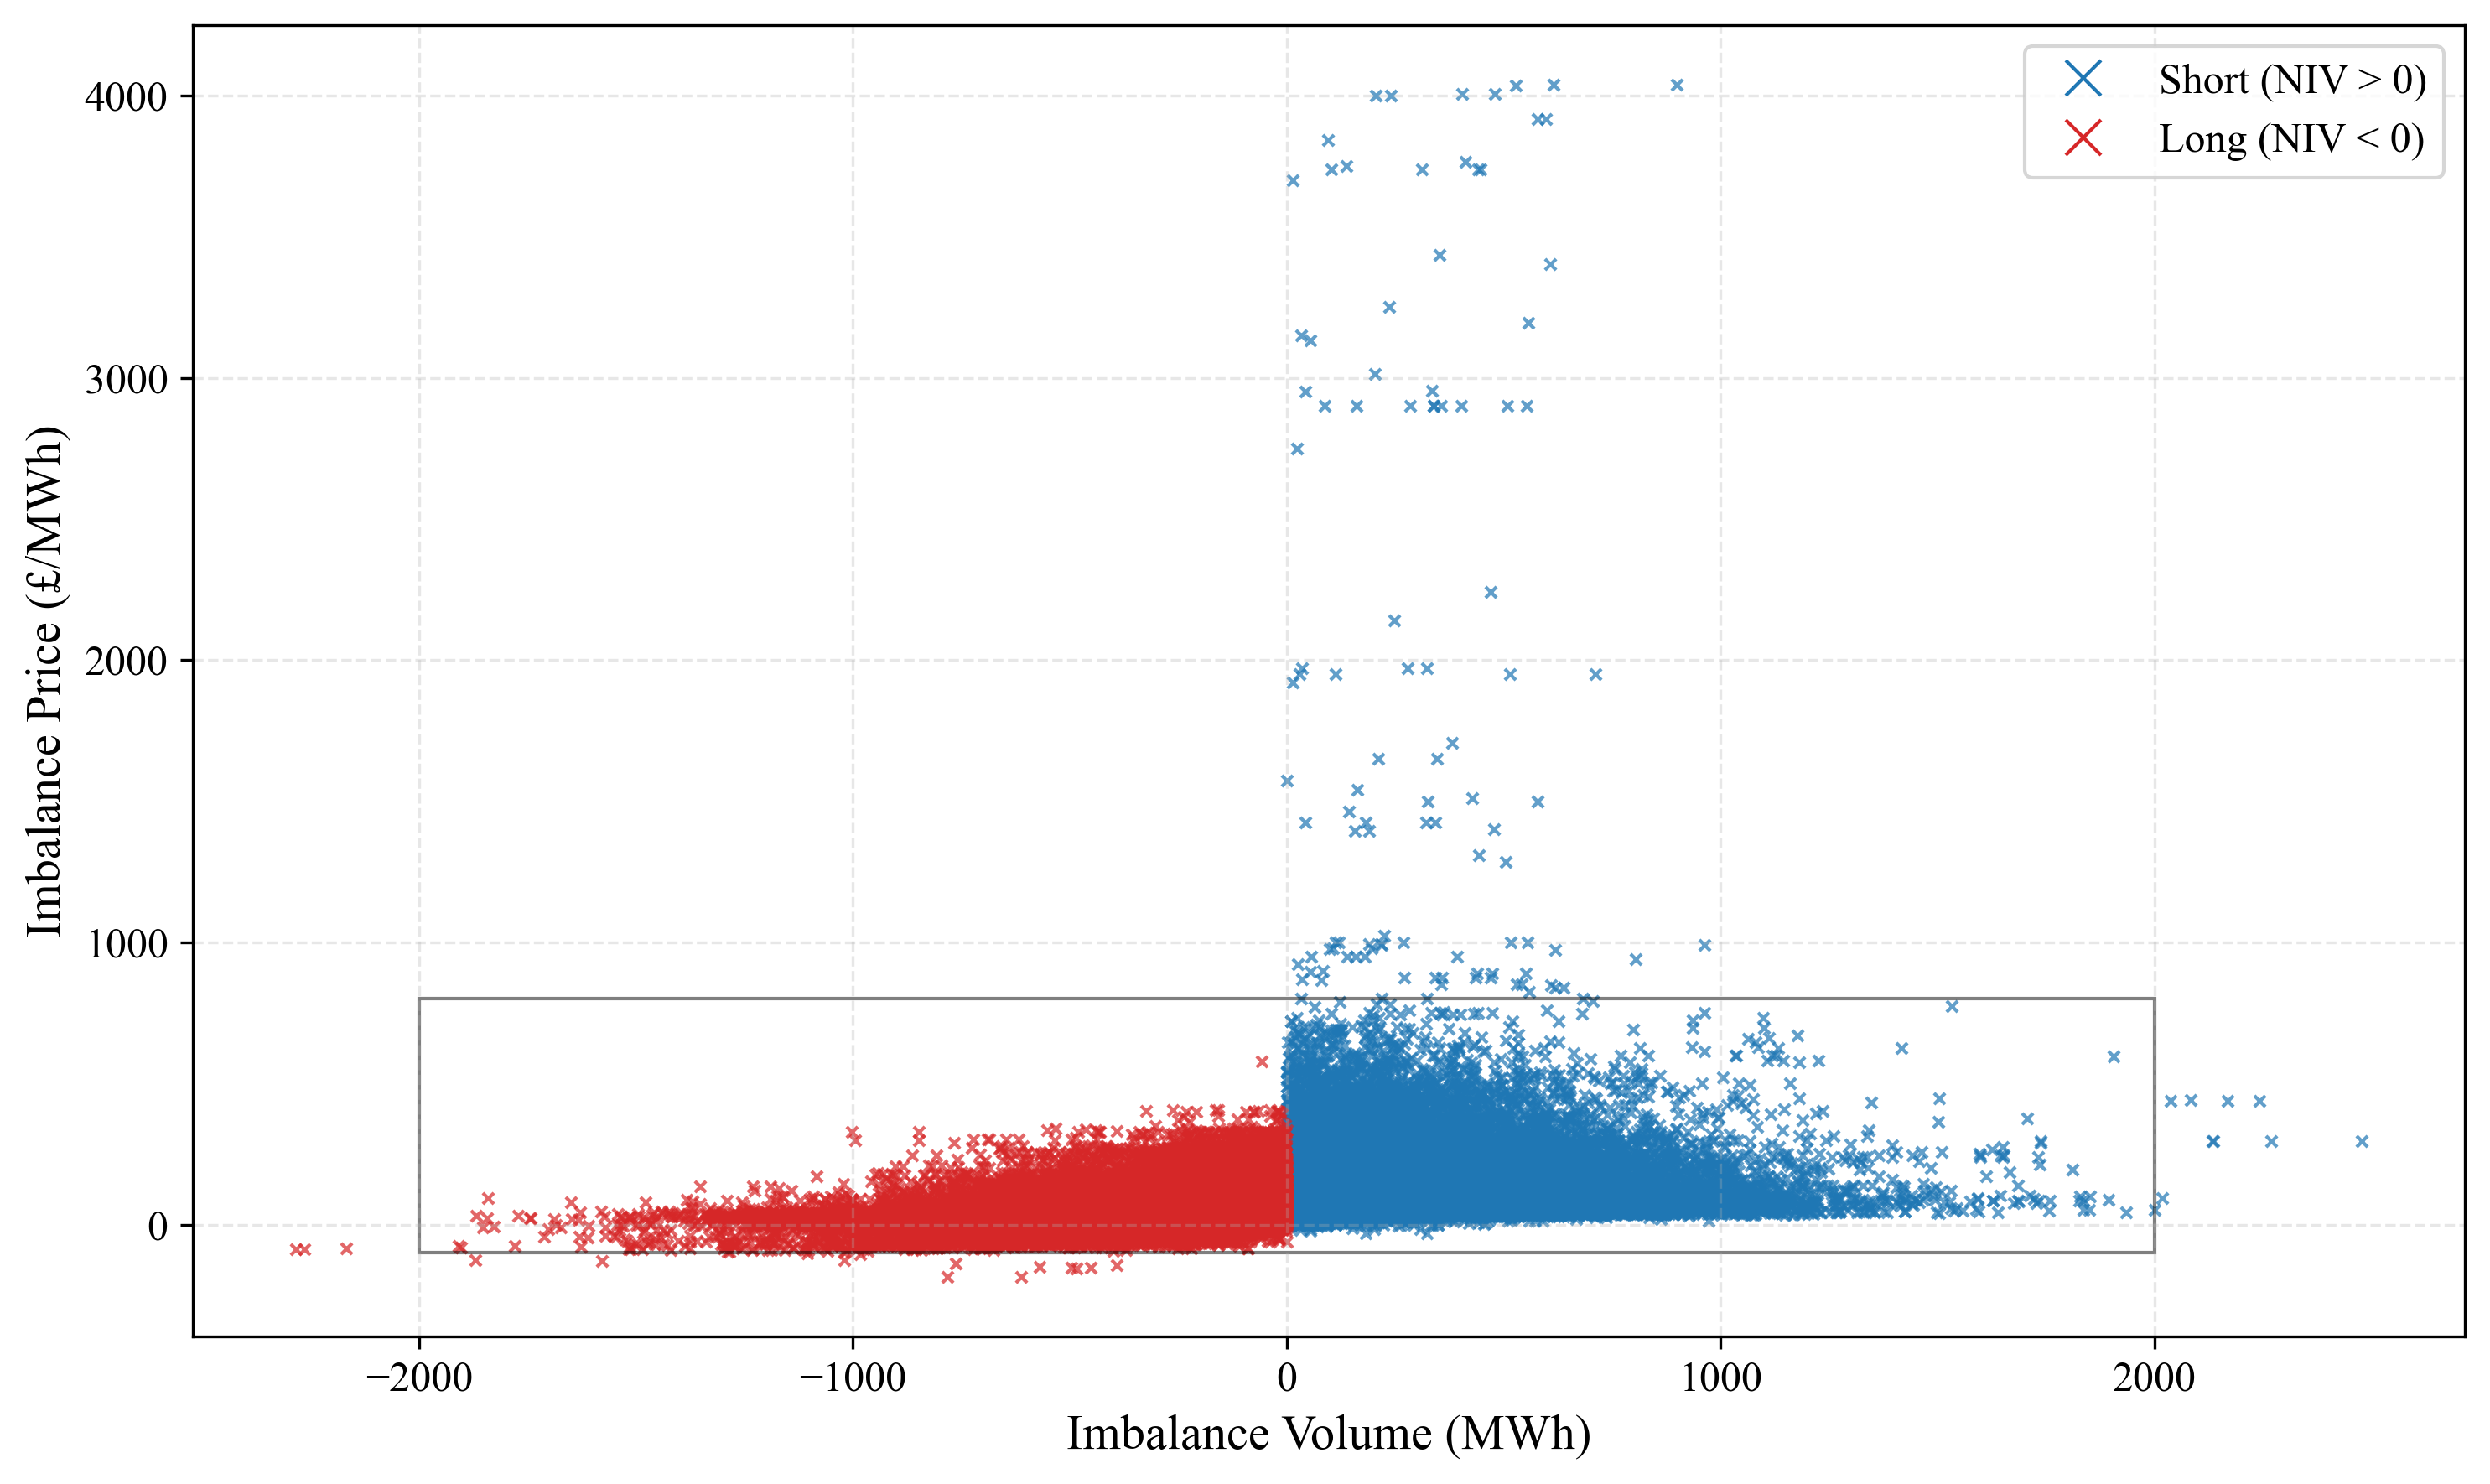

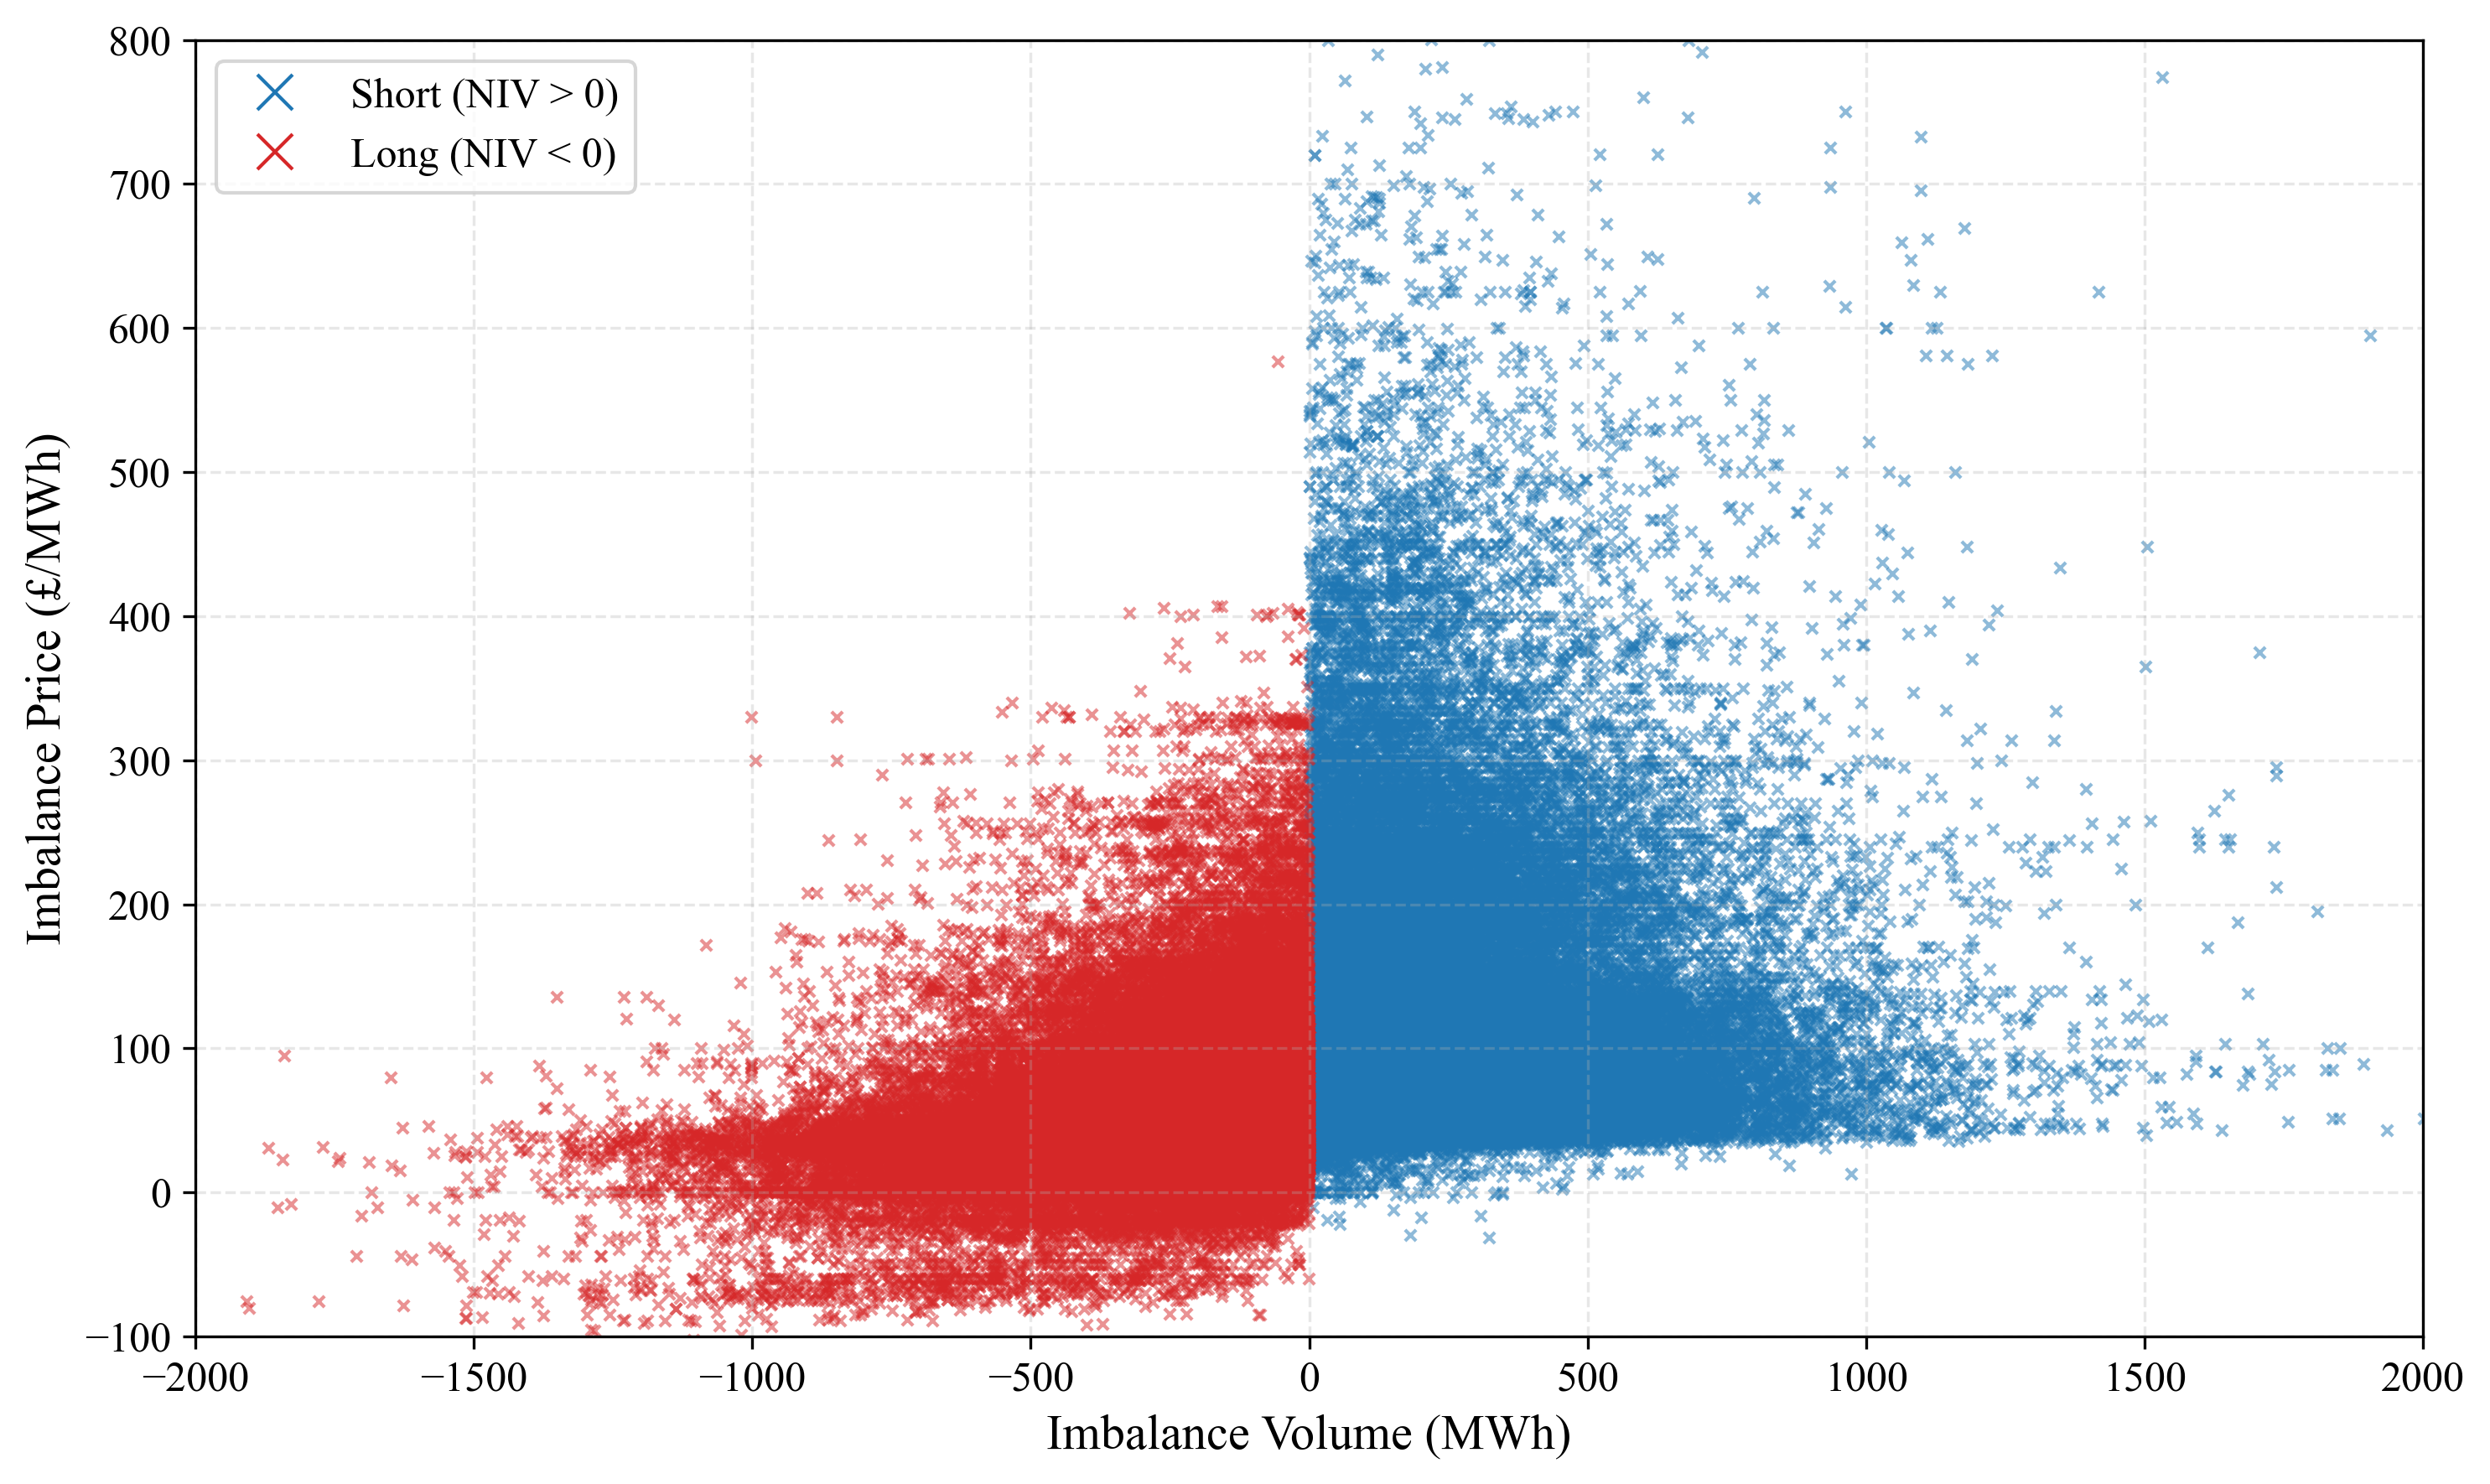

In [3]:
neg_mask = volume < 0

# 1) Full scatter with coloured markers
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.7, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red')

# Custom legend with larger markers
legend_handles = [
    Line2D([0], [0], marker='x', color='tab:blue', markersize=10, linestyle='None', label="Short (NIV > 0)"),
    Line2D([0], [0], marker='x', color='tab:red',  markersize=10, linestyle='None', label="Long (NIV < 0)")
]
plt.legend(handles=legend_handles)

plt.gca().add_patch(
    plt.Rectangle(
        (-2000, -100), 4000, 900,
        fill=False, edgecolor="black", linewidth=1, alpha=0.5
    )
)
plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.tight_layout()
plt.show()

# 2) Zoomed-in version
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.5, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.5, marker='x', s=10, linewidths=1, color='tab:red')

# Reuse the same custom legend
plt.legend(handles=legend_handles)

plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.xlim(-2000, 2000)
plt.ylim(-100, 800)
plt.tight_layout()
plt.show()


### Day-Ahead Forecast vs Actual

In [4]:
wind_error_abs = wind_error.abs()
solar_error_abs = solar_error.abs()

# Resample and shift timestamps to month centres
monthly_wind_error_gw  = wind_error_abs.resample("ME").mean().shift(freq='-15D')
monthly_solar_error_gw = solar_error_abs.resample("ME").mean().shift(freq='-15D')


#1) Wind & Solar error time series in GW
plt.figure(figsize=(10, 4))
plt.plot(wind_error_gw.index,  wind_error_gw.values,  label="Wind Error", linewidth=0.75, alpha=0.9)
plt.plot(solar_error_gw.index, solar_error_gw.values, label="Solar Error", linewidth=0.75, alpha=0.9)
plt.title("Wind and Solar Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, max(wind_error.max(), solar_error.max()) / 1_000 * 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Total forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(total_error_abs_gw.index, total_error_abs_gw.values, color='tab:purple', linewidth=0.75)
plt.title("Renewable Generation Forecast Error (Absolute)")
plt.xlabel("Time")
plt.ylabel("Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, total_error_gw.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_wind_error_gw.index,  monthly_wind_error_gw.values,  label="Wind Error")
plt.plot(monthly_solar_error_gw.index, monthly_solar_error_gw.values, label="Solar Error")
plt.title("Average Monthly Wind and Solar Forecast Error (Absolute)")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(monthly_wind_error_gw.min() * 1.05, monthly_solar_error_gw.max() * 1.05)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'wind_error_gw' is not defined

<Figure size 3000x1200 with 0 Axes>

### Demand Forecast Error

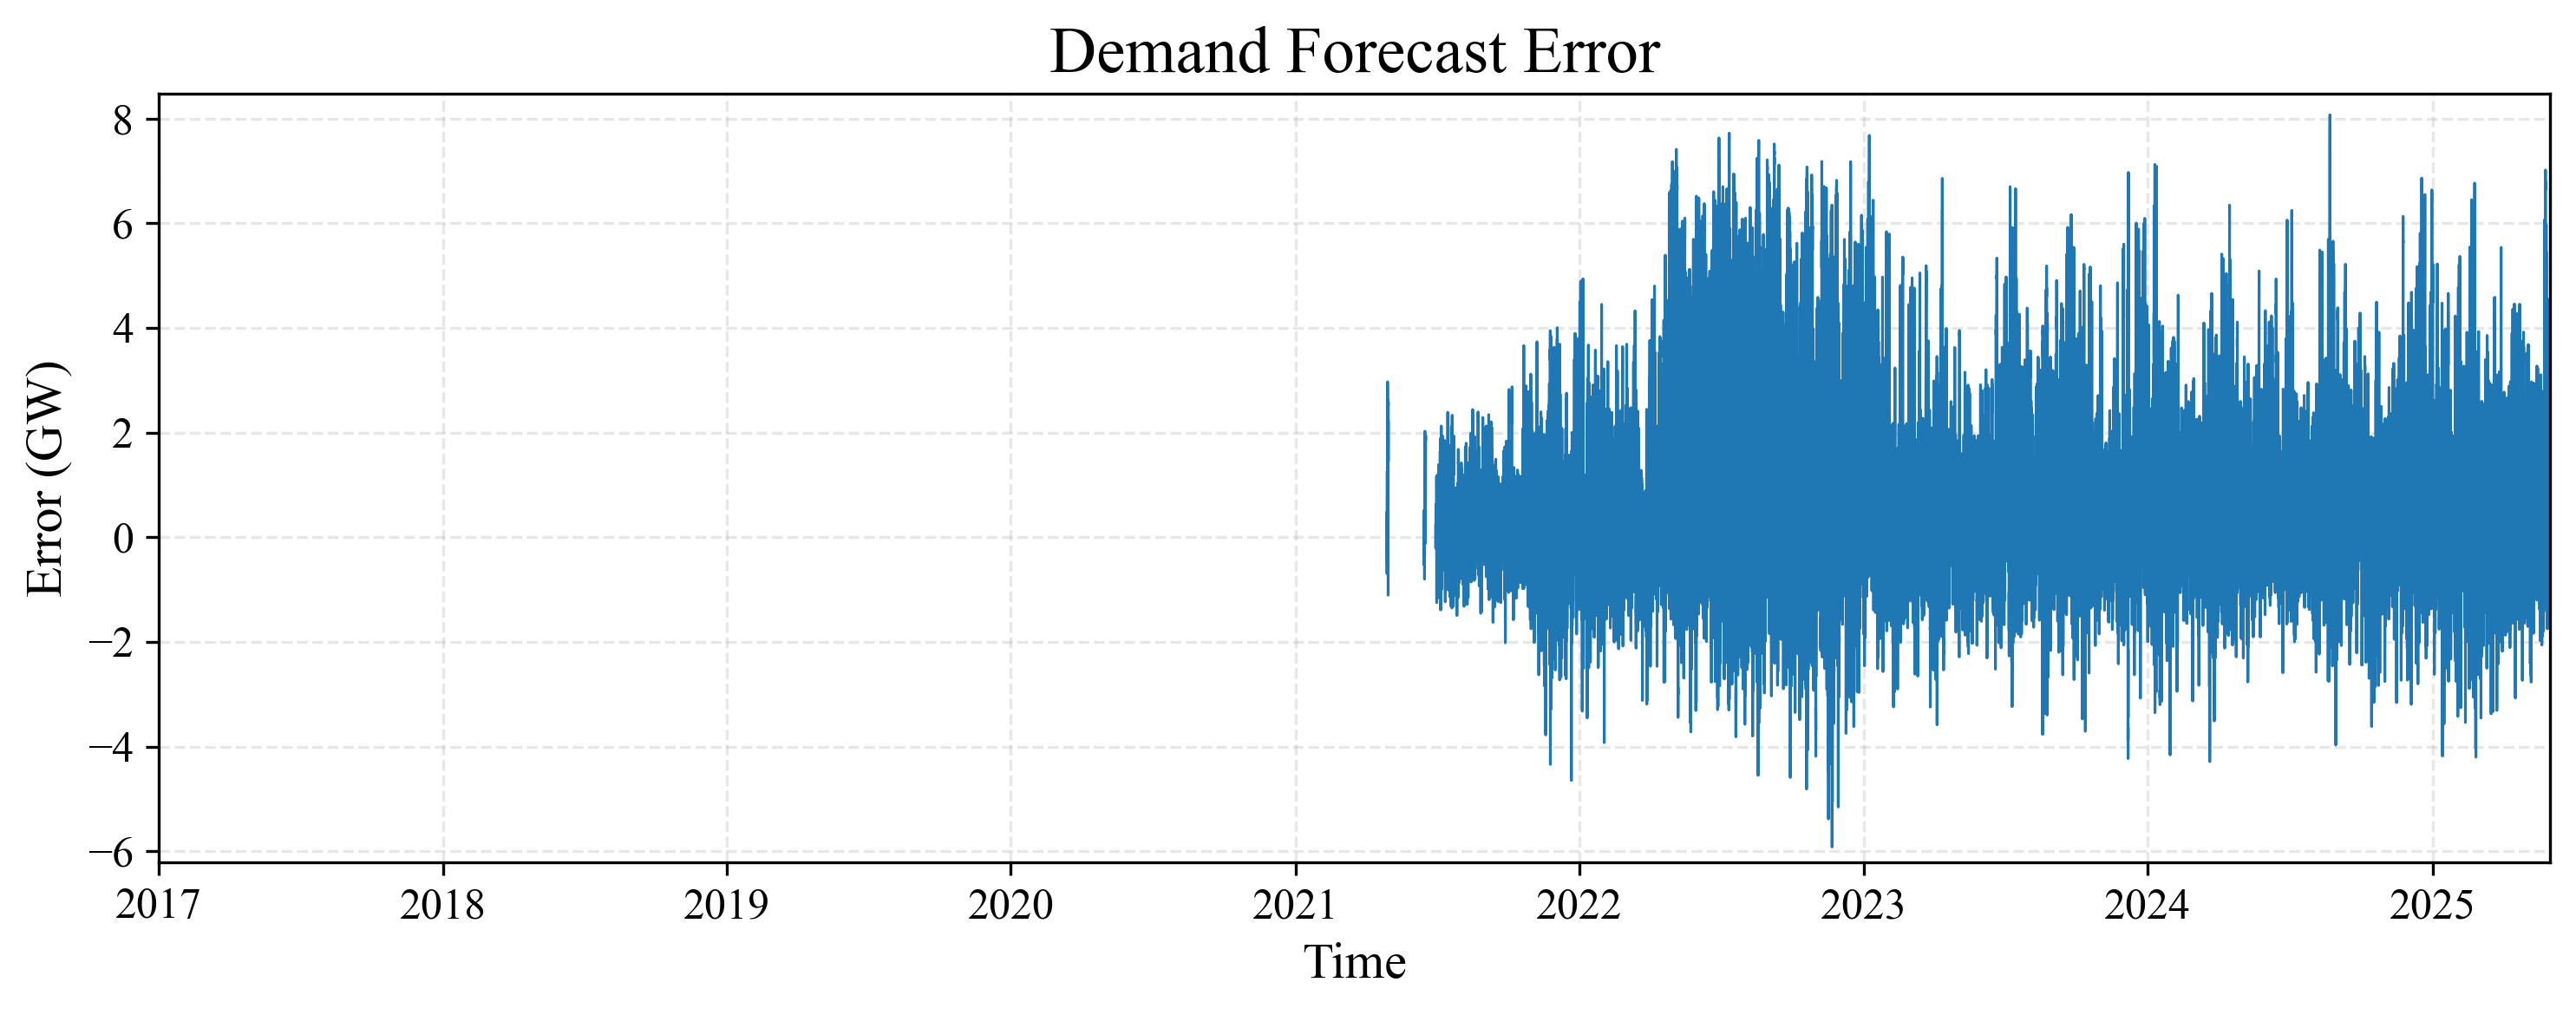

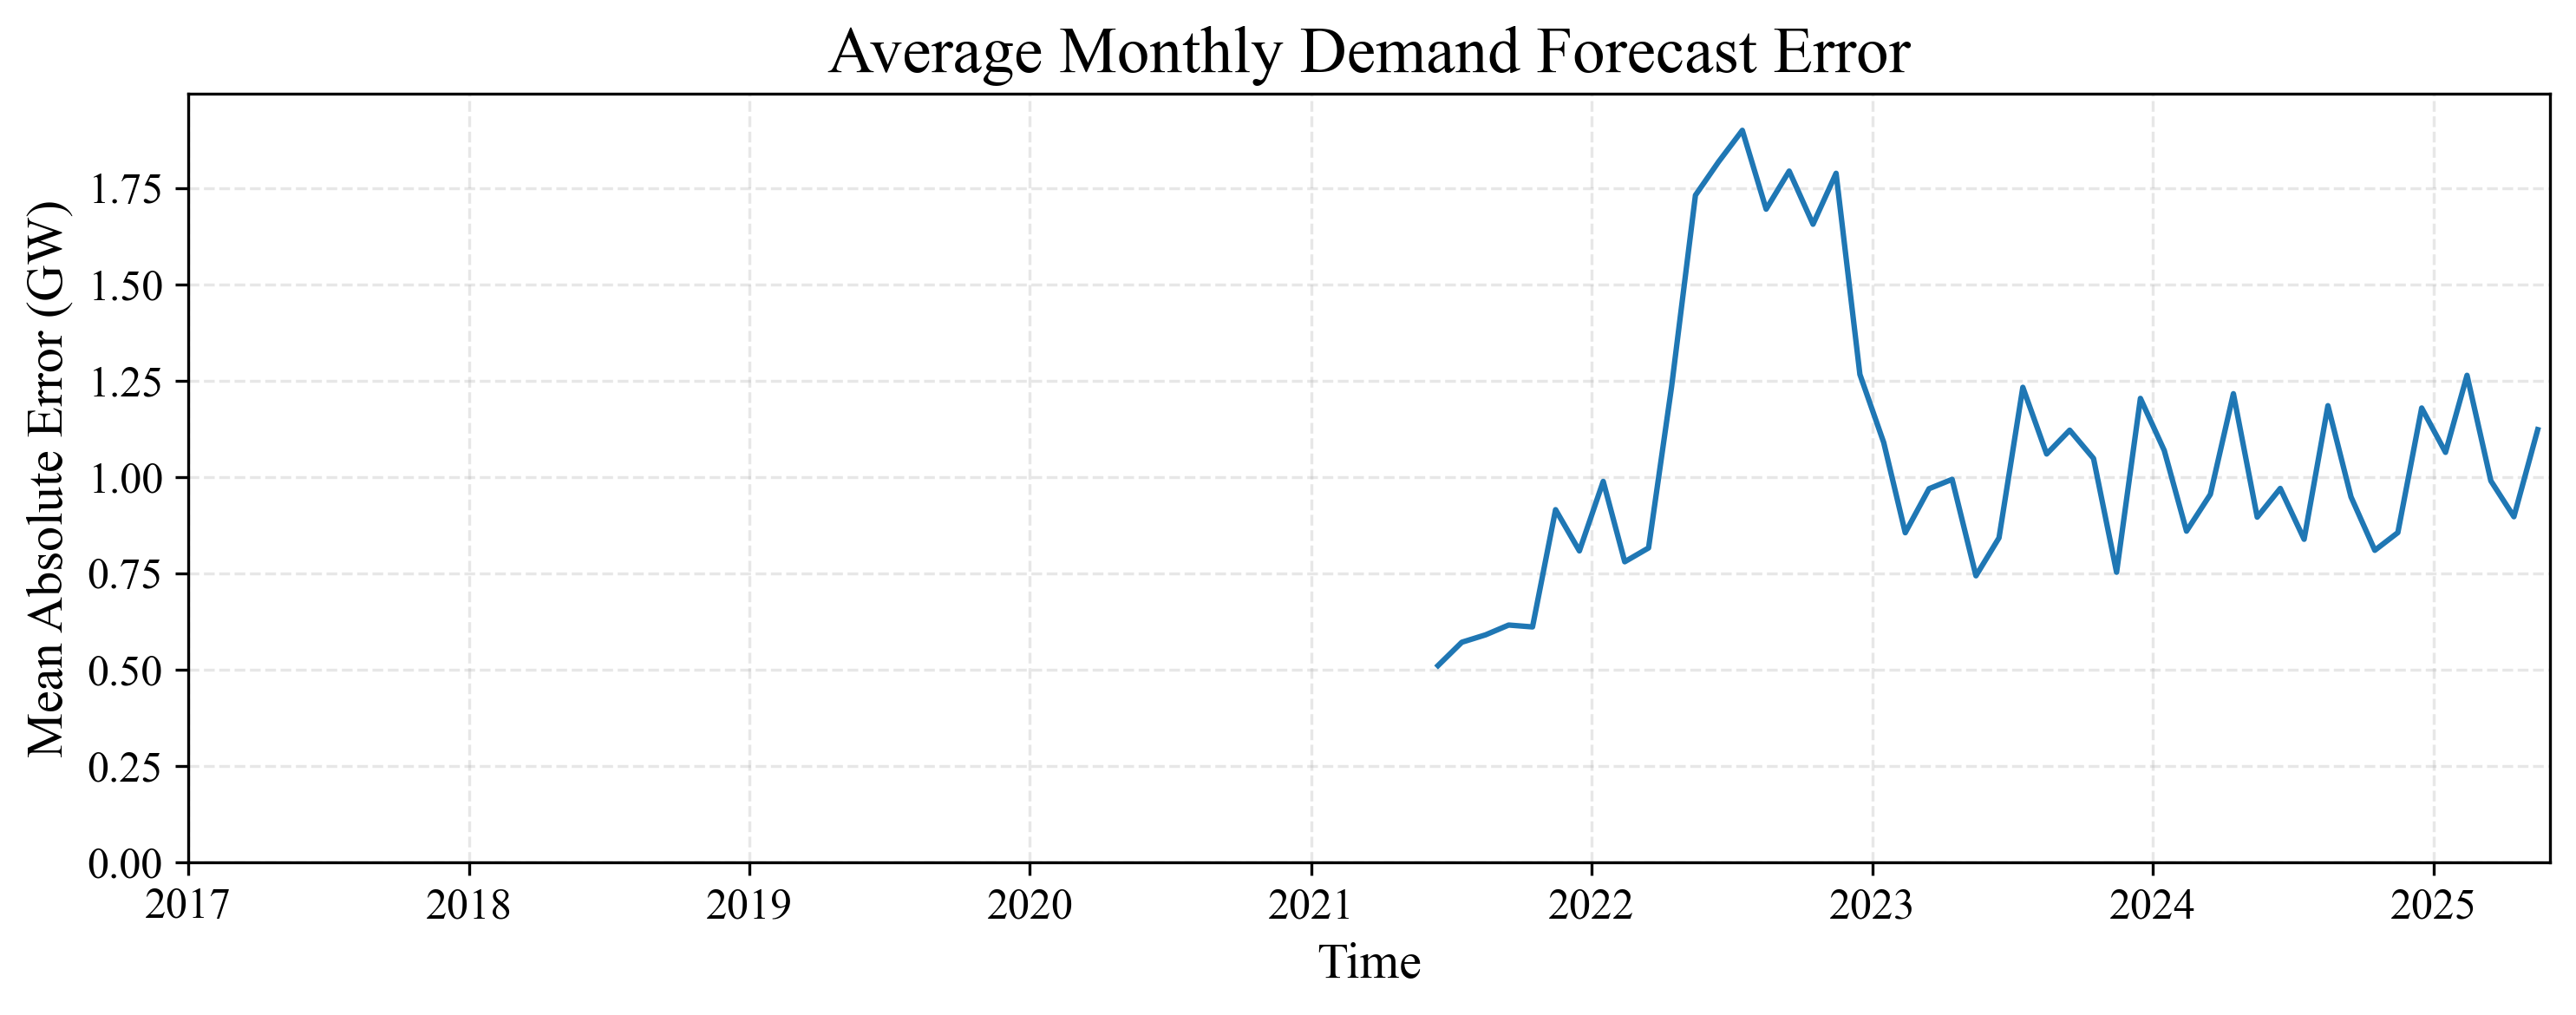

In [ ]:
demand_error_abs = demand_error.abs()

# Resample and shift timestamps to month centres
monthly_demand_error  = demand_error_abs.resample("ME").mean().shift(freq='-15D')

# 2) Demand forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(demand_error.index, demand_error.values, color='tab:blue', linewidth=0.75)
plt.title("Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(demand_error.index.min(), demand_error.index.max())
plt.ylim(demand_error.min() * 1.05, demand_error.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_demand_error.index,  monthly_demand_error.values)
plt.title("Average Monthly Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(demand_error.index.min(), demand_error.index.max())
plt.ylim(0, monthly_demand_error.max() * 1.05)
plt.tight_layout()
plt.show()


### Inter Delta

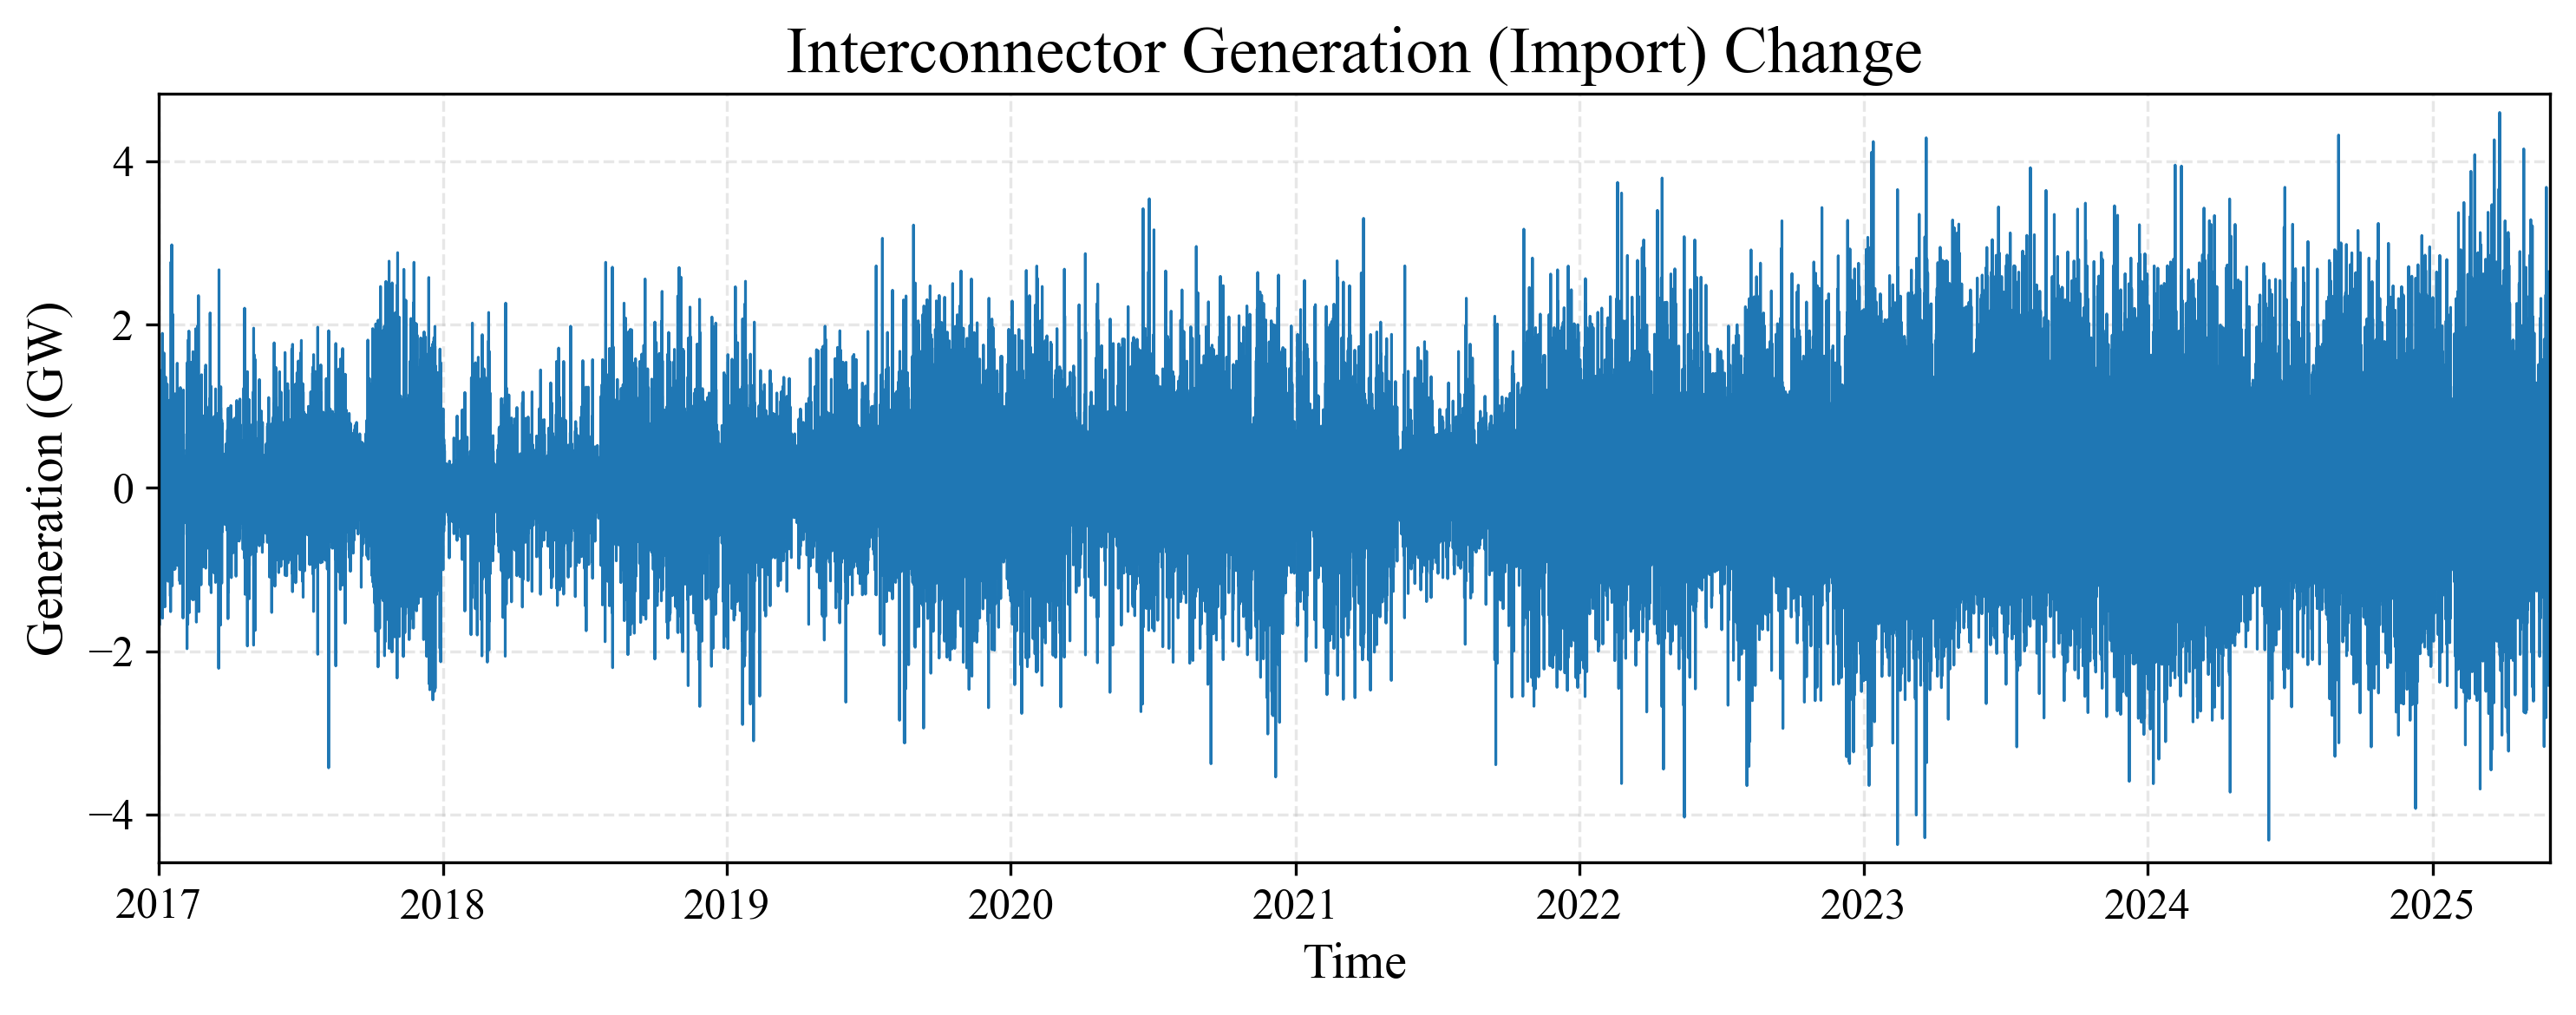

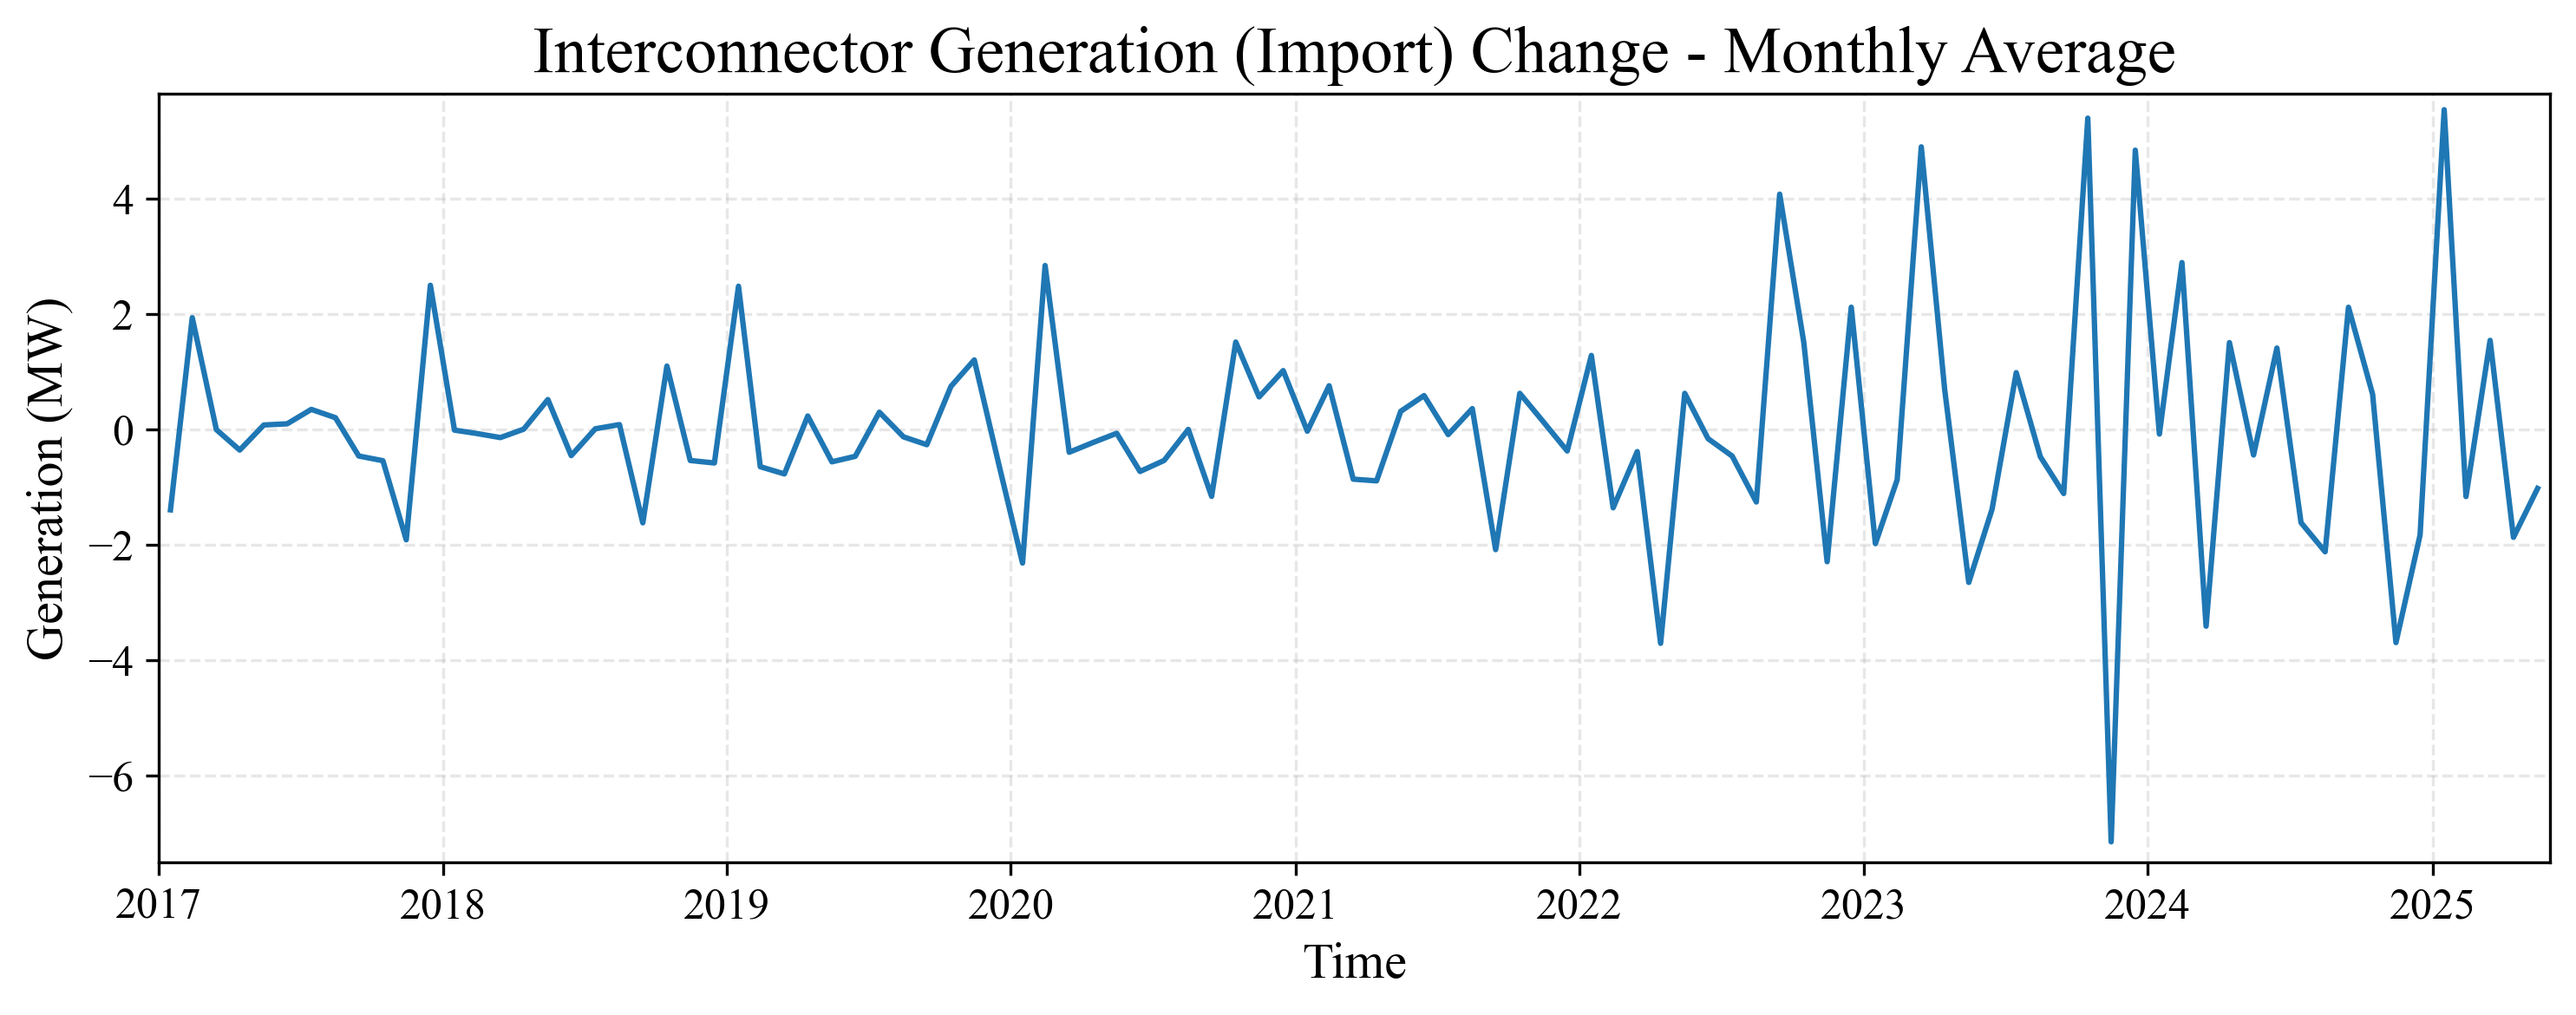

In [5]:
monthly_inter_delta = inter_delta.resample("ME").mean().shift(freq='-15D') * 1_000

plt.figure(figsize=(10, 4))
plt.plot(inter_delta.index,  inter_delta.values, color='tab:blue', linewidth=0.75)
plt.title("Interconnector Generation (Import) Change")
plt.xlabel("Time")
plt.ylabel("Generation (GW)")
plt.xlim(inter_delta.index.min(), inter_delta.index.max())
plt.ylim(inter_delta.min() * 1.05, inter_delta.max() * 1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(monthly_inter_delta.index,  monthly_inter_delta.values, color='tab:blue')
plt.title("Interconnector Generation (Import) Change - Monthly Average")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.xlim(inter_delta.index.min(), inter_delta.index.max())
plt.ylim(monthly_inter_delta.min() * 1.05, monthly_inter_delta.max() * 1.05)
plt.tight_layout()
plt.show()

### De-Rated Margin

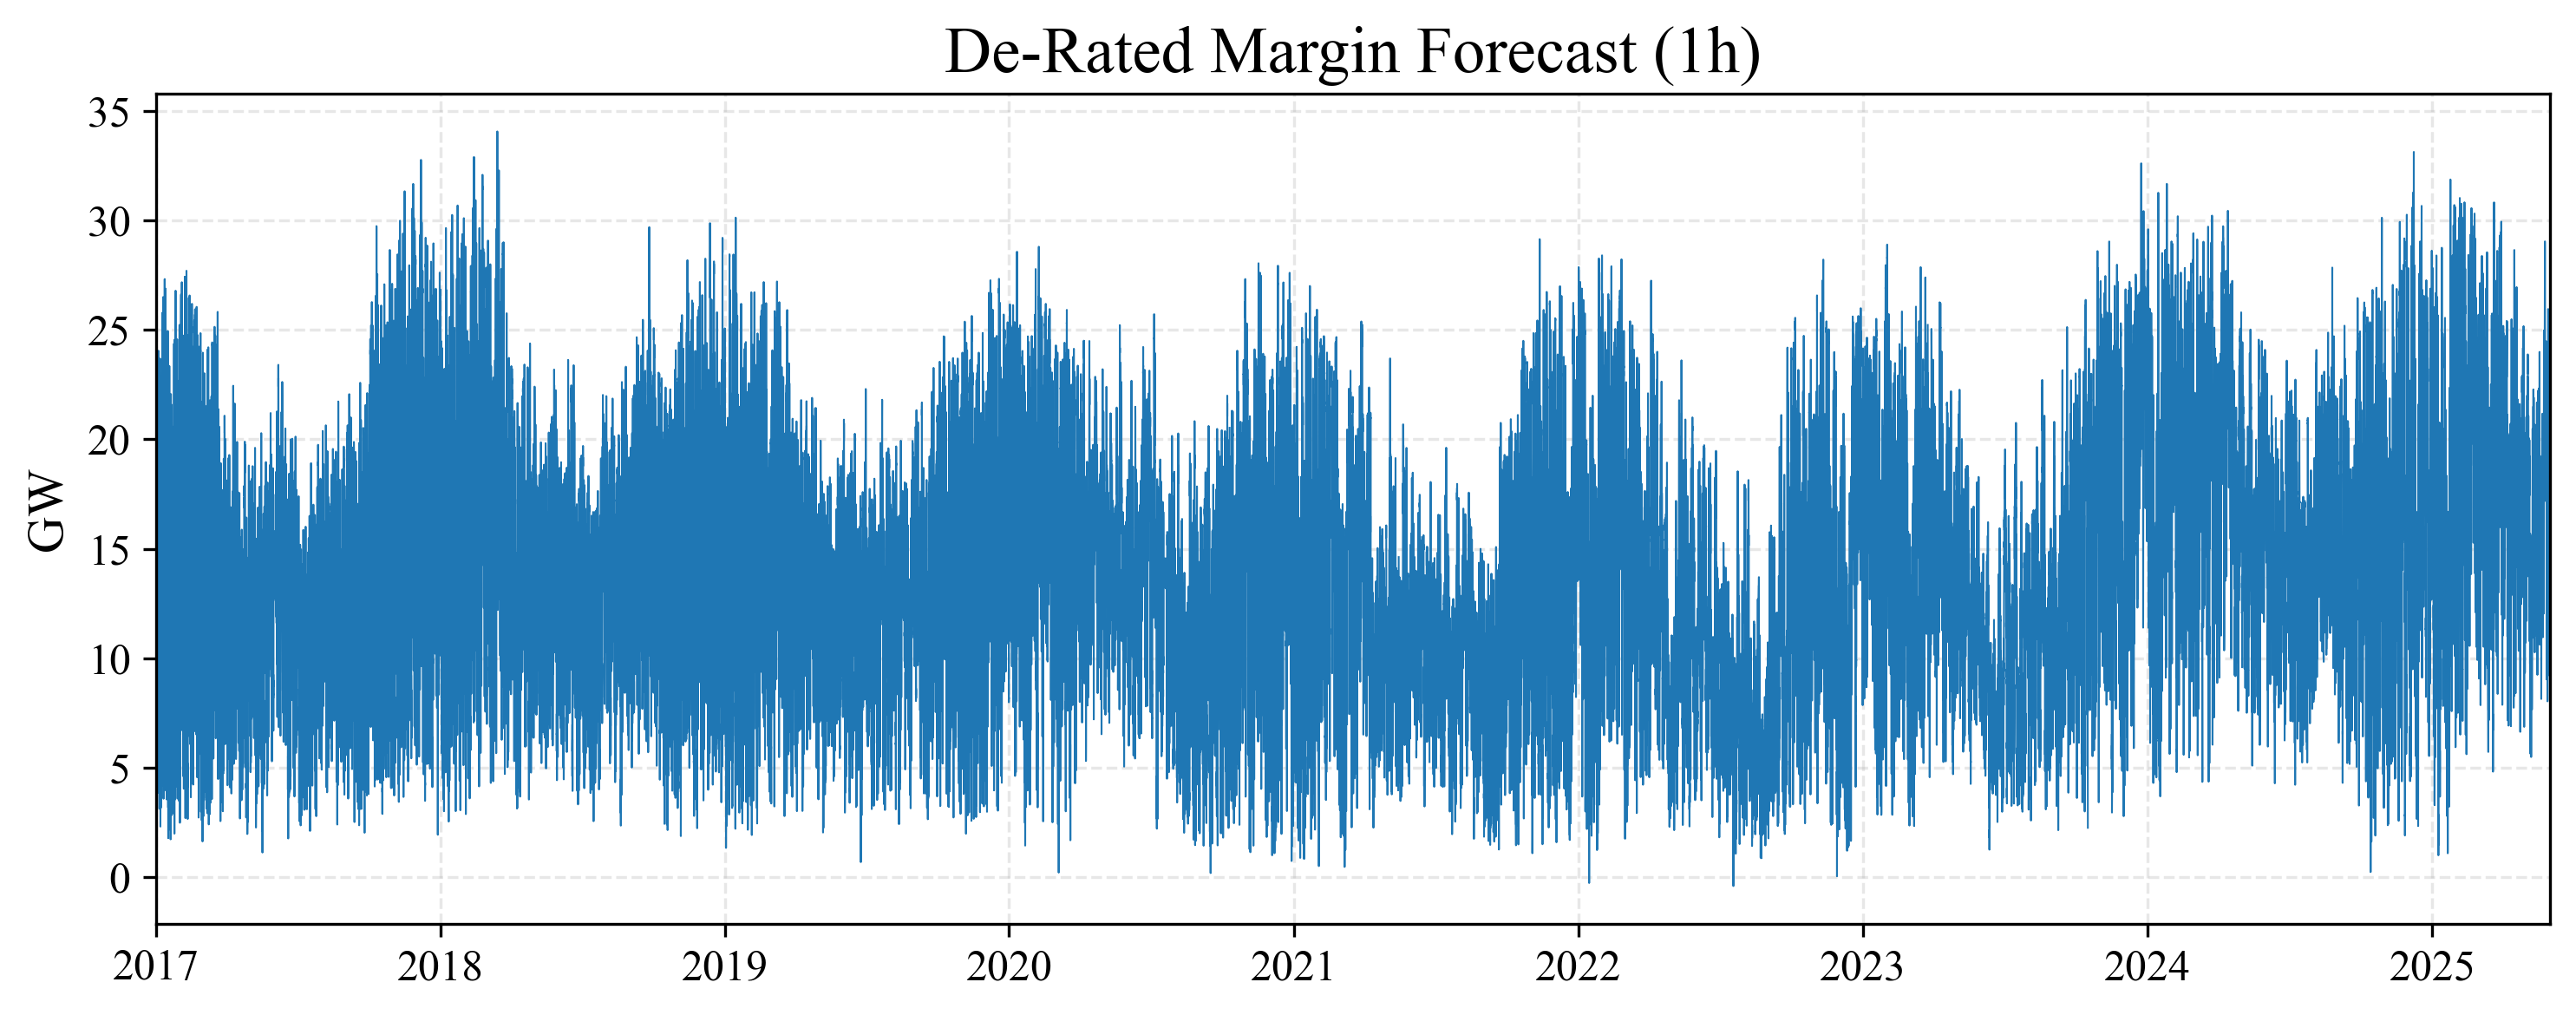

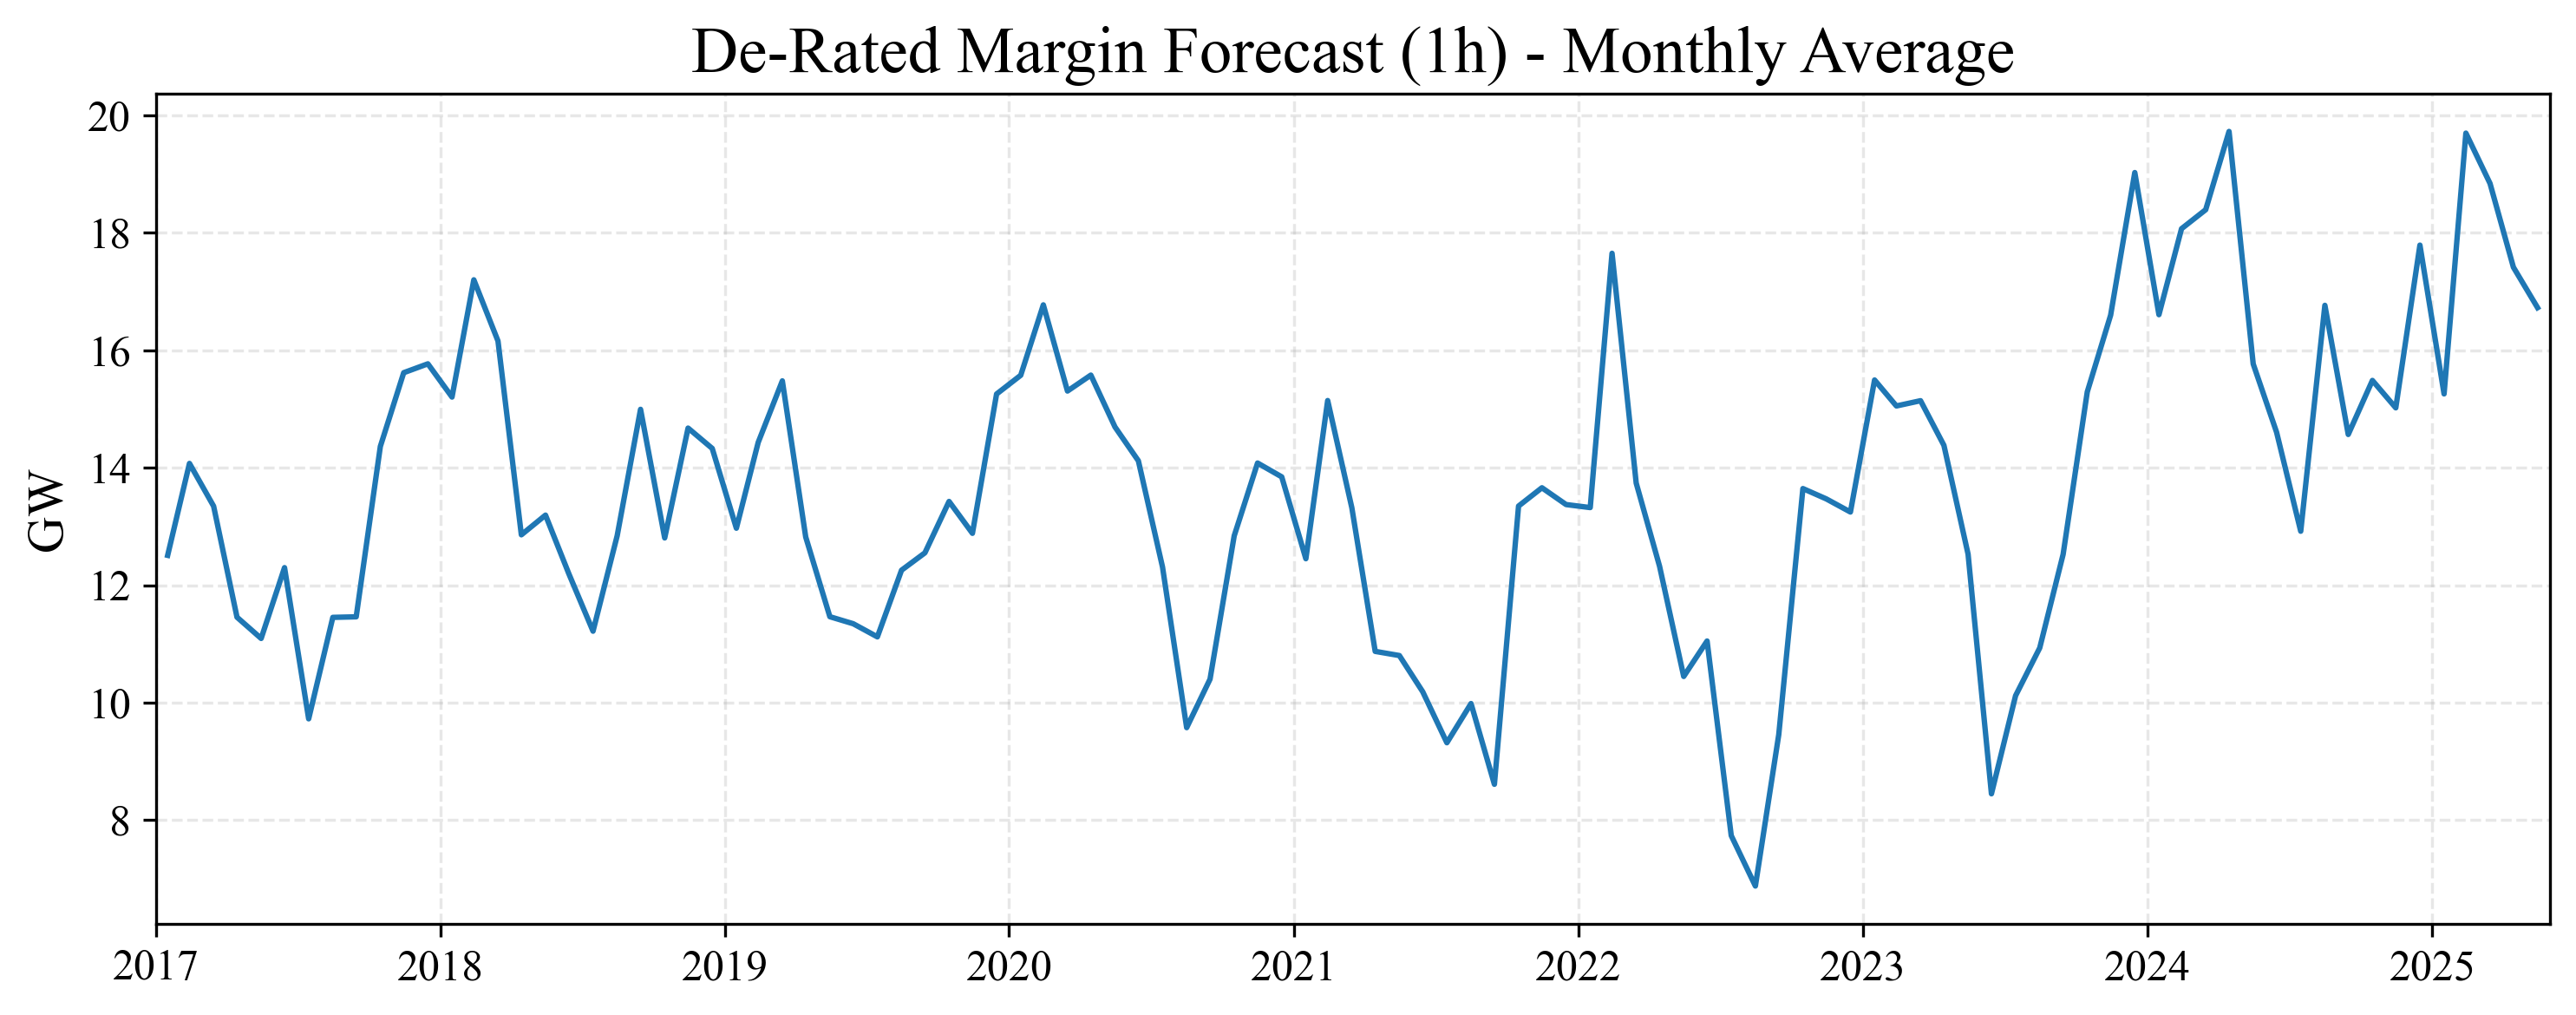

In [6]:
drm_monthly = drm_1h.resample("ME").mean().shift(freq='-15D')

plt.figure(figsize=(10, 4))
plt.plot(drm_1h.index,  drm_1h.values, color='tab:blue', linewidth=0.5)
plt.title("De-Rated Margin Forecast (1h)")
plt.ylabel("GW")
plt.xlim(drm_1h.index.min(), drm_1h.index.max())
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(drm_monthly.index,  drm_monthly.values, color='tab:blue')
plt.title("De-Rated Margin Forecast (1h) - Monthly Average")
plt.ylabel("GW")
plt.xlim(drm_1h.index.min(), drm_1h.index.max())
plt.tight_layout()
plt.show()


### Z-Score

In [7]:
from ipywidgets import VBox

checkboxes = [Checkbox(value=False, description=col) for col in df_z.columns]

def plot_selected(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    lines = []
    labels = []

    for name, checked in kwargs.items():
        if checked:
            # Plot with thin line but store thick legend handle
            line, = ax.plot(df_z.index, df_z[name], label=name, linewidth=0.5, alpha=0.8)
            # Create custom legend handle with thicker line
            legend_line = Line2D(
                [0], [0],
                color=line.get_color(),
                linewidth=2.5,
                label=name
            )
            lines.append(legend_line)
            labels.append(name)

    ax.set_xlabel("Time")
    ax.set_ylabel("Z-score")
    ax.set_xlim(df_z.index.min(), df_z.index.max())

    if lines:
        ax.legend(handles=lines, labels=labels, loc="upper left", ncol=2)

    plt.tight_layout()
    plt.show()

cb_dict = {cb.description: cb for cb in checkboxes}
output = interactive_output(plot_selected, cb_dict)

half = len(checkboxes) // 2 + len(checkboxes) % 2
row1 = HBox(checkboxes[:half])
row2 = HBox(checkboxes[half:])

display(VBox([row1, row2]), output)


Output()

In [ ]:
from ipywidgets import HBox, Checkbox, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Create checkboxes for each column
checkboxes = [Checkbox(value=False, description=col) for col in df_z.columns]

# 2) Create a dictionary for checkbox widgets
cb_dict = {cb.description: cb for cb in checkboxes}

# 3) Define plotting function
def plot_bell_curves(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    added_any = False

    for i, col in enumerate(df_z.columns):
        if kwargs.get(col, False):
            data = df_z[col].dropna()
            ax.hist(
                data,
                bins=100,
                density=True,
                alpha=0.4,
                label=col,
                linewidth=0.75,
                histtype="stepfilled",
                color=tab_colours[i % len(tab_colours)]
            )
            added_any = True

    ax.set_xlabel("Z-score")
    ax.set_ylabel("Density")
    ax.set_title("Z-Score Distributions")

    if added_any:
        ax.legend()

    plt.tight_layout()
    plt.show()

# 4) Link checkbox values to plotting function
output = interactive_output(plot_bell_curves, {k: v for k, v in cb_dict.items()})

half = len(checkboxes) // 2 + len(checkboxes) % 2
row1 = HBox(checkboxes[:half])
row2 = HBox(checkboxes[half:])

display(VBox([row1, row2]), output)

Output()

In [ ]:
day, week, month = 48, 336, 1460
volatility_series = {
    "Imbalance Price": df_all["Imbalance Price"],
    "1-day Rolling σ":   df_all["Imbalance Price"].rolling(window=day).std(),
    "1-week Rolling σ":  df_all["Imbalance Price"].rolling(window=week).std(),
    "1-month Rolling σ": df_all["Imbalance Price"].rolling(window=month).std(),
}

tab_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

checkboxes = [Checkbox(value=(k == "1-week Rolling σ"), description=k)
              for k in volatility_series]
cb_dict = {cb.description: cb for cb in checkboxes}

def plot_vol(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    lines = []
    for i, name in enumerate(volatility_series):
        if kwargs.get(name, False):
            data  = volatility_series[name]
            colour = tab_colours[i % len(tab_colours)]
            line, = ax.plot(data.index, data,
                            label=name,
                            linewidth=0.75,
                            alpha=0.75,
                            color=colour)
            lines.append(Line2D([0], [0], color=colour, linewidth=2.5, label=name))

    ax.set_xlabel("Time")
    ax.set_ylabel("Price Volatility (£/MWh)")
    ax.set_xlim(df_all.index.min(), df_all.index.max())
    if lines:
        ax.legend(handles=lines, loc="upper left")
    plt.tight_layout()
    plt.show()

output = interactive_output(plot_vol, cb_dict)

display(HBox(checkboxes), output)

Output()

### Correlation Matrix

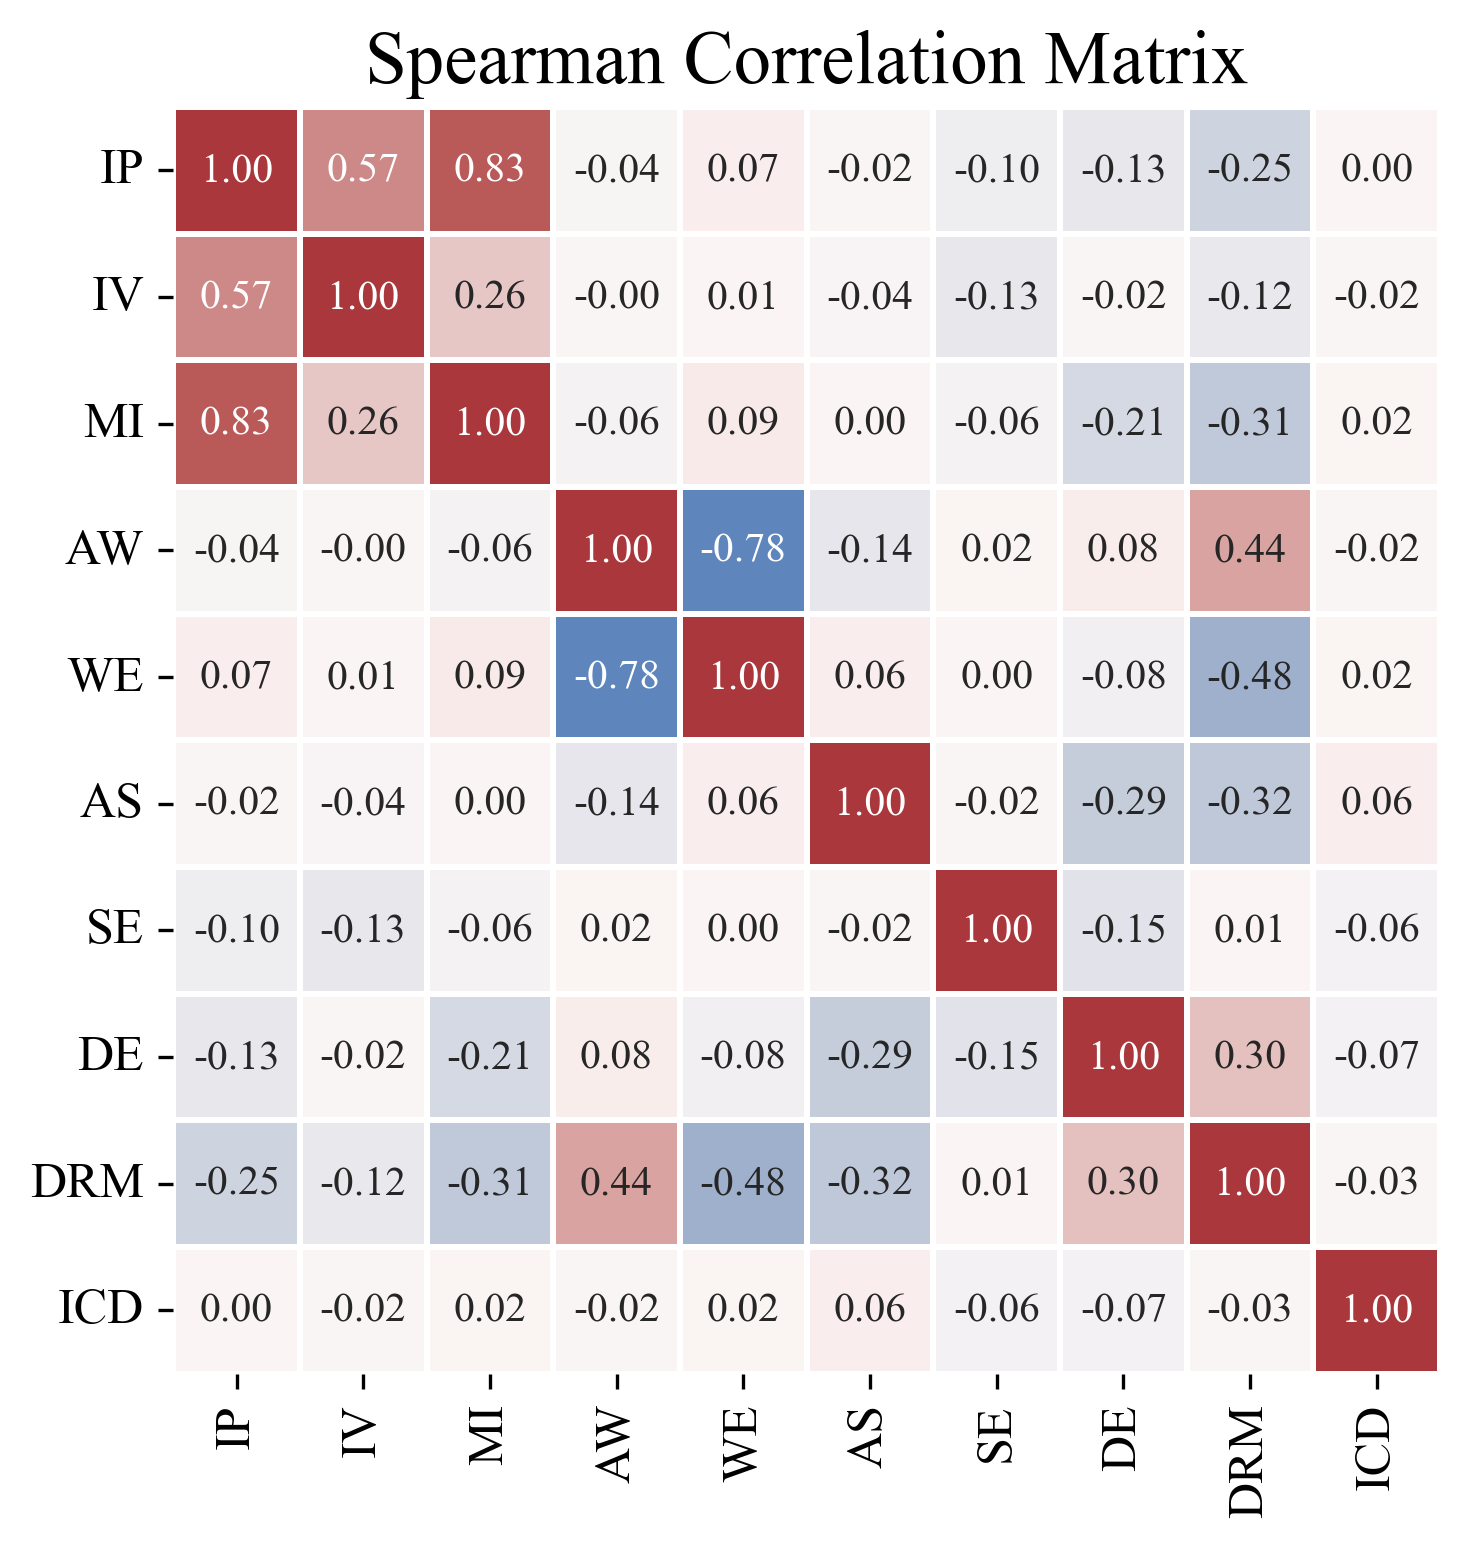

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_all.rename(columns={
    "Imbalance Price":      "IP",
    "Imbalance Volume":     "IV",
    "Market Index":         "MI",
    "Actual Wind":          "AW",
    "Actual Solar":         "AS",
    "Wind Error":           "WE",
    "Solar Error":          "SE",
    "Demand Error":         "DE",
    "De-Rated Margin (1h)": "DRM",
    "Inter Delta":          "ICD"
})

corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(5, 6), dpi=300)
plt.title("Spearman Correlation Matrix")
sns.heatmap(
    corr_matrix,
    annot=True,
    square=True,
    fmt=".2f",
    cmap="vlag",
    cbar=False,
    center=0,
    vmax=1,
    vmin=-1,
    linewidths=1,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()


### Data and System Length

In [ ]:
import numpy as np

# List of columns and labels
cols = df_all.columns.tolist()

# Helper to calculate stats
def get_stats(df, label):
    stats = df[cols].agg(["mean", "std", "min", "max"]).T.reset_index()
    stats.insert(0, "Condition", label)
    return stats.rename(columns={"index": "Variable", "std": "stddev"})

# Calculate stats for all, short, and long conditions
all_stats   = get_stats(df_all, "All")
short_stats = get_stats(df_all[df_all["Imbalance Volume"] > 0], "Short (NIV > 0)")
long_stats  = get_stats(df_all[df_all["Imbalance Volume"] < 0], "Long (NIV < 0)")

# Combine and preserve float types by inserting np.nan instead of ""
combined_stats = pd.concat([all_stats, short_stats, long_stats])

output_rows = []
for var in cols:
    chunk = combined_stats[combined_stats["Variable"] == var]
    output_rows.append(chunk)
    output_rows.append(
        pd.DataFrame([{
            "Condition": "", "Variable": "",
            "mean": np.nan, "stddev": np.nan,
            "min": np.nan, "max": np.nan
        }])
    )

final_table = pd.concat(output_rows, ignore_index=True)
final_table.round(2)


Condition              Variable     mean   stddev       min      max
0               All       Imbalance Price    82.64    97.38   -185.33  4037.80
1   Short (NIV > 0)       Imbalance Price   120.97   121.90    -30.99  4037.80
2    Long (NIV < 0)       Imbalance Price    48.01    45.80   -185.33   576.68
3                                              NaN      NaN       NaN      NaN
4               All      Imbalance Volume   -25.94   332.32  -2283.46  2477.17
5   Short (NIV > 0)      Imbalance Volume   235.71   213.79      0.00  2477.17
6    Long (NIV < 0)      Imbalance Volume  -262.41   226.18  -2283.46    -0.00
7                                              NaN      NaN       NaN      NaN
8               All          Market Index    82.59    73.20    -77.29  1983.66
9   Short (NIV > 0)          Market Index    95.08    80.38    -32.93  1983.66
10   Long (NIV < 0)          Market Index    71.30    63.98    -77.29  1795.98
11                                             NaN      NaN       NaN      NaN
12              All           Actual Wind     5.71     4.09      0.00    21.87
13  Short (NIV > 0)           Actual Wind     5.73     4.07      0.00    21.60
14   Long (NIV < 0)           Actual Wind     5.69     4.10      0.02    21.87
15                                             NaN      NaN       NaN      NaN
16              All            Wind Error -3745.16  2449.14 -12183.53    -4.26
17  Short (NIV > 0)            Wind Error -3745.42  2438.35 -12183.53    -4.28
18   Long (NIV < 0)            Wind Error -3745.17  2458.81 -12179.56    -4.26
19                                             NaN      NaN       NaN      NaN
20              All          Actual Solar     1.32     2.06      0.00    12.53
21  Short (NIV > 0)          Actual Solar     1.11     1.79      0.00    12.53
22   Long (NIV < 0)          Actual Solar     1.50     2.26      0.00    12.48
23                                             NaN      NaN       NaN      NaN
24              All           Solar Error    -0.04     0.39     -6.10     3.13
25  Short (NIV > 0)           Solar Error    -0.10     0.38     -4.99     3.13
26   Long (NIV < 0)           Solar Error     0.01     0.39     -6.10     3.03
27                                             NaN      NaN       NaN      NaN
28              All          Demand Error     0.45     1.52     -5.92     8.07
29  Short (NIV > 0)          Demand Error     0.38     1.42     -5.92     7.63
30   Long (NIV < 0)          Demand Error     0.53     1.61     -5.80     8.07
31                                             NaN      NaN       NaN      NaN
32              All  De-Rated Margin (1h)    13.60     5.80     -0.40    34.07
33  Short (NIV > 0)  De-Rated Margin (1h)    12.95     5.67     -0.31    33.04
34   Long (NIV < 0)  De-Rated Margin (1h)    14.20     5.86     -0.40    34.07
35                                             NaN      NaN       NaN      NaN
36              All           Inter Delta    -0.00     0.47     -4.37     4.60
37  Short (NIV > 0)           Inter Delta    -0.01     0.47     -4.37     4.32
38   Long (NIV < 0)           Inter Delta     0.01     0.46     -4.31     4.60
39                                             NaN      NaN       NaN      NaN

### Stats

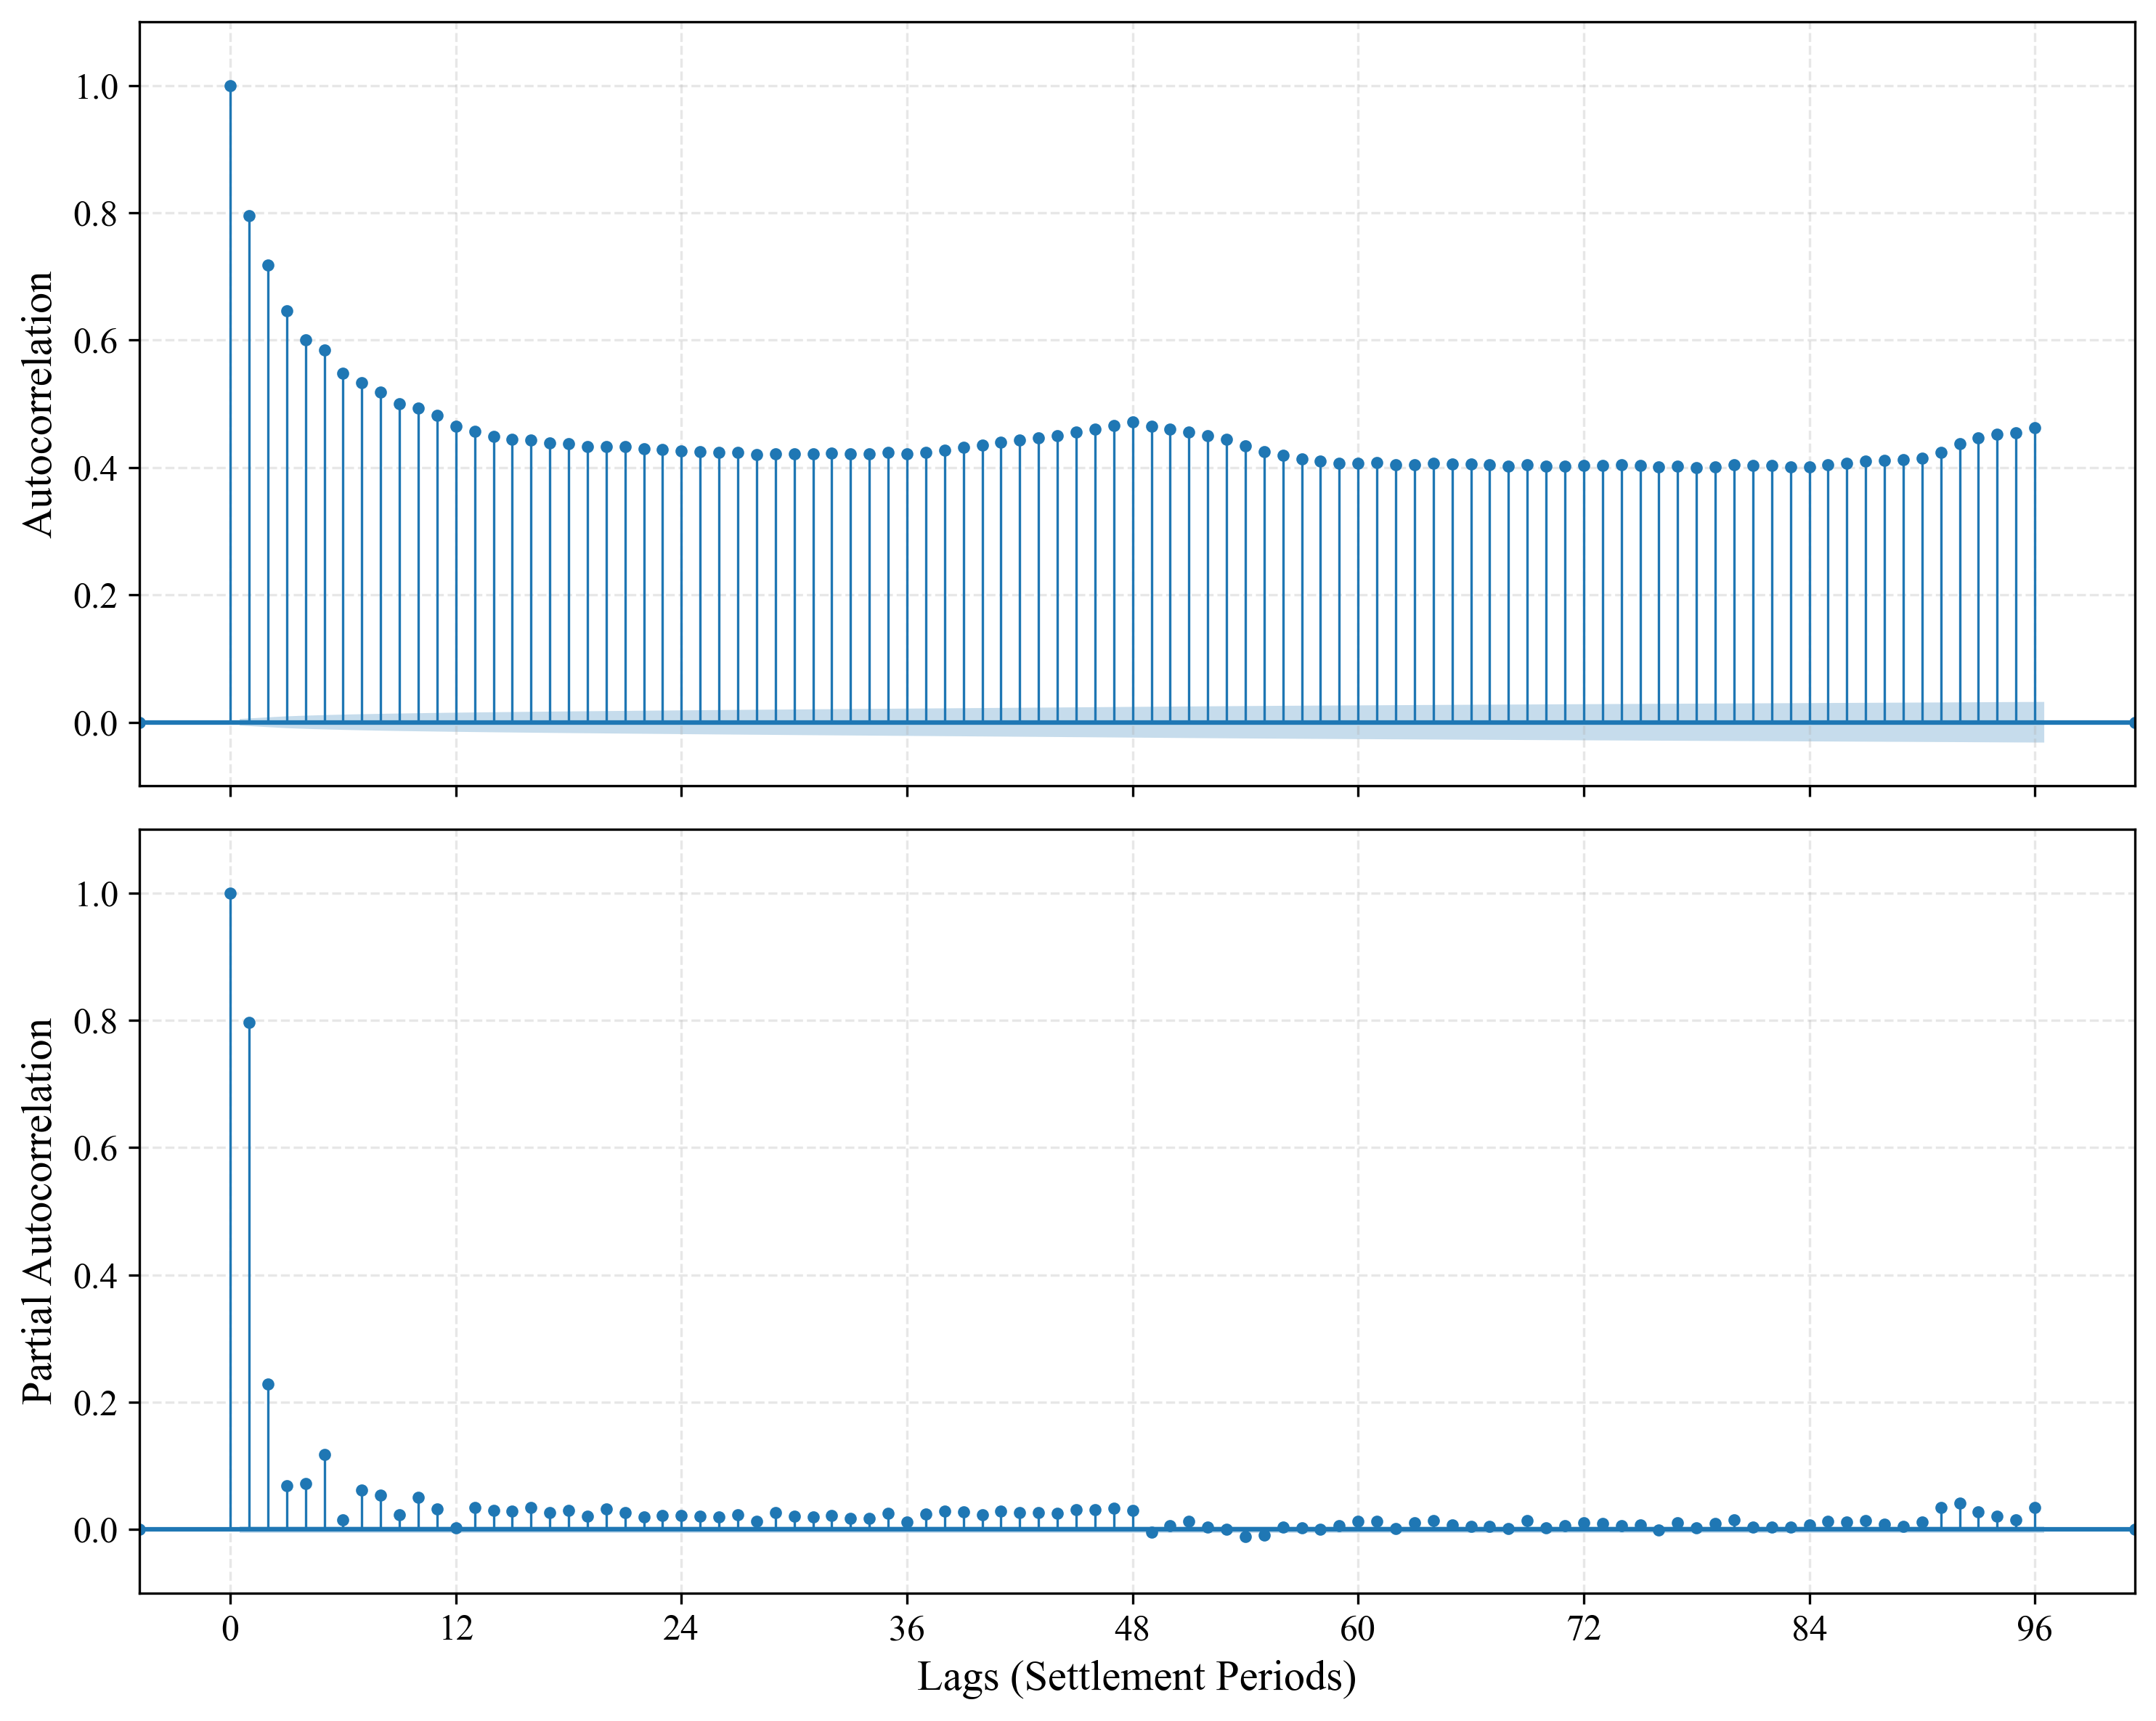

In [9]:
df_all_crop = df_all.loc["2017-01-01":"2025-05-31"]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# ACF plot
plot_acf(
    df_all_crop["Imbalance Price"],
    lags=96,
    ax=axes[0],
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
    auto_ylims=True
)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_xticks(np.arange(0, 97, 12))
axes[0].tick_params(axis='x', labelbottom=False)
axes[0].set_title(None)

# PACF plot
plot_pacf(
    df_all_crop["Imbalance Price"],
    lags=96,
    ax=axes[1],
    method='ywm',
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
    auto_ylims=True
)
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_xticks(np.arange(0, 97, 12))
axes[1].set_xlabel("Lags (Settlement Periods)")
axes[1].set_title(None)

plt.tight_layout()
plt.show()



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import STL
import ipywidgets as widgets
from IPython.display import display

result = STL(df_all['Imbalance Price'], period=48, robust=False, seasonal=23).fit()

months = pd.date_range('2017-01-01', '2024-05-01', freq='MS')
month_options = [(m.strftime('%Y-%m'), m) for m in months]

start_slider = widgets.SelectionSlider(
    options=month_options,
    description='Start month',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)
window_slider = widgets.IntSlider(
    min=1,
    max=12,
    step=1,
    value=12,
    description='Window (months)',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

controls = widgets.VBox(
    [start_slider, window_slider],
    layout=widgets.Layout(width='100%')
)

def plot(start, window):
    end = start + DateOffset(months=window)
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), dpi=300, sharex=True)
    axes[0].plot(df_all['Imbalance Price'].loc[start:end], linewidth=0.5)
    axes[0].set_ylabel('Observed')
    axes[1].plot(result.trend.loc[start:end], linewidth=0.5)
    axes[1].set_ylabel('Trend')
    axes[2].plot(result.seasonal.loc[start:end], linewidth=0.5)
    axes[2].set_ylabel('Seasonal')
    axes[3].plot(result.resid.loc[start:end], linewidth=0.5)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('')
    fig.suptitle('STL Decomposition of Imbalance Price')
    plt.tight_layout()
    plt.show()

out = widgets.interactive_output(plot, {
    'start': start_slider,
    'window': window_slider
})

display(controls, out)


Output()

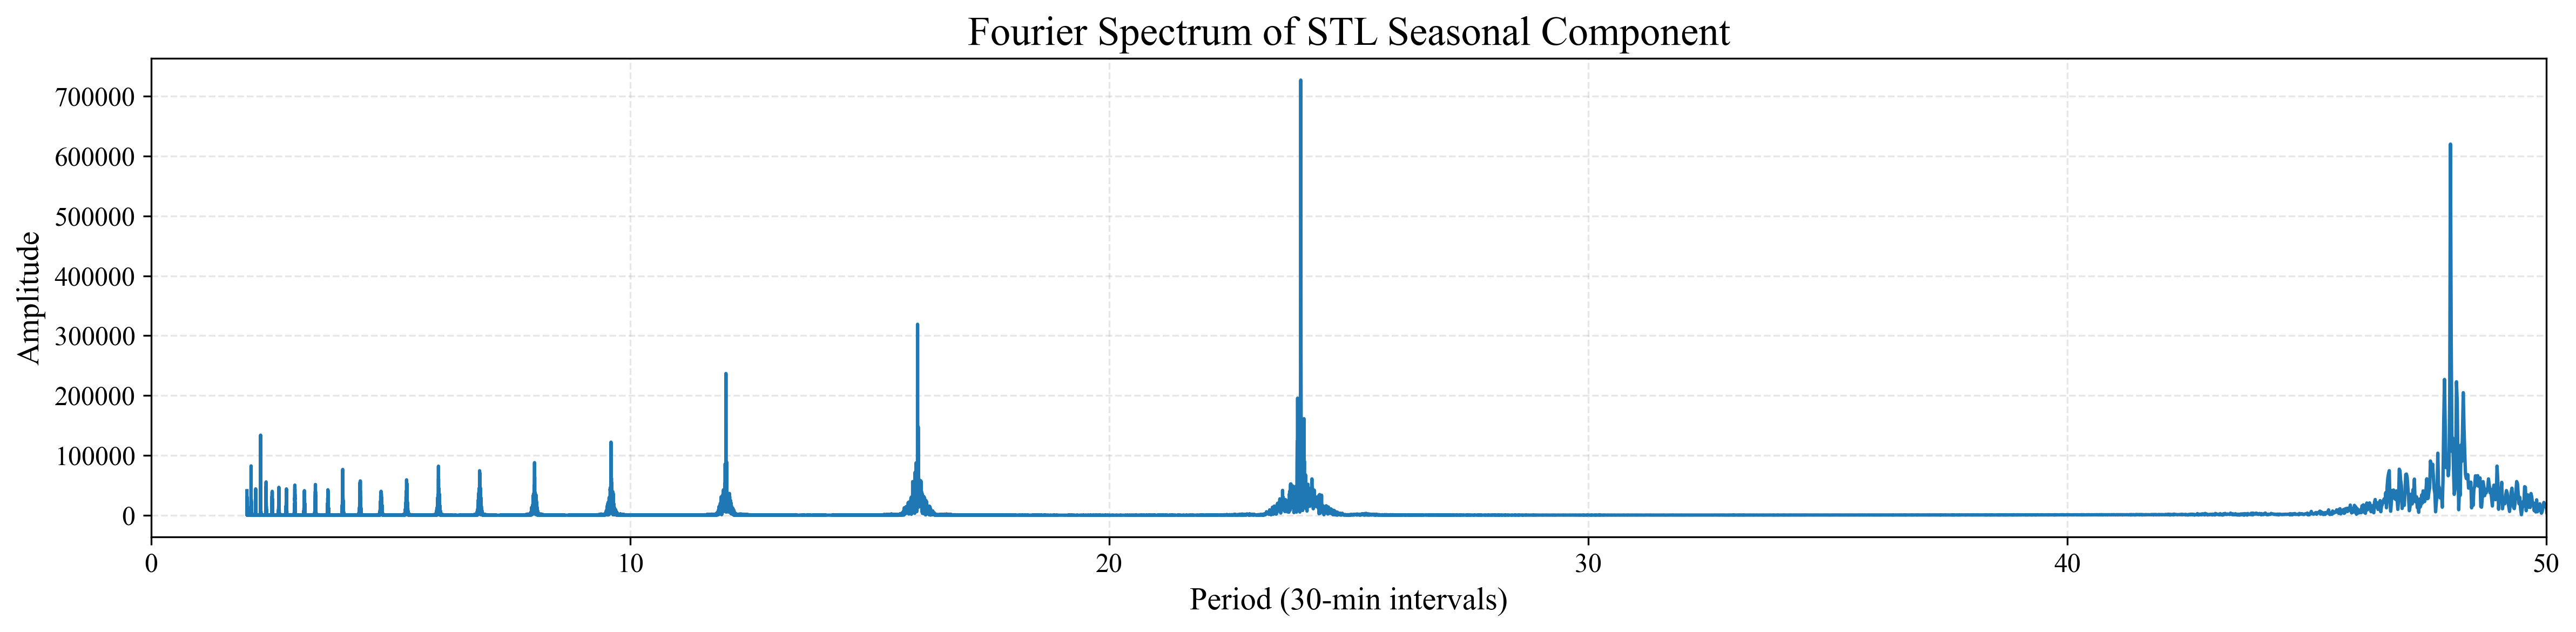

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Perform FFT on the seasonal component
fft = np.fft.fft(result.seasonal)
freqs = np.fft.fftfreq(len(result.seasonal), d=1)
amplitudes = np.abs(fft)

# Use only positive frequencies
half_n = len(result.seasonal) // 2
positive_freqs = freqs[:half_n]
positive_amplitudes = amplitudes[:half_n]

# Convert frequency to period (number of 30-minute intervals)
# Avoid division by zero
nonzero_freqs = positive_freqs[positive_freqs > 0]
periods = 1 / nonzero_freqs
amplitudes_trimmed = positive_amplitudes[positive_freqs > 0]

# Plot amplitude vs period
plt.figure(figsize=(16, 4), dpi=300)
plt.plot(periods, amplitudes_trimmed)
plt.xlabel("Period (30-min intervals)")
plt.xlim(0, 50)
plt.ylabel("Amplitude")
plt.title("Fourier Spectrum of STL Seasonal Component")
plt.grid(True)
plt.tight_layout()
plt.show()


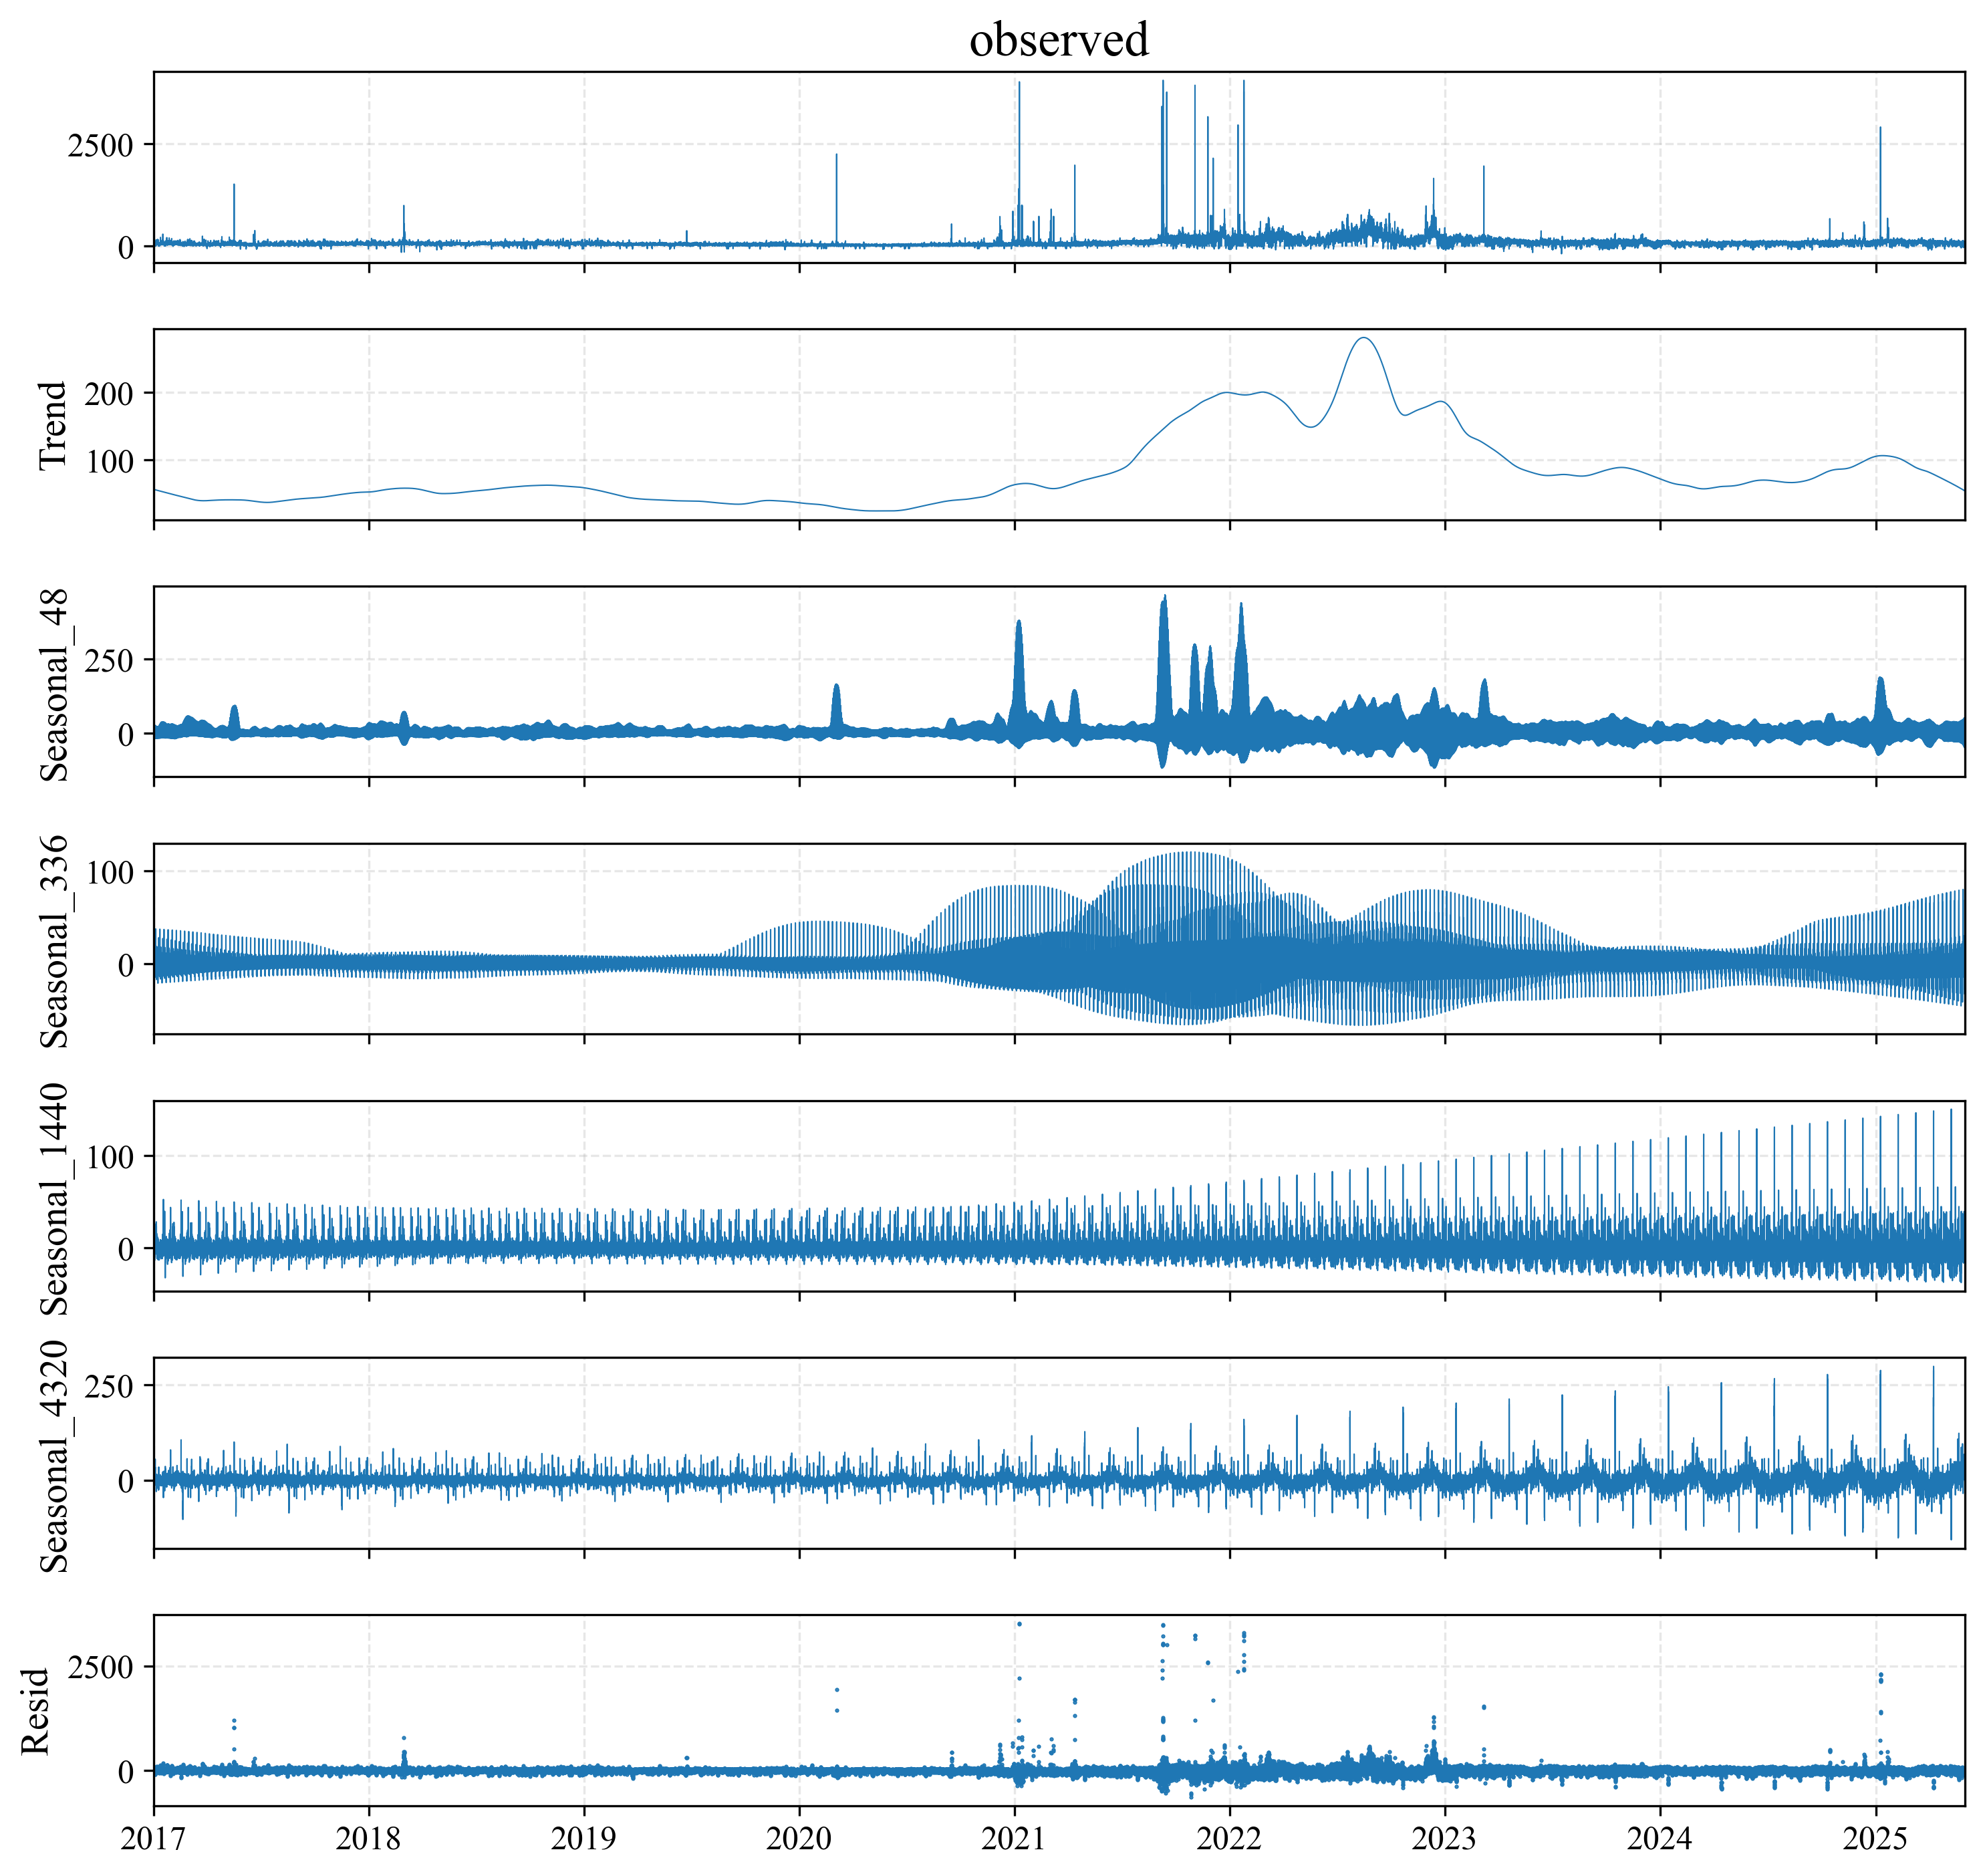

In [ ]:
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(df_all['Imbalance Price'], periods=[48, 336, 1440, 4320], windows=[25, 75, 251, 625])
result = mstl.fit()
fig = result.plot()
fig.set_dpi(300)
fig.set_size_inches(10,10)

for ax in fig.axes:
    for line in ax.lines:
        line.set_linewidth(.5)  # Change this value as needed
        line.set_markersize(.5)  # Optional: for markers

plt.show()


In [5]:
result

## Explaining 2021/2022 Spikes

In [ ]:
df_all_crop = df_all.loc["2021-01-01":"2022-12-31"]

threshold = 750

spikes = df_all_crop[df_all_crop["Imbalance Price"] > threshold]
rest = df_all_crop[df_all_crop["Imbalance Price"] <= threshold]

spikes_label = f"Spikes (>£{threshold})"
rest_label = f"Rest of Data (≤£{threshold})"

### Seasonality

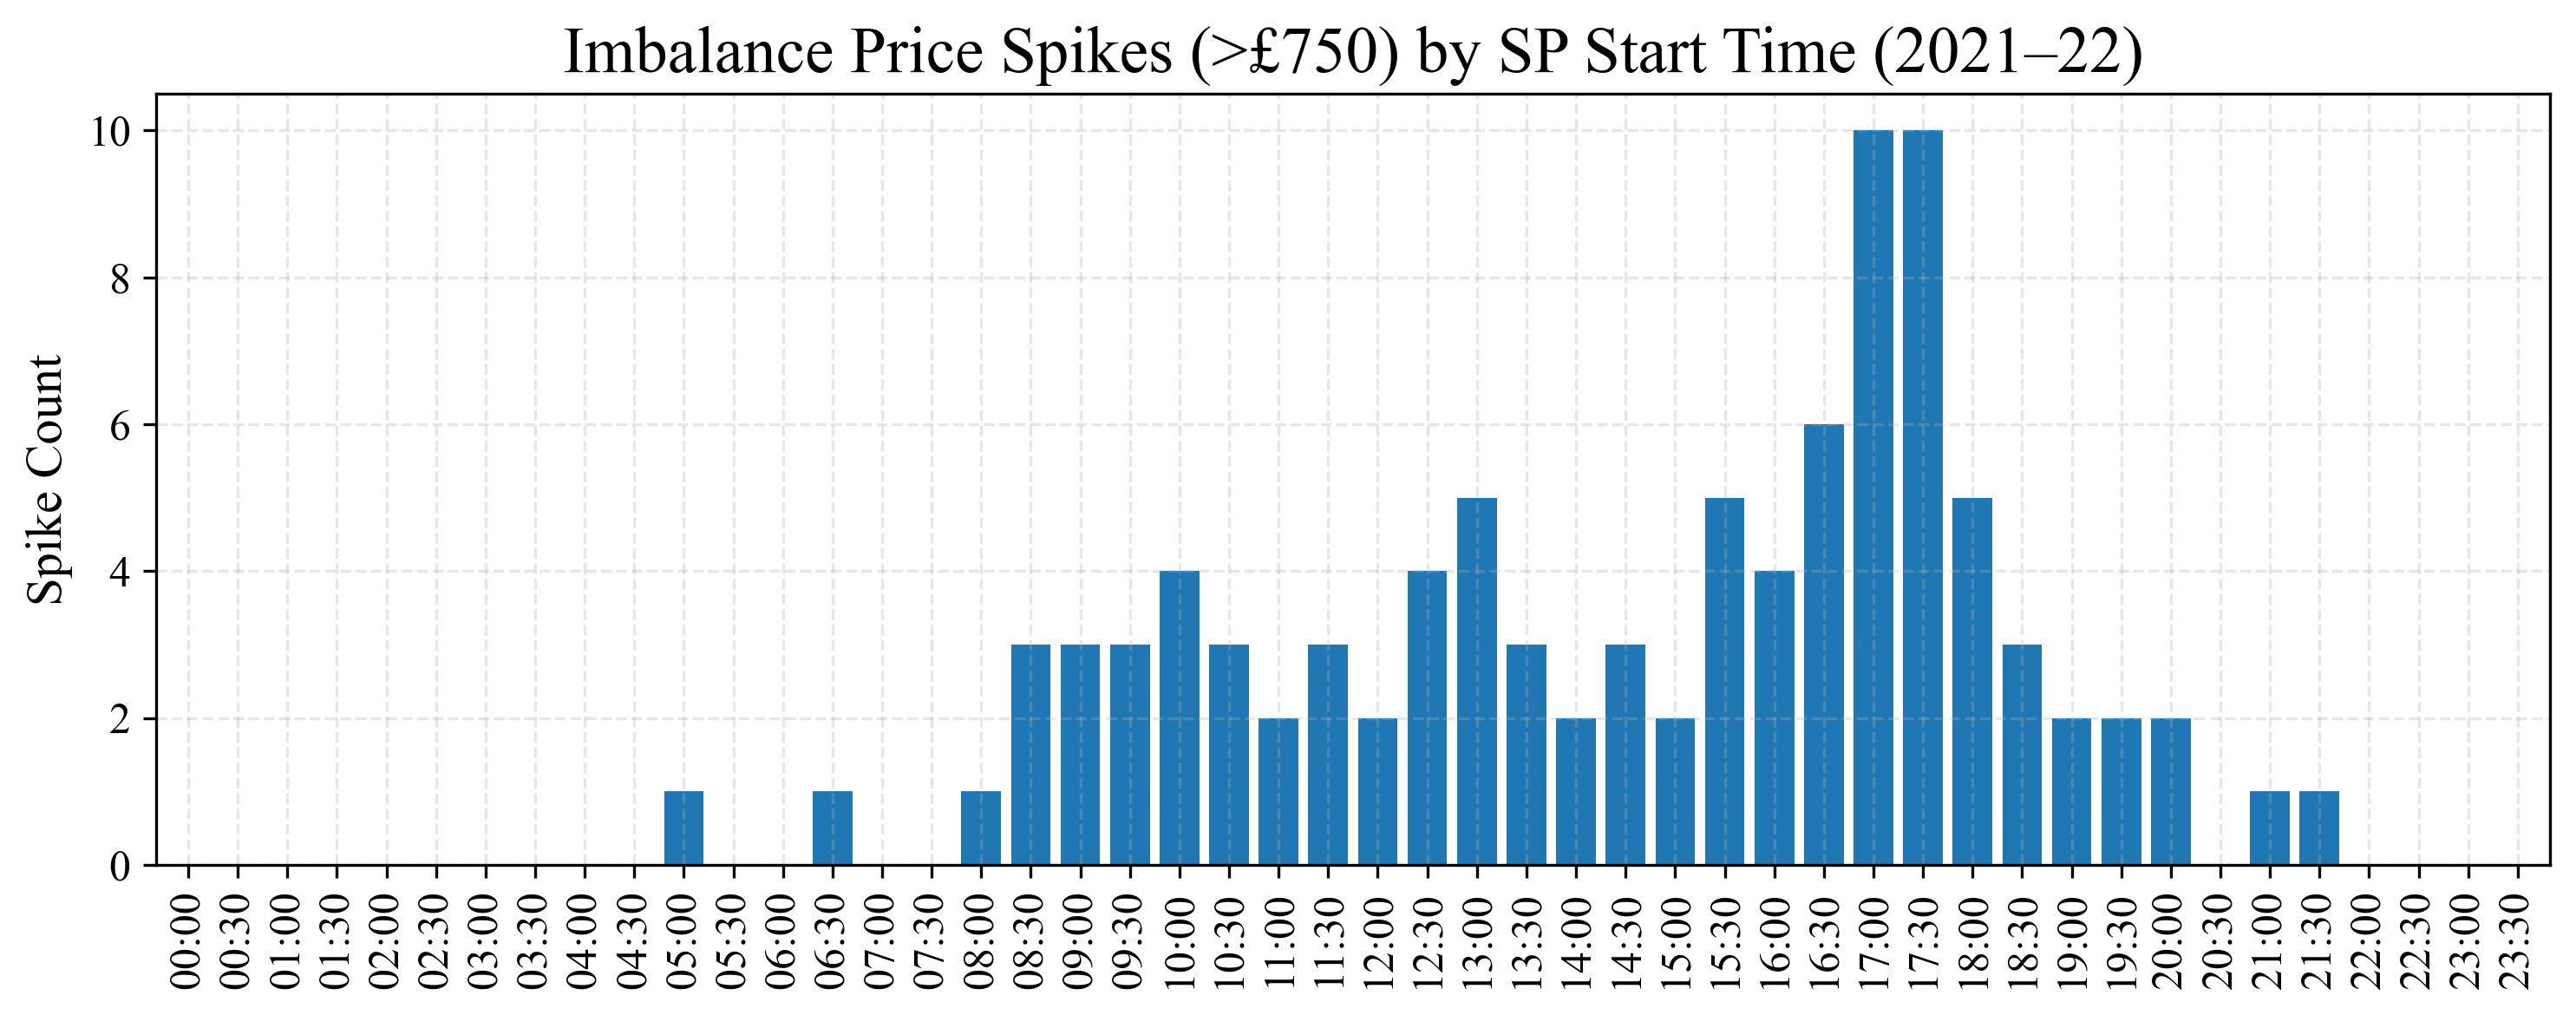

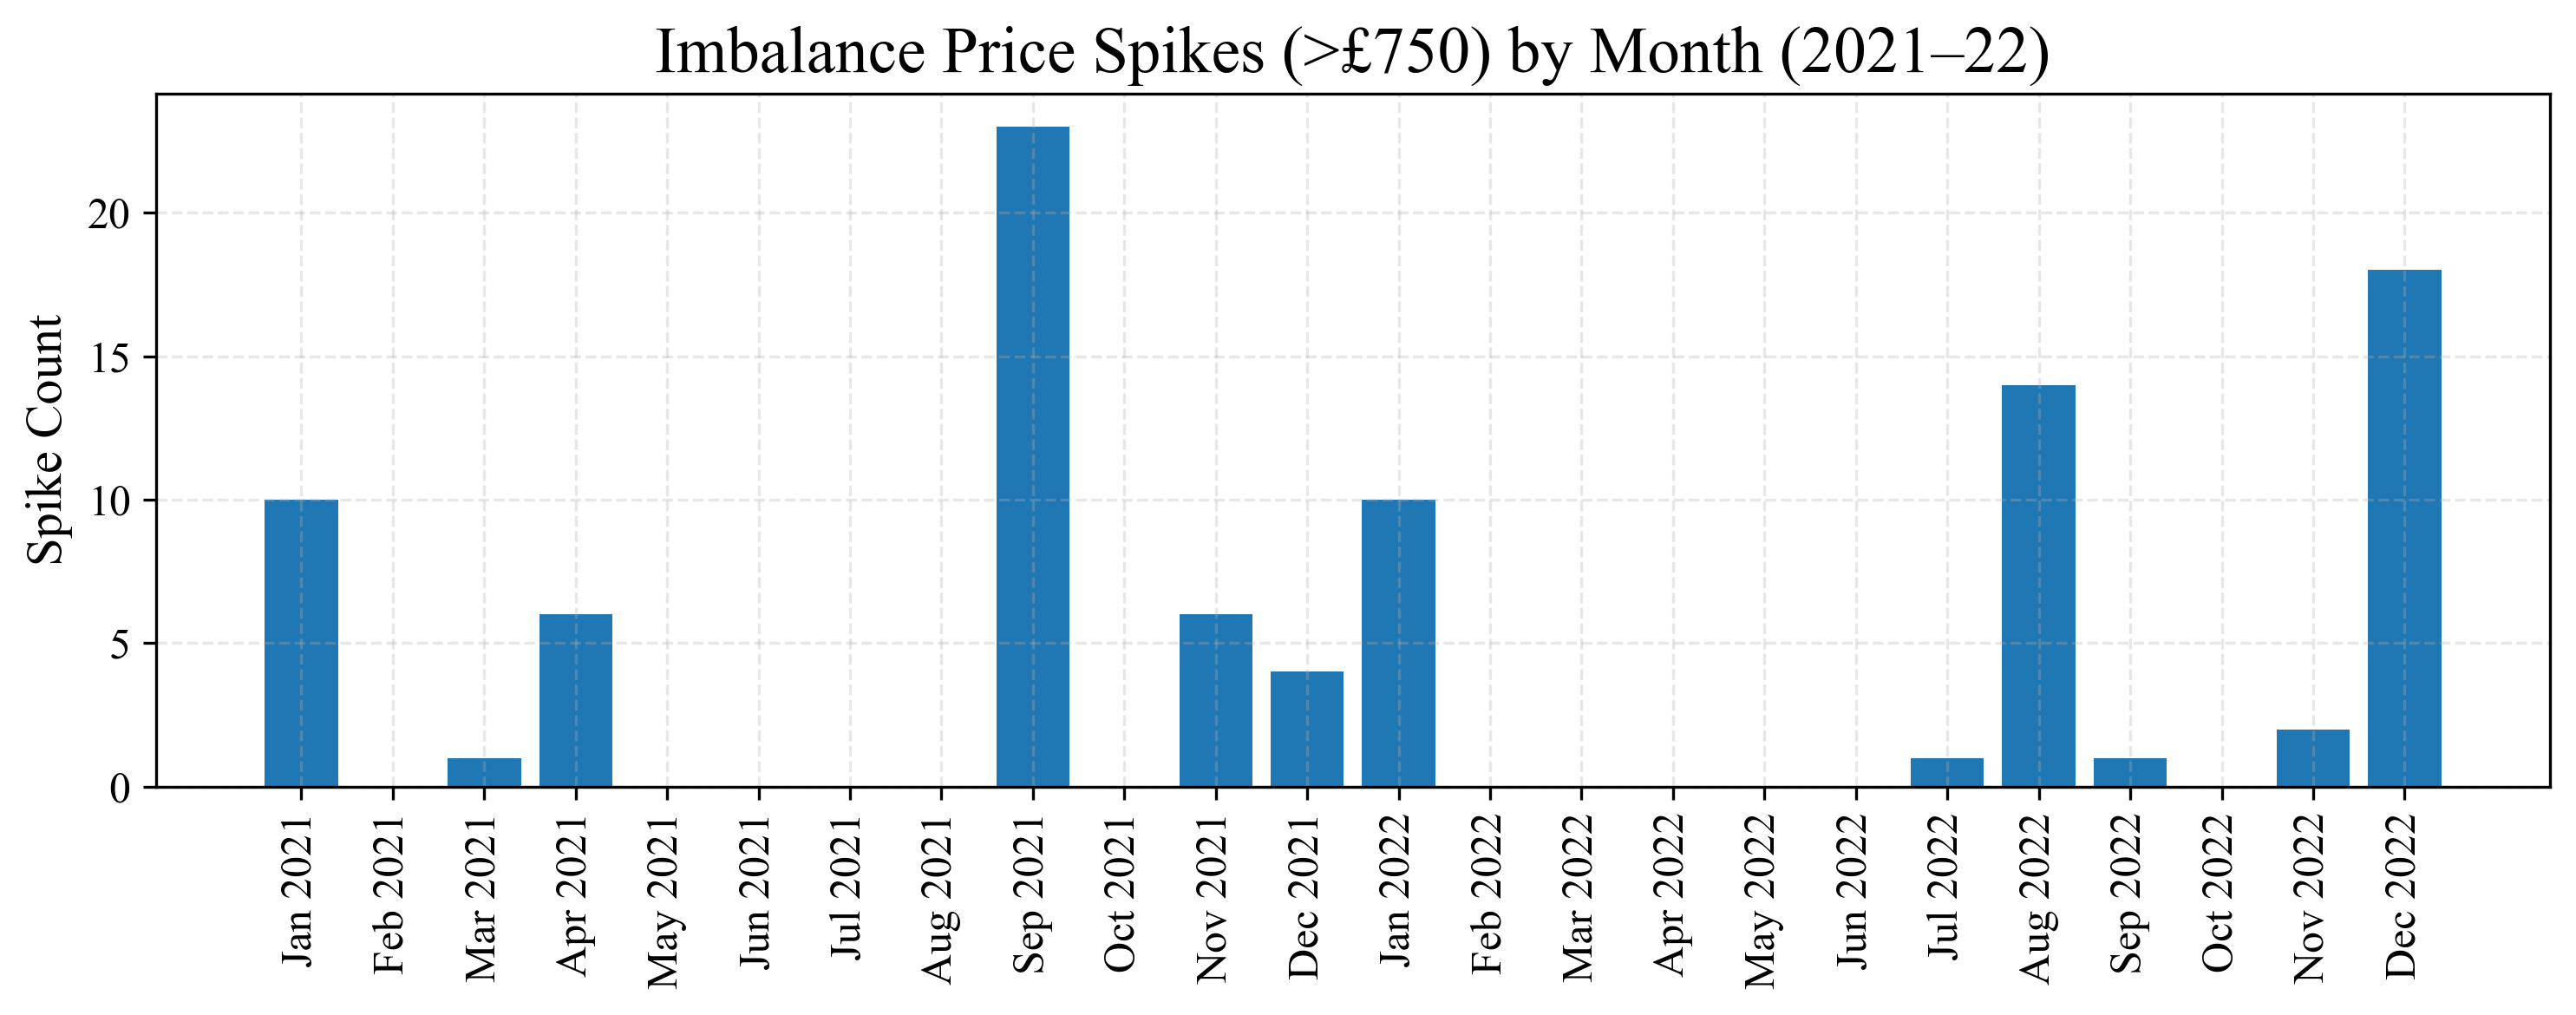

In [ ]:
time_bins = pd.date_range("00:00", "23:30", freq="30min").strftime("%H:%M")

times = spikes.index.strftime("%H:%M")
time_counts = times.value_counts().reindex(time_bins, fill_value=0)

plt.figure(figsize=(10, 4), dpi=300)
time_counts.plot(kind="bar", width=0.8)
plt.xticks(rotation=90)
plt.ylabel("Spike Count")
plt.title(f"Imbalance Price Spikes (>£{threshold}) by SP Start Time (2021–22)")
plt.tight_layout()
plt.show()


month_counts = spikes.resample('ME').size()
month_labels = month_counts.index.strftime('%b %Y')

plt.figure(figsize=(10, 4))
plt.bar(month_labels, month_counts, width=0.8)
plt.xticks(rotation=90)
plt.ylabel("Spike Count")
plt.title(f"Imbalance Price Spikes (>£{threshold}) by Month (2021–22)")
plt.tight_layout()
plt.show()

### Price vs. Volume

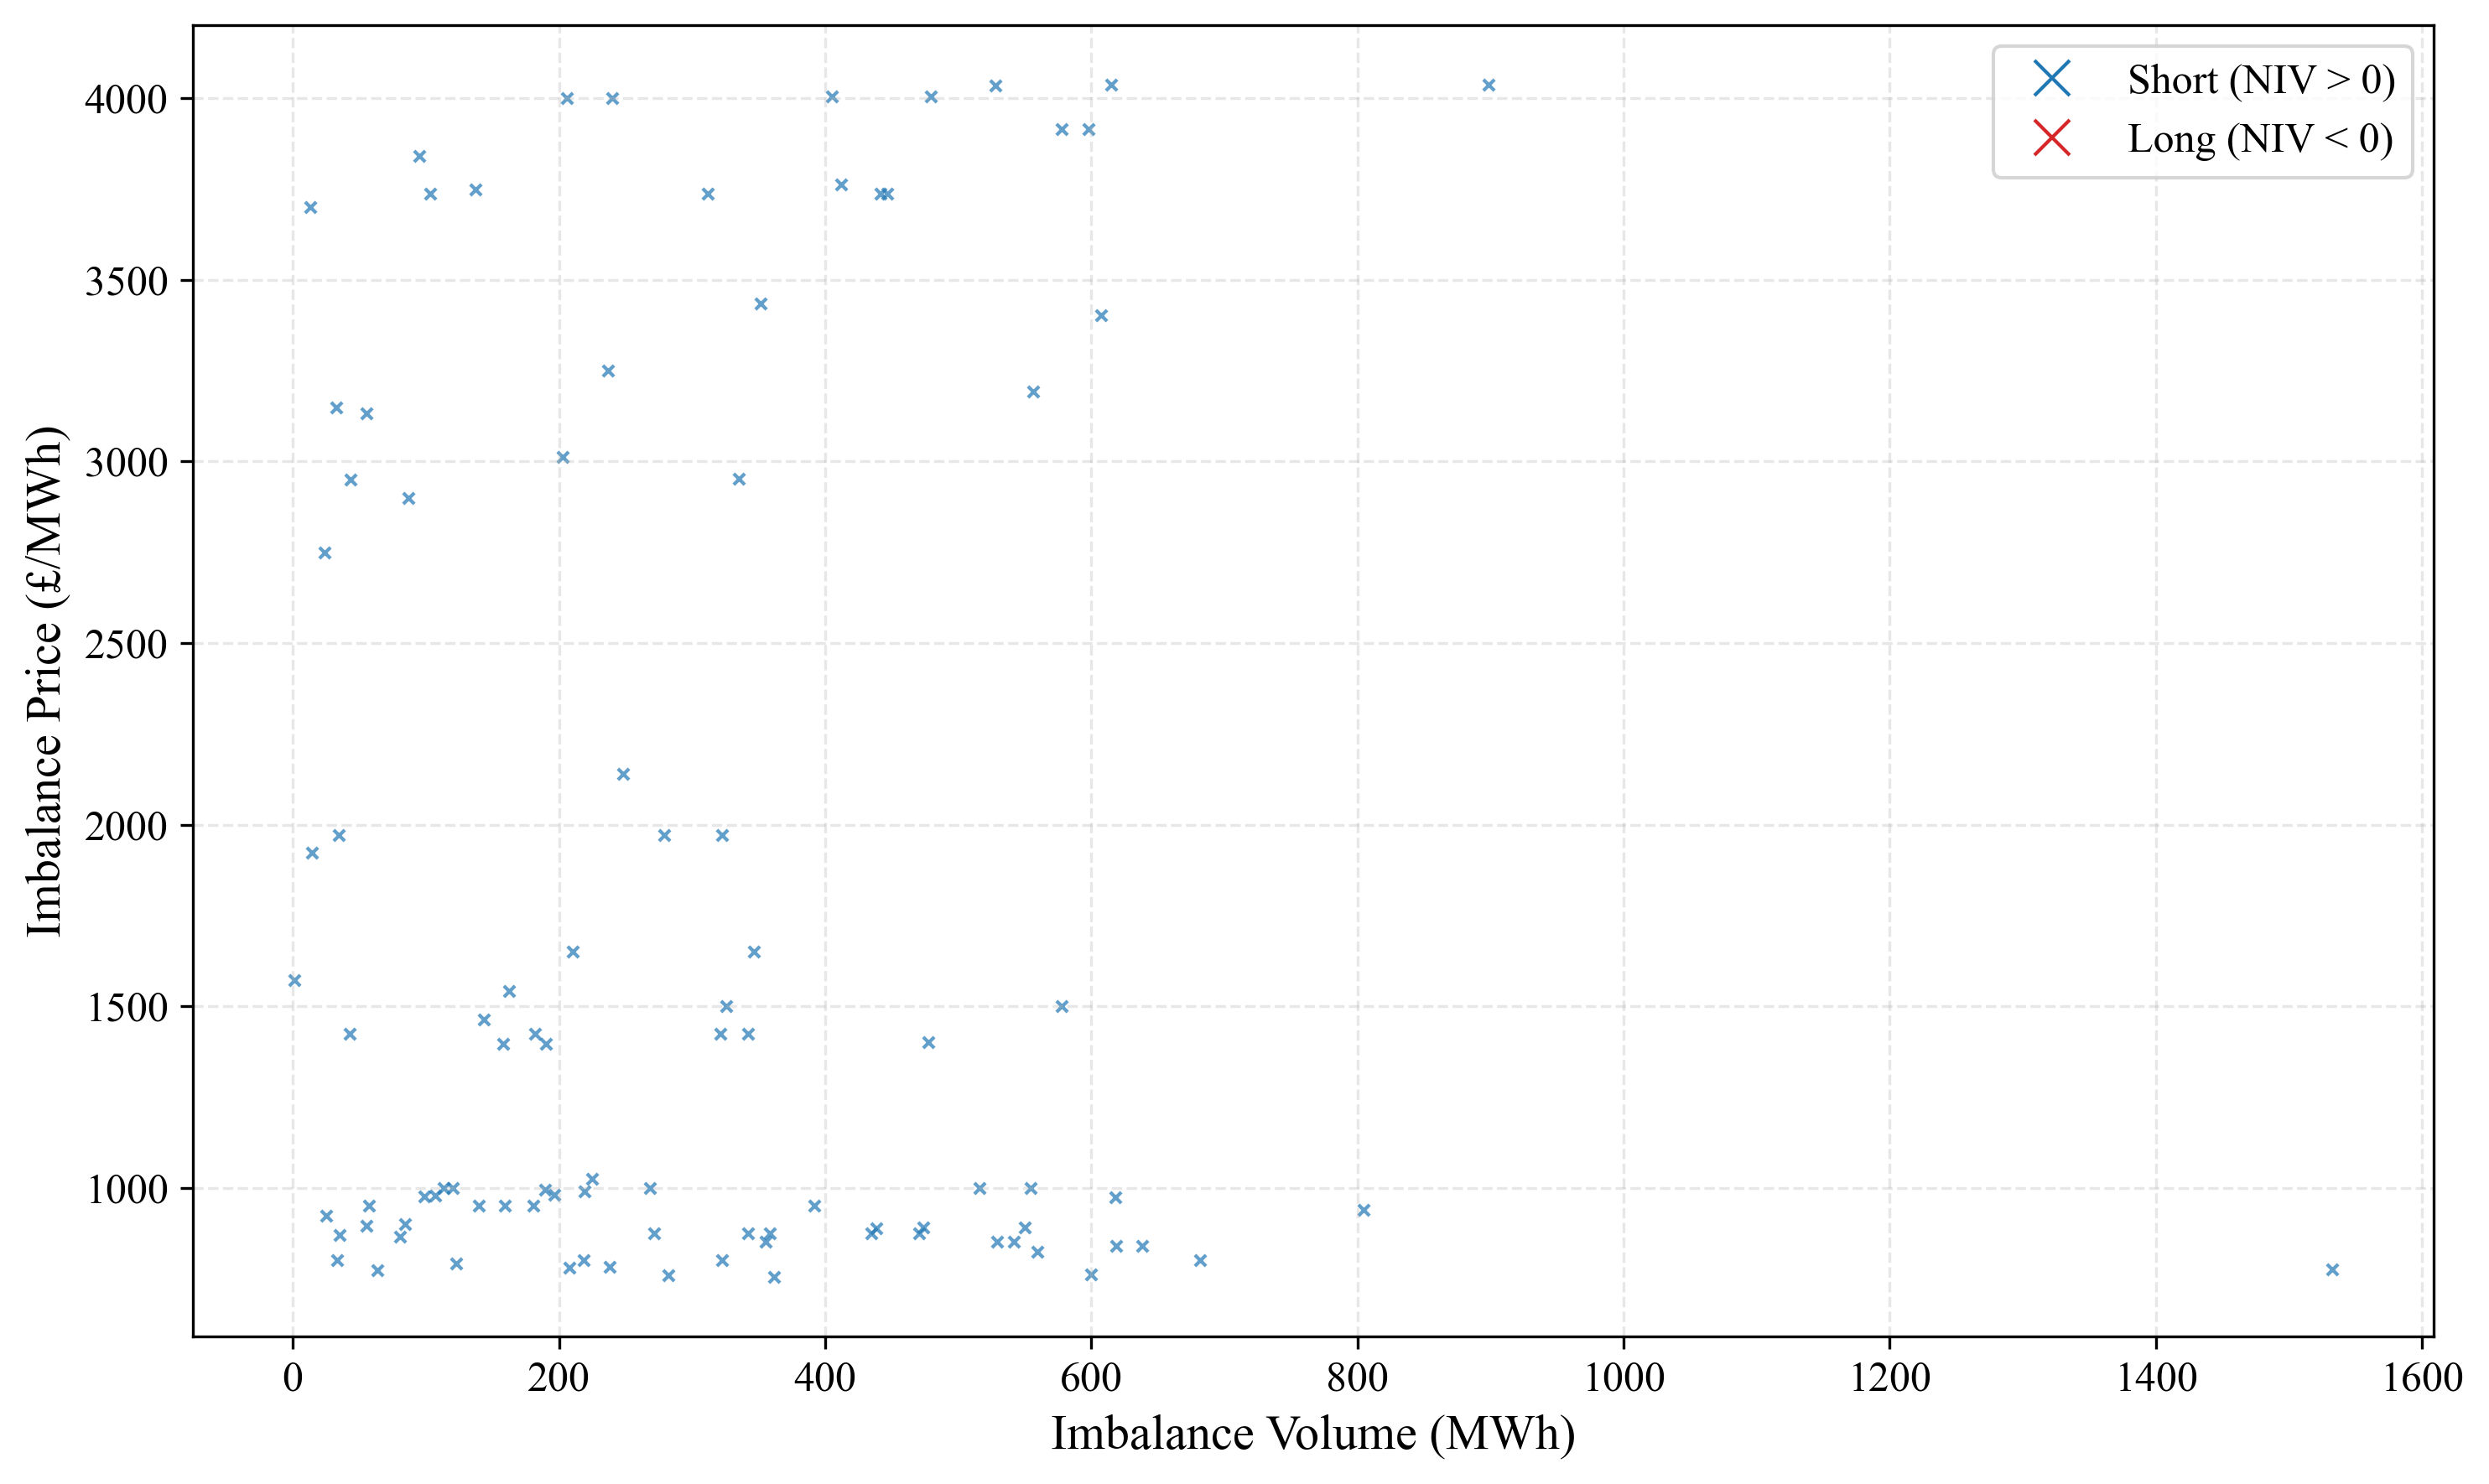

In [ ]:
spikes_volume = spikes["Imbalance Volume"]
spikes_price = spikes["Imbalance Price"]
neg_mask = spikes_volume < 0

# 1) Full scatter with coloured markers
plt.figure(figsize=(10, 6))
plt.scatter(spikes_volume[~neg_mask], spikes_price[~neg_mask], alpha=0.7, marker='x', s=10, linewidths=1)
plt.scatter(spikes_volume[neg_mask],  spikes_price[neg_mask],  alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red')

# Custom legend with larger markers
legend_handles = [
    Line2D([0], [0], marker='x', color='tab:blue', markersize=10, linestyle='None', label="Short (NIV > 0)"),
    Line2D([0], [0], marker='x', color='tab:red',  markersize=10, linestyle='None', label="Long (NIV < 0)")
]
plt.legend(handles=legend_handles)

plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.tight_layout()
plt.show()

### Scatter Plots for Price vs. Wind and DRM

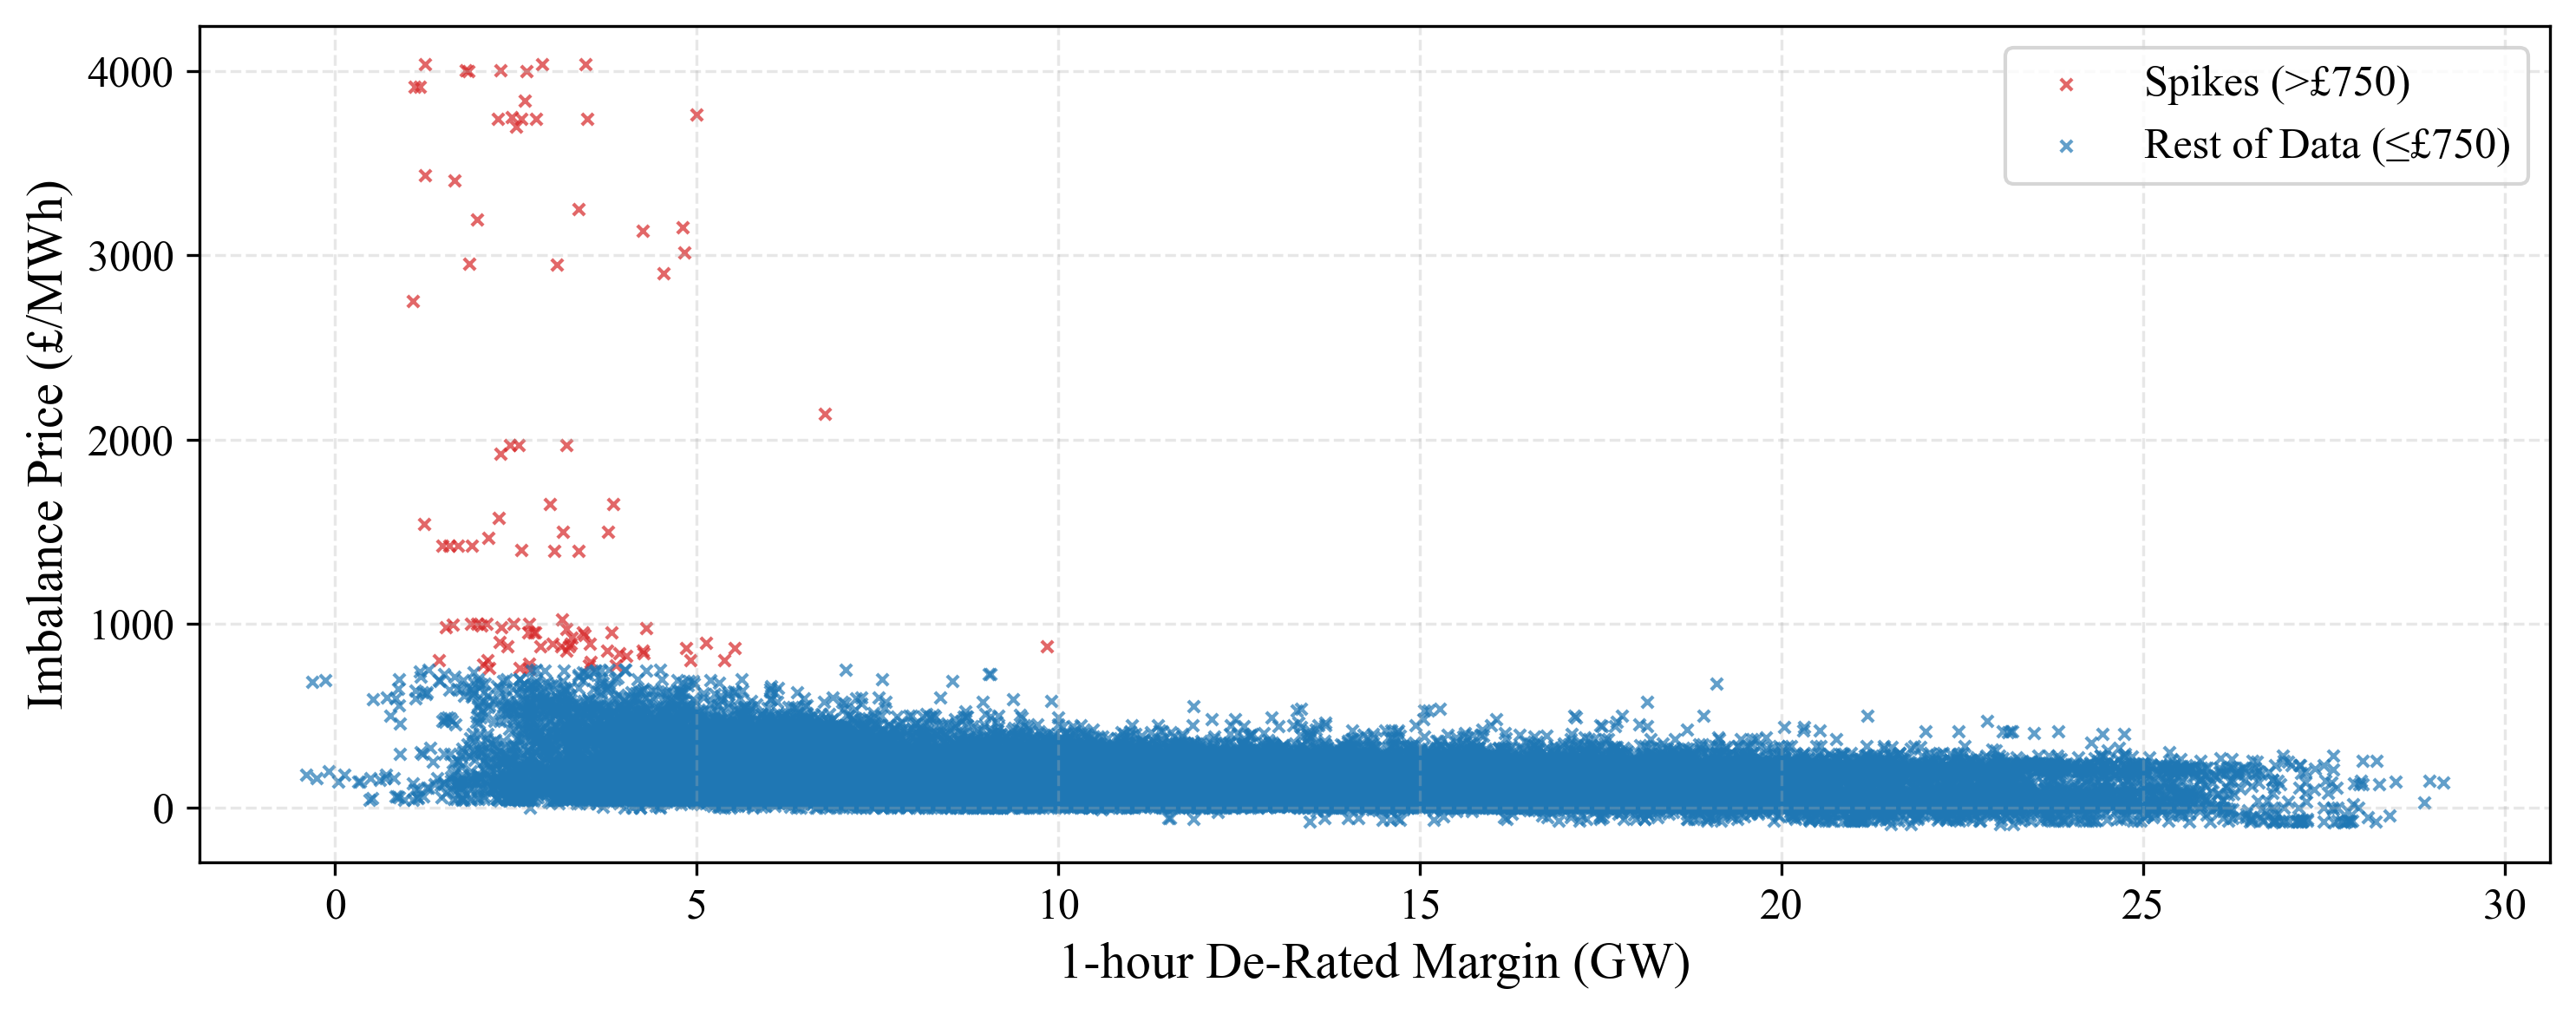

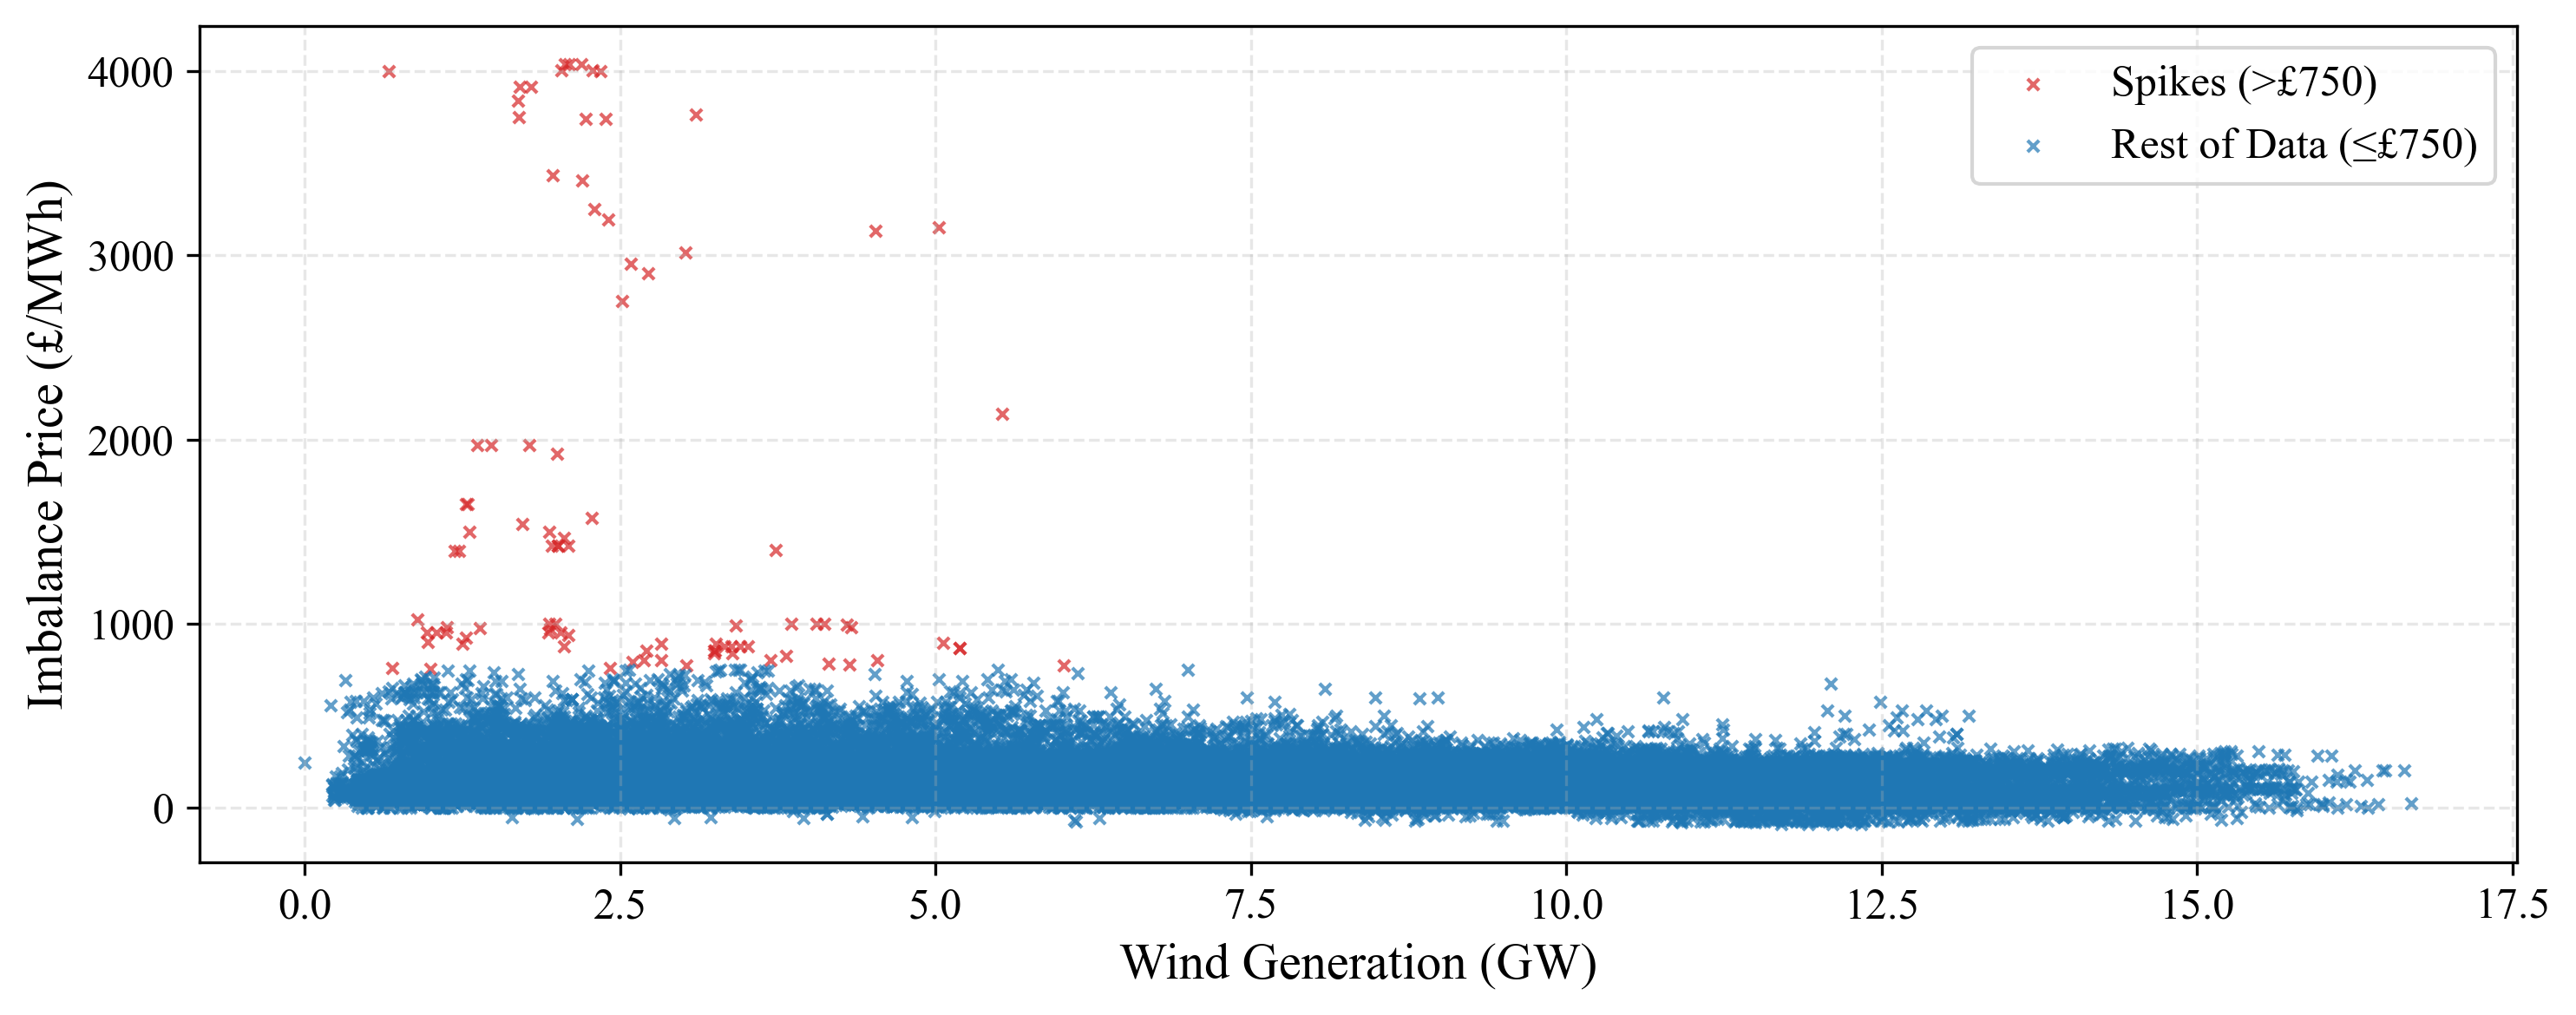

In [ ]:
spikes_drm = spikes["De-Rated Margin (1h)"]
spikes_act_wind = spikes["Actual Wind"]
spikes_price = spikes["Imbalance Price"]

rest_drm   = rest["De-Rated Margin (1h)"]
rest_act_wind = rest["Actual Wind"]
rest_price = rest["Imbalance Price"]

plt.figure(figsize=(10, 4))
plt.scatter(spikes_drm, spikes_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red',   label=spikes_label)
plt.scatter(rest_drm, rest_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:blue', label=rest_label)

plt.xlabel("1-hour De-Rated Margin (GW)")
plt.ylabel("Imbalance Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(spikes_act_wind, spikes_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red',   label=spikes_label)
plt.scatter(rest_act_wind, rest_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:blue', label=rest_label)
plt.xlabel("Wind Generation (GW)")
plt.ylabel("Imbalance Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()



### Boxplots for DRM and Wind

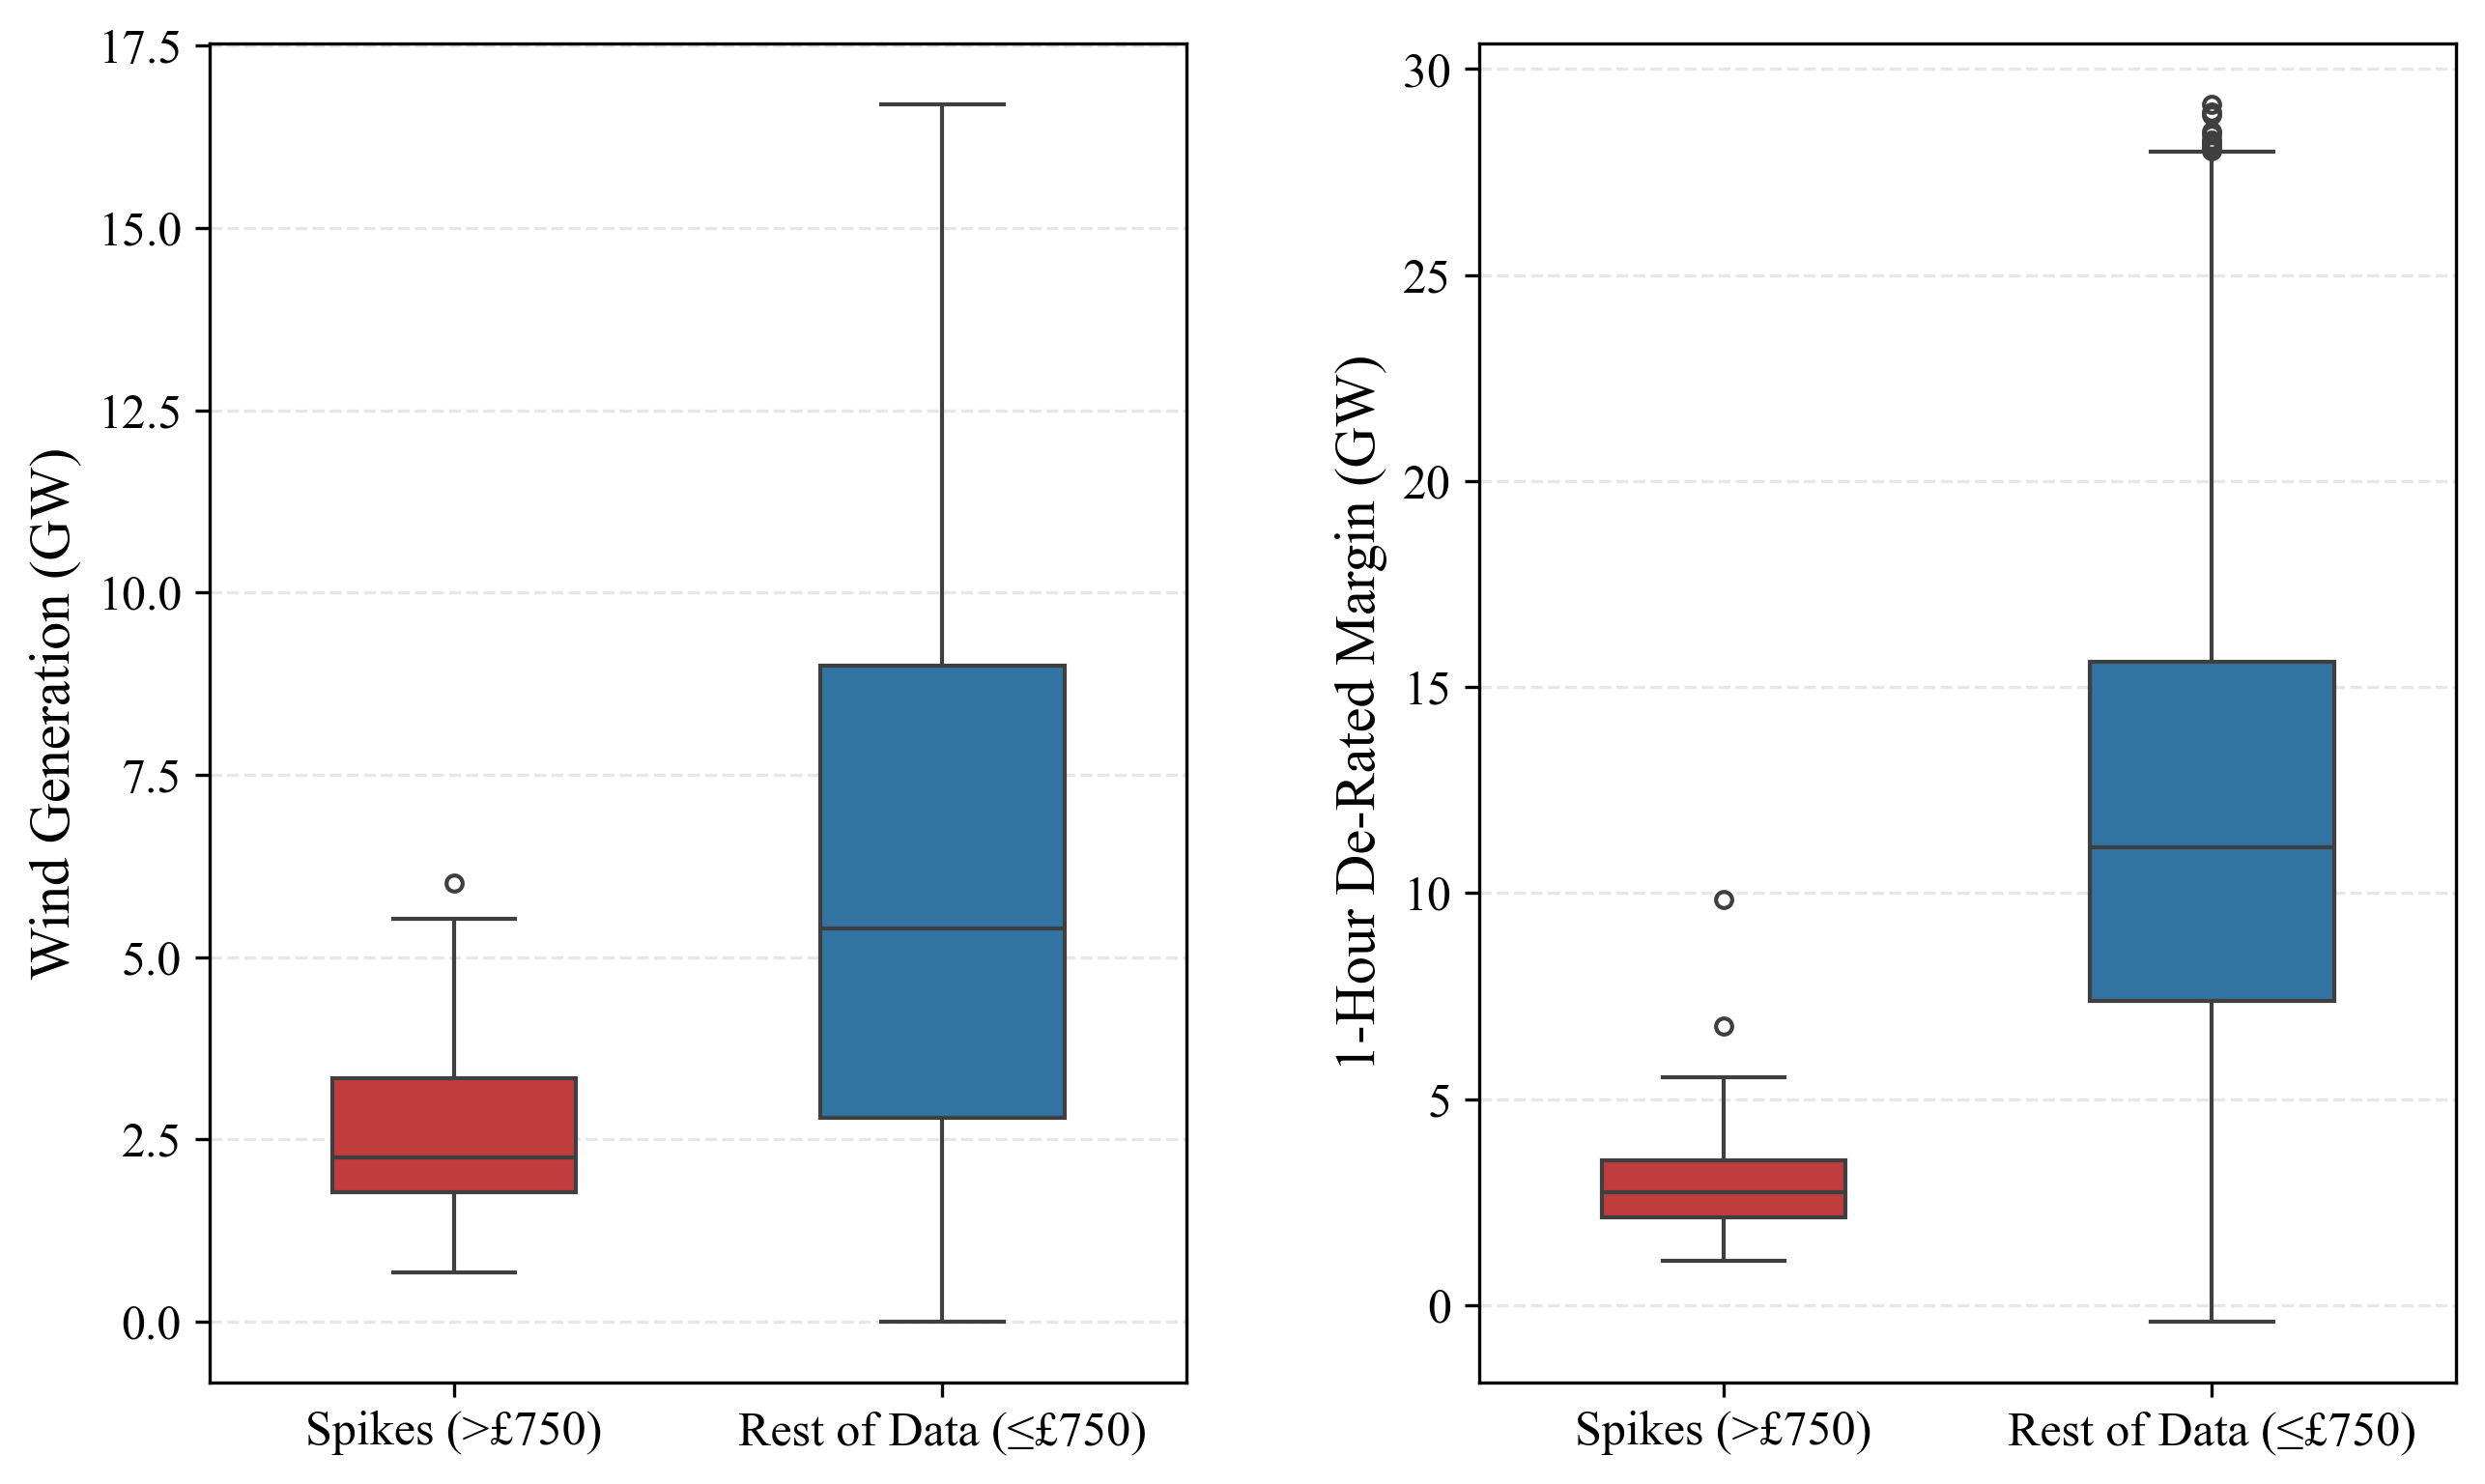

In [ ]:
df_wind = pd.concat([
    rest_act_wind.rename("Wind Generation (GW)").to_frame().assign(Period=rest_label),
    spikes_act_wind.rename("Wind Generation (GW)").to_frame().assign(Period=spikes_label),
])
df_drm = pd.concat([
    rest_drm.rename("1-Hour De-Rated Margin (GW)").to_frame().assign(Period=rest_label),
    spikes_drm.rename("1-Hour De-Rated Margin (GW)").to_frame().assign(Period=spikes_label),
])

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=300)
fig.subplots_adjust(wspace=.3)

sns.boxplot(
    data=df_wind,
    x="Period",
    y="Wind Generation (GW)",
    hue="Period",
    palette=["tab:red", "tab:blue"],
    order=[spikes_label, rest_label],
    hue_order=[spikes_label, rest_label],
    showfliers=True,
    fliersize=4,
    linewidth=1,
    width=0.5,
    ax=axes[0],
    legend=False
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Wind Generation (GW)")

sns.boxplot(
    data=df_drm,
    x="Period",
    y="1-Hour De-Rated Margin (GW)",
    hue="Period",
    palette=["tab:red", "tab:blue"],
    order=[spikes_label, rest_label],
    hue_order=[spikes_label, rest_label],
    showfliers=True,
    fliersize=4,
    linewidth=1,
    width=0.5,
    ax=axes[1],
    legend=False
)
axes[1].set_xlabel("")
axes[1].set_ylabel("1-Hour De-Rated Margin (GW)")

plt.show()


### Correlation Matrix

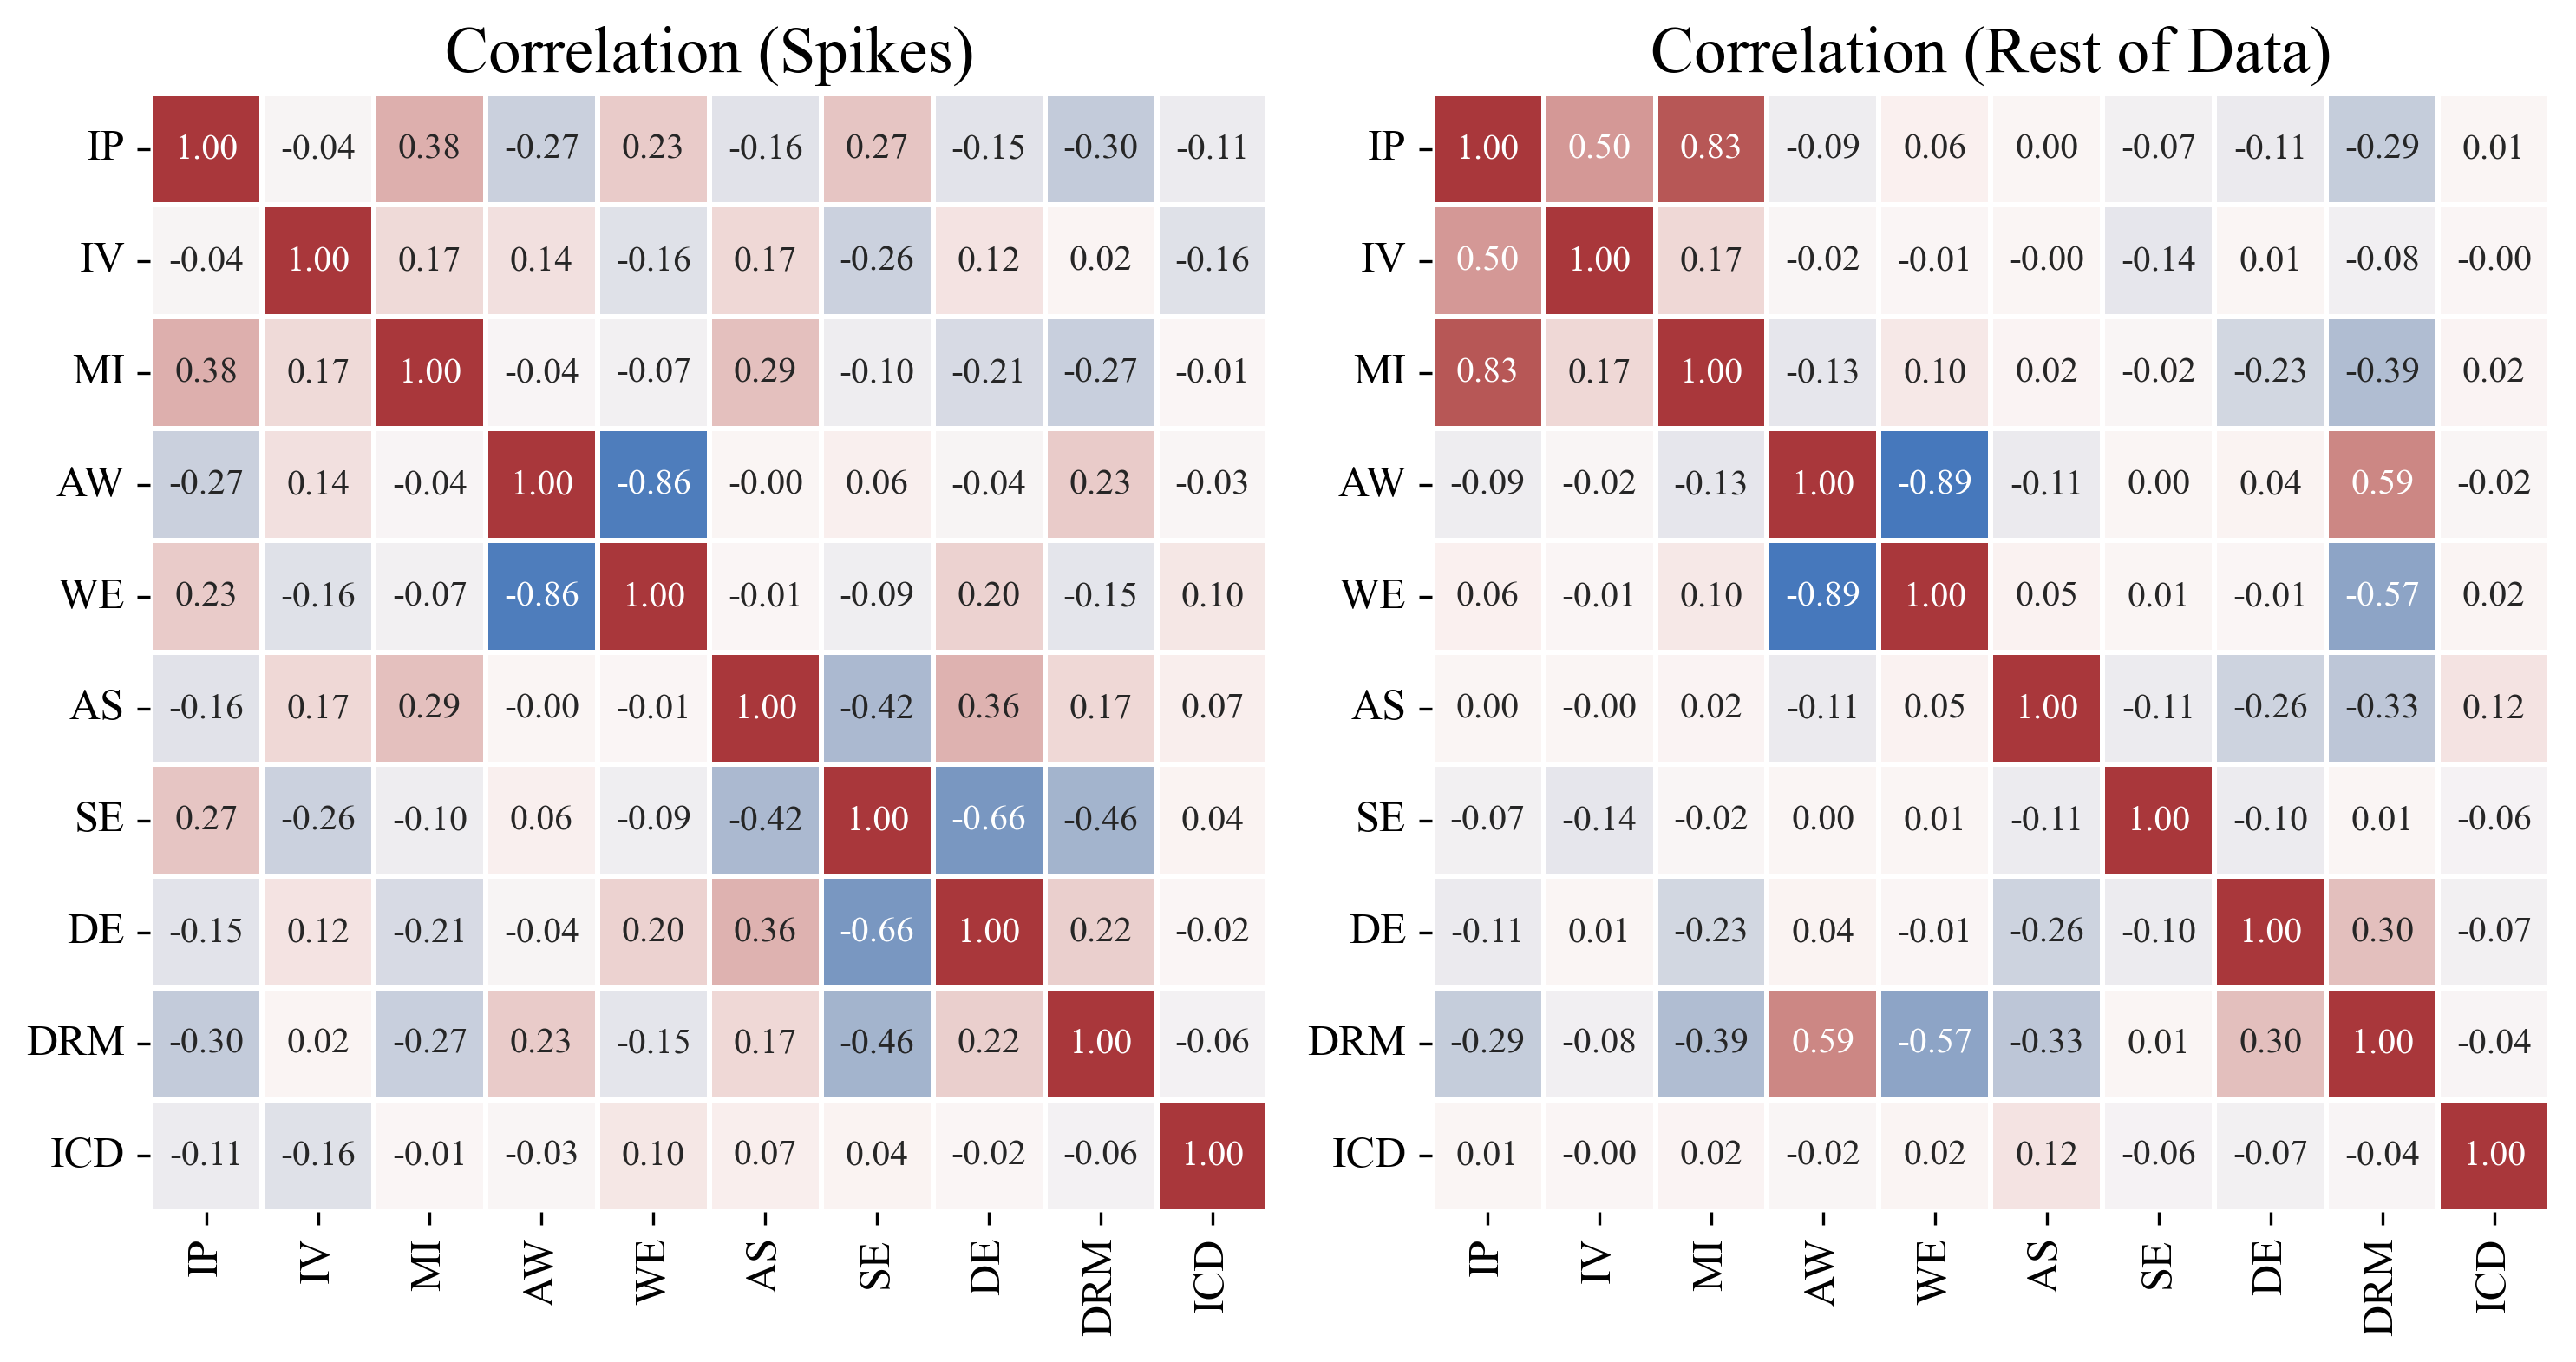

In [ ]:
labels={
    "Imbalance Price":      "IP",
    "Imbalance Volume":     "IV",
    "Market Index":         "MI",
    "Actual Wind":          "AW",
    "Actual Solar":         "AS",
    "Wind Error":           "WE",
    "Solar Error":          "SE",
    "Demand Error":         "DE",
    "De-Rated Margin (1h)": "DRM",
    "Inter Delta":          "ICD"
}

spikes_ren = spikes.rename(columns=labels, index=labels)
rest_ren   = rest.rename(columns=labels, index=labels)

corr_spike = spikes_ren.corr(method='spearman')
corr_rest  = rest_ren.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=300)
for ax, corr, title in zip(axes, [corr_spike, corr_rest], ['Correlation (Spikes)','Correlation (Rest of Data)']):
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0, cbar=False, ax=ax, square=True, linewidths=1)
    ax.set_title(title)
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()
